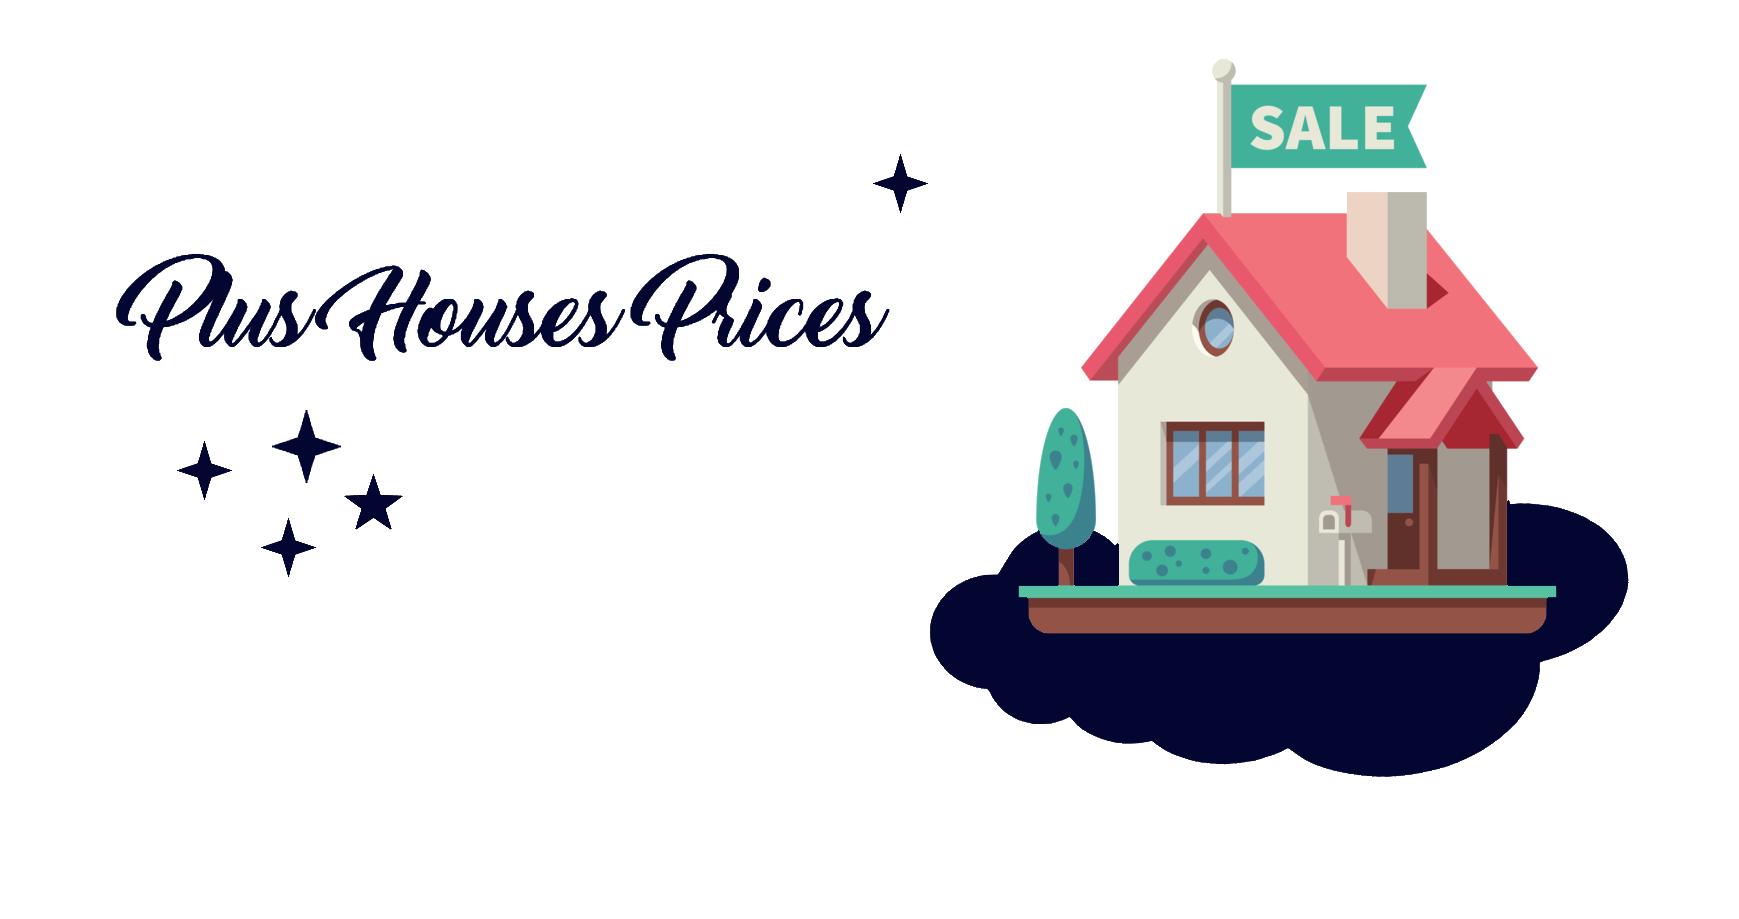

In [14]:
Image('../img/plusb.png')

<p style='text-align: center'><i>The company Plus House is a startup founded in 2022 that offers solutions for buying and selling real estate in a city in southern Brazil and its main activity
It is in the city of Caçador. The Company has a "tech" culture using algorithms for a better experience of buying and selling real estate.<i></p>

**Bussiness Context**<br>
During a Brainstorm meeting, a new problem raised brought up by one of the brokers, the price variation is very different from the other portfolios, causing doubt in the broker who receives these pricings and in the seller who does not understand why his property was classified in a specific price range.<br>
1. How to better price the prices of properties already enabled for sale ?
2. How to predict the price of properties giving their characteristics?

**What is a Realtor**<br>
The Realtor is responsible for intermediating the processes of buying and selling portfolios, help the customer and seller answering your questions and works in the bureaucratic part.

**Bussiness Model**<br>
The company receives property sellers of different categories (studio, house, flat, kitnets... ), depending on the characteristics of the property, the company itself buys the property to resell on the Site. The customer search on the site or mobile application the property of your choice, perform the registration and from there it enters a process called waterfall (Visit, Imagens of choiced portfolio...).<br>
Basically the money comes mainly for customer experience buying the property. That's why a lot of technology is important for the part of pricing these properties and even segmenting a list of possible customers who access the site.

**Metrics & Assumptions**<br>
- Market Share: Other enterprises in the region.
- Customers & Market Size: People over > 25 years old.
- Marketing Channel:
    1. Offline: Physical Agencies, interviews...
    2. Online: Plus Houses App, Regional Marketing.
- Customers:
    1. Main Objective is on New Customers.
- Website and App:
    - Page Speed Score and Bouce Rate is very important! (If the site / app is bad, the customer can never come back.)

1. Customers have good experience in App or Website ?
2. Older Customers can navigate on Site or App ?
3. One customer can get back and buy another portfolio* ?
4. How is the experience of customers on buying and selling process ?
5. How is the process of visiting in the portfolios ?
6. The Img in App / Site have a good view quality ? 
7. The Property have a good quality ?
8. The Property is located on 'rich' neighborhood ?
9. How is the description of these properties on the platform ?

<br>
    Data Info At Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques <br>
    Data Description at data_description.txt on '../data/data_description.txt'

**Sup. Materials**
- https://imoveis.estadao.com.br/compra/conheca-os-9-tipos-de-imoveis-residenciais-e-as-diferencas-entre-eles/
- https://www.redalyc.org/journal/5615/561559184012/html/
- mutuus.net/blog/corretora-de-seguros-o-que-e/
- https://everdrywisconsin.com/cinder-block-foundations-vs-poured-concrete/#:~:text=Poured%20concrete%20wall%20foundations%20are,it%20is%20easier%20to%20waterproof.
- https://kzas.ai/blog/vender/10-dicas-para-vender-imovel-rapido/
- 

## 0.1. Imports

In [3]:
import re
import pickle
import warnings
import inflection
import pandas as pd
import seaborn as sns

from random      import sample
from sklearn.svm import SVR
from scipy       import stats as ss
from xgboost     import XGBRegressor
from IPython.display import Image
from matplotlib      import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble     import RandomForestRegressor
from sklearn.model_selection     import train_test_split
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing       import MinMaxScaler, RobustScaler


%matplotlib inline
palette=sns.diverging_palette(359, 359, n=5, s=999, l=50, center='dark')

## 0.2. Aux Functions

In [439]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['font.size'] = 13
warnings.filterwarnings('ignore')

def metrics( df, verbose=False ):
    num_att = df.select_dtypes( include=['int64', 'float64'] )
    cat_att = df.select_dtypes( include=['object'] )
    
    if verbose:
        c1 = pd.DataFrame( num_att.apply( np.mean ) ).T
        c2 = pd.DataFrame( num_att.apply( np.std ) ).T
        d1 = pd.DataFrame( num_att.apply( min ) ).T
        d2 = pd.DataFrame( num_att.apply( max ) ).T
        d3 = pd.DataFrame( num_att.apply( lambda x: x.max() - x.min() ) ).T
        d4 = pd.DataFrame( num_att.apply( lambda x: x.skew() ) ).T
        d5 = pd.DataFrame( num_att.apply( lambda x: x.kurtosis() ) ).T

        m = pd.concat( [d1, d2, d3, c1, c2, d4, d5], axis=0 ).T.reset_index()
        m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'std', 'skew', 'kurtosis']
        
        return num_att, cat_att, m
    
    else:
        return num_att, cat_att
    
def get_importance( columns, model ):
    imp = {}
    for i in range( len( columns) ):
        imp[X_train.columns[i]] = model.feature_importances_[i]
    
    return imp

def mean_absolute_error( y, yhat ):
    return np.mean( np.abs( y - yhat ) )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( y - yhat ) / y )

def root_mean_square_error( y, yhat ):
    return np.sqrt( np.mean( (y - yhat)**2 ) )

def mean_percentage_error( y, yhat ):
    return np.sum( np.mean( y - yhat ) ) / 100

def ml_error( y, yhat, model_name ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = root_mean_square_error( y, yhat )
    return pd.DataFrame( {'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0] )

def cross_validation_year( df, year_feature, model_name, model, verbose=False ):
    years = df[year_feature].sort_values().unique().tolist()
    mae_list, mape_list, rmse_list = [], [], []

    for i in years:
        X_train_c = df[df[year_feature] == i].iloc[:, :-1]
        y_train_c = df[df[year_feature] == i].iloc[:, -1]
        X_test_c = df[df[year_feature] == i+1].iloc[:, :-1]
        y_test_c = df[df[year_feature] == i+1].iloc[:, -1]

        if X_test_c.empty:
            if verbose:
                print('All Years Cross V')

        else:
            if verbose:
                print(f'Year Number: {i-1} - {i}')
            ml = model.fit( X_train_c, y_train_c )

            yhat = ml.predict( X_test_c )

            result = ml_error( y_test_c**3, yhat**3, 'XGBoost' )

            mae_list.append( result['MAE'][0] )
            mape_list.append( result['MAPE'][0] )
            rmse_list.append( result['RMSE'][0] )

    mae_cv  = str( np.round( np.mean( mae_list ), 2 ) )  + ' +/- ' + str( np.round( np.std( mae_list ), 2 ) )
    mape_cv = str( np.round( np.mean( mape_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( mape_list ), 2 ) )
    rmse_cv = str( np.round( np.mean( rmse_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( rmse_list ), 2 ) )

    return pd.DataFrame( {'Model Name': model_name, 'MAE Cv': mae_cv, 'MAPE Cv': mape_cv, 'RMSE Cv': rmse_cv}, index=[0] )
    
def args( bins=np.arange(0, 2, 1), hstep='step', lwidth=2, c='r', label='Sales', normed=False):
        return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

def args_b( color=(1, 1, 1, 0), edgecolor=['navy', 'red'], linewidth=3 ):
    return {'linewidth': linewidth, 'color': color, 'edgecolor': edgecolor }

def linear_fillna( na_col, ref_col ):
    df11 = df1[[ref_col, na_col]]

    x_train = np.reshape( df11[~df11[na_col].isna()][ref_col].tolist(), (-1, 1) )
    y_train = np.reshape( df11[~df11[na_col].isna()][na_col].tolist(), (-1, 1) )
    x_test  = np.reshape( df11[df11[na_col].isna()][ref_col].tolist(), (-1, 1) )

    lin   = LinearRegression().fit( x_train, y_train )
    y_hat = lin.predict( x_test )

    df1.loc[df1[na_col].isna(), na_col] = y_hat
    
    return df1

def plot_targ_cube( df, targ ):
    fig, ax = plt.subplots( 1, 2, figsize=(15, 5))
    ax[0].hist( (df[targ]), **args(bins=100, c='k'));
    ax[1].hist( (df[targ])**(1/3), **args(bins=100, c='r'));
    
def plot_simple_columns( simple_columns ):
    for i in simple_columns:
        if len(c[i].unique()) == 4:     
            fig, ax = plt.subplots( 1, 2, figsize=(15, 6))
            for k in zip( range( 1, 5, 1 ), ['navy', 'red', 'black', 'yellow'] ):
                sns.kdeplot( c[c[i] == c[i].unique()[k[0]-1]]['sale_price'], label=c[i].unique()[k[0]-1], shade=True, ax=ax[0], linewidth=2, color=k[1] );
                ax[0].legend()
            sns.countplot( c[i], ax=ax[1], **args_b(edgecolor=['navy', 'red', 'black', 'yellow']) )
            ax[0].set_title(f'Density of {i}')
            ax[1].set_title(f'Count of {i}')

        if len(c[i].unique()) == 3:
            fig, ax = plt.subplots( 1, 2, figsize=(15, 6))
            for k in zip( range( 1, 4, 1 ), ['navy', 'red', 'black'] ):
                sns.kdeplot( c[c[i] == c[i].unique()[k[0]-1]]['sale_price'], label=c[i].unique()[k[0]-1], shade=True, ax=ax[0], linewidth=2, color=k[1] );
                ax[0].legend()
            sns.countplot( c[i], ax=ax[1], **args_b(edgecolor=['navy', 'red', 'black']) )
            ax[0].set_title(f'Density of {i}')
            ax[1].set_title(f'Count of {i}')

        if len(c[i].unique()) == 2:
            fig, ax = plt.subplots( 1, 2, figsize=(15, 6))
            for k in zip( range( 1, 3, 1 ), ['navy', 'red']):
                sns.kdeplot( c[c[i] == c[i].unique()[k[0]-1]]['sale_price'], label=c[i].unique()[k[0]-1], shade=True, ax=ax[0], linewidth=2, color=k[1] );
                ax[0].legend()
            sns.countplot( c[i], ax=ax[1], **args_b(edgecolor=['navy', 'red']) )
            ax[0].set_title(f'Density of {i}')
            ax[1].set_title(f'Count of {i}')
            
    return None

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values

    chi2 = ss.chi2_contingency( cm )[0]
    n    = cm.sum()
    r, k = cm.shape

    chi2corr = max( 0, chi2 - (r-1)*(k-1)/(n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    return np.sqrt( (chi2corr/n) / min(kcorr-1, rcorr-1) )

def plot_percent( dfa ):
    ax = sns.barplot( dfa['size_per'], dfa['sale_price'], palette=palette )
    for i, n in zip( ['Vry Poor', 'Poor', 'Fair', 'Blw Avg', 'Avg', 'Abv Avg', 'Good', 'Vry Good', 'Excellent', 'Vry Exllnt'], [-0.2, 0.8, 1.85, 2.7, 3.9, 4.7, 5.8, 6.65, 7.65, 8.63] ):
        if i == 'Vry Poor':
            ax.text( n, 2, i, color='k' )
        if i == 'Poor':
            ax.text( n, 2, i, color='k' )
        else:
            ax.text( n, 2, i, color='white' )

    plt.xticks( rotation=35 );
    
def plot_bar( df, var_x, var_y ):
    fig, ax = plt.subplots( 1, 2, figsize=(15, 5))
    ax[0].bar( df[var_x], df[var_y], **args_b() )
    sns.heatmap( df.corr( method='pearson'), annot=True, ax=ax[1] );

def plot_diff( df1, df2, label_x, label_y ):
    plt.subplot( 2, 1, 1 )
    sns.barplot( df1[label_x], df1[label_y], color='r', label='christmans' )
    sns.barplot( df2[label_x], df2[label_y], color='b', label='easter' )
    plt.legend();

    plt.subplot( 2, 1, 2 )
    plt.plot( df1[label_y], label='christmans', c='k' )
    plt.plot( df2[label_y], label='easter', c='r' )
    plt.legend();

    return None

def plot_year( df, x_var, y_var, y_list_1, y_list_2=None ):
    if y_list_2 != None:
        fig, ax = plt.subplots( 2, 1, figsize=(15, 10))
        
        for y, c in zip( y_list_1, ['r', 'k', 'b'] ):
            dfx = df[df['yr_sold'] == y]
            dfa2 = dfx[[x_var, y_var]].groupby(x_var).sum().reset_index()
            sns.regplot( dfa2[x_var], dfa2[y_var], color=c, label=str(y), ax=ax[0] )
            ax[0].legend();

        for y, c in zip( y_list_2, ['r', 'k'] ):
            dfx = df[df['yr_sold'] == y]
            dfa2 = dfx[[x_var, y_var]].groupby(x_var).sum().reset_index()
            sns.regplot( dfa2[x_var], dfa2[y_var], color=c, label=str(y), ax=ax[1] )
            ax[1].legend()
    else:
        fig, ax = plt.subplots( figsize=(15, 5))
        
        for y, c in zip( y_list_1, ['r', 'k', 'b'] ):
            dfx = df[df['yr_sold'] == y]
            dfa2 = dfx[[x_var, y_var]].groupby(x_var).sum().reset_index()
            sns.regplot( dfa2[x_var], dfa2[y_var], color=c, label=str(y), ax=ax )
            ax.legend();

## 0.3. Load Dataset

In [5]:
df_raw = pd.read_csv('../data/train.csv')

# 1.0. Descriptive Statistical

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns 

In [7]:
df1.columns = [inflection.underscore( p ) for p in df1.columns.tolist()]

## 1.2. Data Dimension 

Maldição da Alta dimensionalidade * 

In [8]:
print(f'Number of Columns: {df1.shape[1]}')
print(f'Number of Rows: {df1.shape[0]}')

Number of Columns: 81
Number of Rows: 1460


## 1.3. Data Types 

In [9]:
df1.iloc[:, :30].dtypes

id                  int64
ms_sub_class        int64
ms_zoning          object
lot_frontage      float64
lot_area            int64
street             object
alley              object
lot_shape          object
land_contour       object
utilities          object
lot_config         object
land_slope         object
neighborhood       object
condition1         object
condition2         object
bldg_type          object
house_style        object
overall_qual        int64
overall_cond        int64
year_built          int64
year_remod_add      int64
roof_style         object
roof_matl          object
exterior1st        object
exterior2nd        object
mas_vnr_type       object
mas_vnr_area      float64
exter_qual         object
exter_cond         object
foundation         object
dtype: object

In [10]:
df1.iloc[:, 30:].dtypes

bsmt_qual           object
bsmt_cond           object
bsmt_exposure       object
bsmt_fin_type1      object
bsmt_fin_sf1         int64
bsmt_fin_type2      object
bsmt_fin_sf2         int64
bsmt_unf_sf          int64
total_bsmt_sf        int64
heating             object
heating_qc          object
central_air         object
electrical          object
1st_flr_sf           int64
2nd_flr_sf           int64
low_qual_fin_sf      int64
gr_liv_area          int64
bsmt_full_bath       int64
bsmt_half_bath       int64
full_bath            int64
half_bath            int64
bedroom_abv_gr       int64
kitchen_abv_gr       int64
kitchen_qual        object
tot_rms_abv_grd      int64
functional          object
fireplaces           int64
fireplace_qu        object
garage_type         object
garage_yr_blt      float64
garage_finish       object
garage_cars          int64
garage_area          int64
garage_qual         object
garage_cond         object
paved_drive         object
wood_deck_sf         int64
o

## 1.4. Check Na 

In [37]:
df1.iloc[:, :30].isna().sum()

id                   0
ms_sub_class         0
ms_zoning            0
lot_frontage       259
lot_area             0
street               0
alley             1369
lot_shape            0
land_contour         0
utilities            0
lot_config           0
land_slope           0
neighborhood         0
condition1           0
condition2           0
bldg_type            0
house_style          0
overall_qual         0
overall_cond         0
year_built           0
year_remod_add       0
roof_style           0
roof_matl            0
exterior1st          0
exterior2nd          0
mas_vnr_type         8
mas_vnr_area         8
exter_qual           0
exter_cond           0
foundation           0
dtype: int64

In [38]:
df1.iloc[:, 30:].isna().sum()

bsmt_qual            37
bsmt_cond            37
bsmt_exposure        38
bsmt_fin_type1       37
bsmt_fin_sf1          0
bsmt_fin_type2       38
bsmt_fin_sf2          0
bsmt_unf_sf           0
total_bsmt_sf         0
heating               0
heating_qc            0
central_air           0
electrical            1
1st_flr_sf            0
2nd_flr_sf            0
low_qual_fin_sf       0
gr_liv_area           0
bsmt_full_bath        0
bsmt_half_bath        0
full_bath             0
half_bath             0
bedroom_abv_gr        0
kitchen_abv_gr        0
kitchen_qual          0
tot_rms_abv_grd       0
functional            0
fireplaces            0
fireplace_qu        690
garage_type          81
garage_yr_blt        81
garage_finish        81
garage_cars           0
garage_area           0
garage_qual          81
garage_cond          81
paved_drive           0
wood_deck_sf          0
open_porch_sf         0
enclosed_porch        0
3_ssn_porch           0
screen_porch          0
pool_area       

## 1.5. Fillout Na 

1. **LotFrontage: Linear feet of street connected to property. ->**
Linear YHAT with lot_area
    
2. **Alley: Type of alley access to property ( Gravel, Paved ) NA, dont have alley. ->**
Fillna 'DontHave' (Future Lable Encoder)

3. **Basement (bsmt) equal is the Height of Basement, NA, dont have basement. ->**
Fillna DontHave (Future * Encoder)

4. **Basement (bsmt) cond is the condition of Basement, Na, dont have basement. ->**
Fillna DontHave (Future * Encoder)
    
5. **Basement (bsmt) exposure Refers to walkout or garden level walls. -> **
Fillna DontHave (Future * Encoder)
    
6. **BsmtFinType1: Rating of basement finished area -> bsmt_fin_type2. ->**
Fillna DontHave (Future * Encoder)
    
7. **electrical: Type of electrical system. (dont have eletricity) ->**
Fillna 'DontHave' (Future * Encoder)
    
8. **FireplaceQu: Fireplace quality Na, dont have Fireplace. ->**
Fillna 'DontHave' (Future * Encoder)
    
9. **Garage* Na, dont have Garage. ->**
Fillna 'DontHave' (Future * Encoder)
GarageFinish -> ( Unf Unfinished ), Na, no garage.
    
10. **PoolQC: Pool quality Na, dont have pool. ->**
Fillna 'DontHave'
    
11. **MiscFeature: Miscellaneous feature not covered in other categories (Elevator, Gar2.. ) ->**
Fillna 'DontHave'

1. **mas_vnr_type** Masonry veneer type.<br>
What is the exterior wall material of property.

1. **mas_vnr_area** Masonry veneer area in square feet


In [33]:
df1.loc[df1.mas_vnr_area.isna(), ['mas_vnr_area', 'mas_vnr_type', 'sale_price', 'exter_qual', 'exter_cond','exterior1st', 'exterior2nd', 'condition1']]

mas_vnr_area mas_vnr_type  sale_price exter_qual exter_cond exterior1st  \
234            NaN          NaN      216500         Gd         TA     VinylSd   
529            NaN          NaN      200624         Gd         TA     Wd Sdng   
650            NaN          NaN      205950         Gd         TA     CemntBd   
936            NaN          NaN      184900         Gd         TA     VinylSd   
973            NaN          NaN      182000         Gd         TA     CemntBd   
977            NaN          NaN      199900         Gd         TA     VinylSd   
1243           NaN          NaN      465000         Ex         TA     VinylSd   
1278           NaN          NaN      237000         Gd         TA     VinylSd   

     exterior2nd condition1  
234      VinylSd       Norm  
529        Stone       Norm  
650      CmentBd       Norm  
936      VinylSd       Norm  
973      CmentBd       Norm  
977      VinylSd       Norm  
1243     VinylSd       Norm  
1278     VinylSd       Norm

In [26]:
df1[df1['electrical'].isna()] # House without eletricy xD

id  ms_sub_class ms_zoning  lot_frontage  lot_area street alley  \
1379  1380            80        RL          73.0      9735   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
1379       Reg          Lvl    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  sale_condition  \
1379          NaN        0       5    2008         WD          Normal   

      sale_price  
1379      167500  

[1 rows x 81 columns]

In [46]:
df1.loc[df1.garage_cars == 0, ['garage_cars', 'garage_area']].sample(5)

garage_cars  garage_area
140            0            0
250            0            0
613            0            0
39             0            0
968            0            0

In [51]:
df1 = linear_fillna( 'lot_frontage', 'lot_area' )

df1['alley'] = df1['alley'].fillna( 'DontHave' )

df1['mas_vnr_type'] = df1['mas_vnr_type'].fillna( 'DontHave' )
df1['mas_vnr_area'] = df1['mas_vnr_area'].fillna( 0 )

df1['bsmt_qual']      = df1['bsmt_qual'].fillna( 'DontHave' )
df1['bsmt_cond']      = df1['bsmt_cond'].fillna( 'DontHave' )
df1['bsmt_exposure']  = df1['bsmt_exposure'].fillna( 'DontHave' )
df1['bsmt_fin_type1'] = df1['bsmt_fin_type1'].fillna( 'DontHave' )
df1['bsmt_fin_type2'] = df1['bsmt_fin_type2'].fillna( 'DontHave' )

df1['electrical']   = df1['electrical'].fillna('DontHave')
df1['fireplace_qu'] = df1['fireplace_qu'].fillna('DontHave')

df1['garage_type']   = df1['garage_type'].fillna( 'DontHave' )
df1['garage_yr_blt'] = df1['garage_yr_blt'].fillna( 0 )
df1['garage_finish'] = df1['garage_finish'].fillna( 'DontHave' )
df1['garage_qual']   = df1['garage_qual'].fillna( 'DontHave' )
df1['garage_cond']   = df1['garage_cond'].fillna( 'DontHave' )

df1['pool_qc']      = df1['pool_qc'].fillna( 'DontHave' )
df1['fence']        = df1['fence'].fillna( 'DontHave' )
df1['misc_feature'] = df1['misc_feature'].fillna( 'DontHave' )

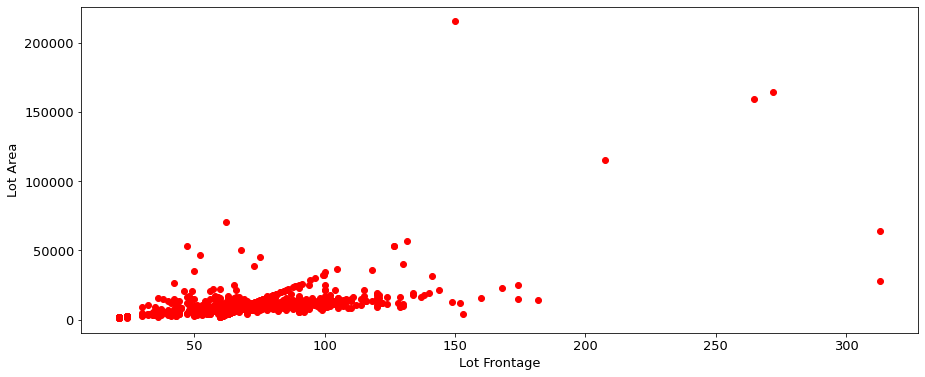

In [52]:
plt.scatter( df1['lot_frontage'], df1['lot_area'], c='r' )
plt.xlabel('Lot Frontage')
plt.ylabel('Lot Area');

## 1.6. Change Data Types 

In [121]:
# df1.loc[df1['garage_yr_blt'] == 'DontHave', 'garage_yr_blt'] = 0 # Year of Garage Builted
# df1.loc[df1['mas_vnr_area'] == 'DontHave', 'mas_vnr_area']   = 0

#df1['mas_vnr_area'] = df1['mas_vnr_area'].astype('int64')

df1 = df1.drop( columns=['id'], axis=1 )

In [59]:
df1.columns # Unique Columns Datatype Checked

Index(['id', 'ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmt_fin_type1', 'bsmt_fin_sf1', 'bsmt_fin_type2', 'bsmt_fin_sf2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'kitchen_qual',
       'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish'

## 1.7. Descriptive Statistical

In [122]:
num_att = df1.select_dtypes( include=['int64', 'float64'] )
cat_att = df1.select_dtypes( include=['object'] )

### 1.7.1. Numerical Data

In [123]:
_, _, c = metrics( df1, True )
c

attributes      min       max     range           mean           std  \
0      ms_sub_class     20.0     190.0     170.0      56.897260     42.286082   
1      lot_frontage     21.0     313.0     292.0      70.787904     23.800766   
2          lot_area   1300.0  215245.0  213945.0   10516.828082   9977.846105   
3      overall_qual      1.0      10.0       9.0       6.099315      1.382523   
4      overall_cond      1.0       9.0       8.0       5.575342      1.112418   
5        year_built   1872.0    2010.0     138.0    1971.267808     30.192559   
6    year_remod_add   1950.0    2010.0      60.0    1984.865753     20.638335   
7      mas_vnr_area      0.0    1600.0    1600.0     103.117123    180.669468   
8      bsmt_fin_sf1      0.0    5644.0    5644.0     443.639726    455.941866   
9      bsmt_fin_sf2      0.0    1474.0    1474.0      46.549315    161.264017   
10      bsmt_unf_sf      0.0    2336.0    2336.0     567.240411    441.715605   
11    total_bsmt_sf      0.0    6110.0    6110.0    1057.429452    438.555057   
12       1st_flr_sf    334.0    4692.0    4358.0    1162.626712    386.455322   
13       2nd_flr_sf      0.0    2065.0    2065.0     346.992466    436.378914   
14  low_qual_fin_sf      0.0     572.0     572.0       5.844521     48.606427   
15      gr_liv_area    334.0    5642.0    5308.0    1515.463699    525.300394   
16   bsmt_full_bath      0.0       3.0       3.0       0.425342      0.518733   
17   bsmt_half_bath      0.0       2.0       2.0       0.057534      0.238671   
18        full_bath      0.0       3.0       3.0       1.565068      0.550727   
19        half_bath      0.0       2.0       2.0       0.382877      0.502713   
20   bedroom_abv_gr      0.0       8.0       8.0       2.866438      0.815499   
21   kitchen_abv_gr      0.0       3.0       3.0       1.046575      0.220263   
22  tot_rms_abv_grd      2.0      14.0      12.0       6.517808      1.624837   
23       fireplaces      0.0       3.0       3.0       0.613014      0.644446   
24    garage_yr_blt      0.0    2010.0    2010.0    1868.739726    453.541893   
25      garage_cars      0.0       4.0       4.0       1.767123      0.747059   
26      garage_area      0.0    1418.0    1418.0     472.980137    213.731608   
27     wood_deck_sf      0.0     857.0     857.0      94.244521    125.295863   
28    open_porch_sf      0.0     547.0     547.0      46.660274     66.233333   
29   enclosed_porch      0.0     552.0     552.0      21.954110     61.098214   
30      3_ssn_porch      0.0     508.0     508.0       3.409589     29.307289   
31     screen_porch      0.0     480.0     480.0      15.060959     55.738317   
32        pool_area      0.0     738.0     738.0       2.758904     40.163545   
33         misc_val      0.0   15500.0   15500.0      43.489041    495.953090   
34          mo_sold      1.0      12.0      11.0       6.321918      2.702700   
35          yr_sold   2006.0    2010.0       4.0    2007.815753      1.327640   
36       sale_price  34900.0  755000.0  720100.0  180921.195890  79415.291886   

         skew    kurtosis  
0    1.407657    1.580188  
1    2.760080   22.331476  
2   12.207688  203.243271  
3    0.216944    0.096293  
4    0.693067    1.106413  
5   -0.613461   -0.439552  
6   -0.503562   -1.272245  
7    2.677616   10.141416  
8    1.685503   11.118236  
9    4.255261   20.113338  
10   0.920268    0.474994  
11   1.524255   13.250483  
12   1.376757    5.745841  
13   0.813030   -0.553464  
14   9.011341   83.234817  
15   1.366560    4.895121  
16   0.596067   -0.839098  
17   4.103403   16.396642  
18   0.036562   -0.857043  
19   0.675897   -1.076927  
20   0.211790    2.230875  
21   4.488397   21.532404  
22   0.676341    0.880762  
23   0.649565   -0.217237  
24  -3.869501   13.043226  
25  -0.342549    0.220998  
26   0.179981    0.917067  
27   1.541376    2.992951  
28   2.364342    8.490336  
29   3.089872   10.430766  
30  10.304342  123.662379  
31   4.122214   18.439068  
32  14

### 1.7.2. Categorical Data

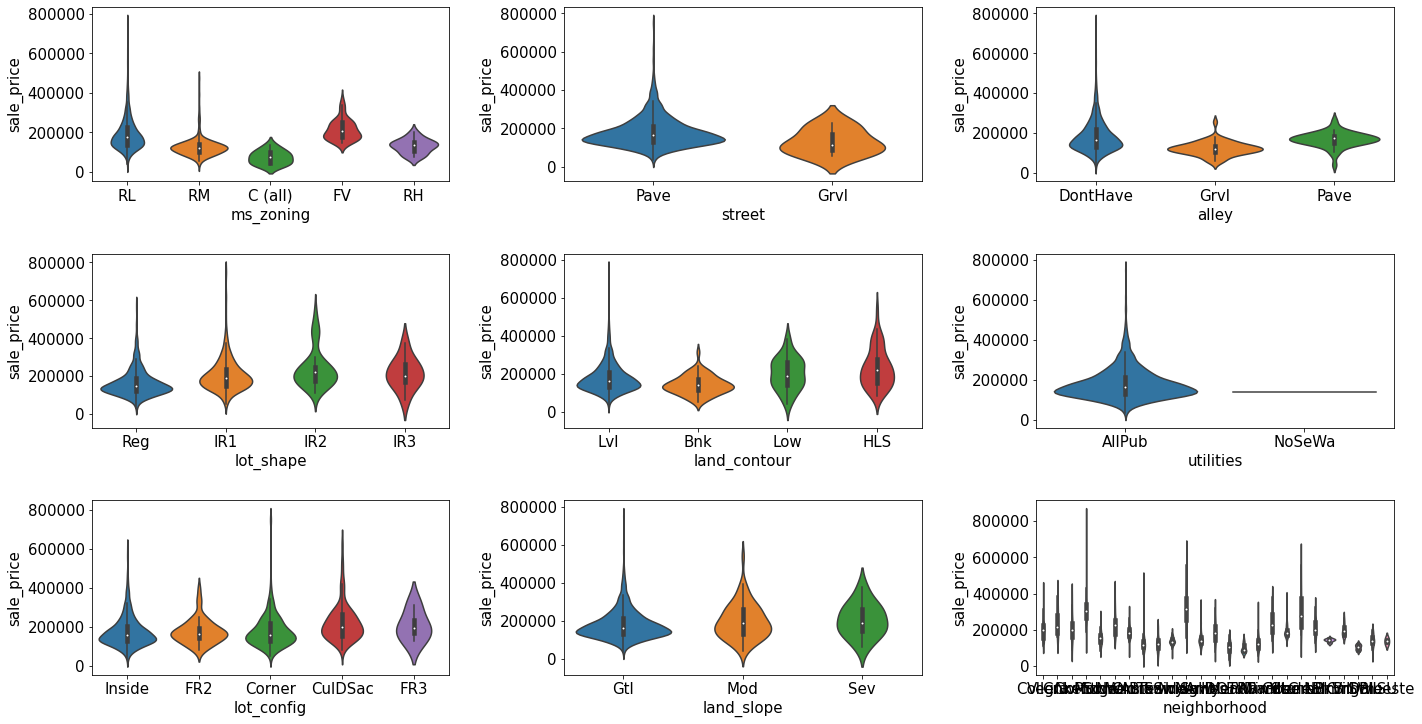

In [124]:
cols_list = cat_att.columns.tolist()
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['font.size'] = 15

for i in range( 1, 10 ):
    plt.subplot( 6, 3, i )
    sns.violinplot( cat_att[cols_list[:9][i-1]], df1['sale_price'] )
    plt.tight_layout(w_pad=2., h_pad=2.)

### 1.7.3. Pandas Profiling

In [85]:
# p = ProfileReport(df1)
# p.to_file('output.html')

# 2.0. Feature Engineering

## 2.1. Mind Map

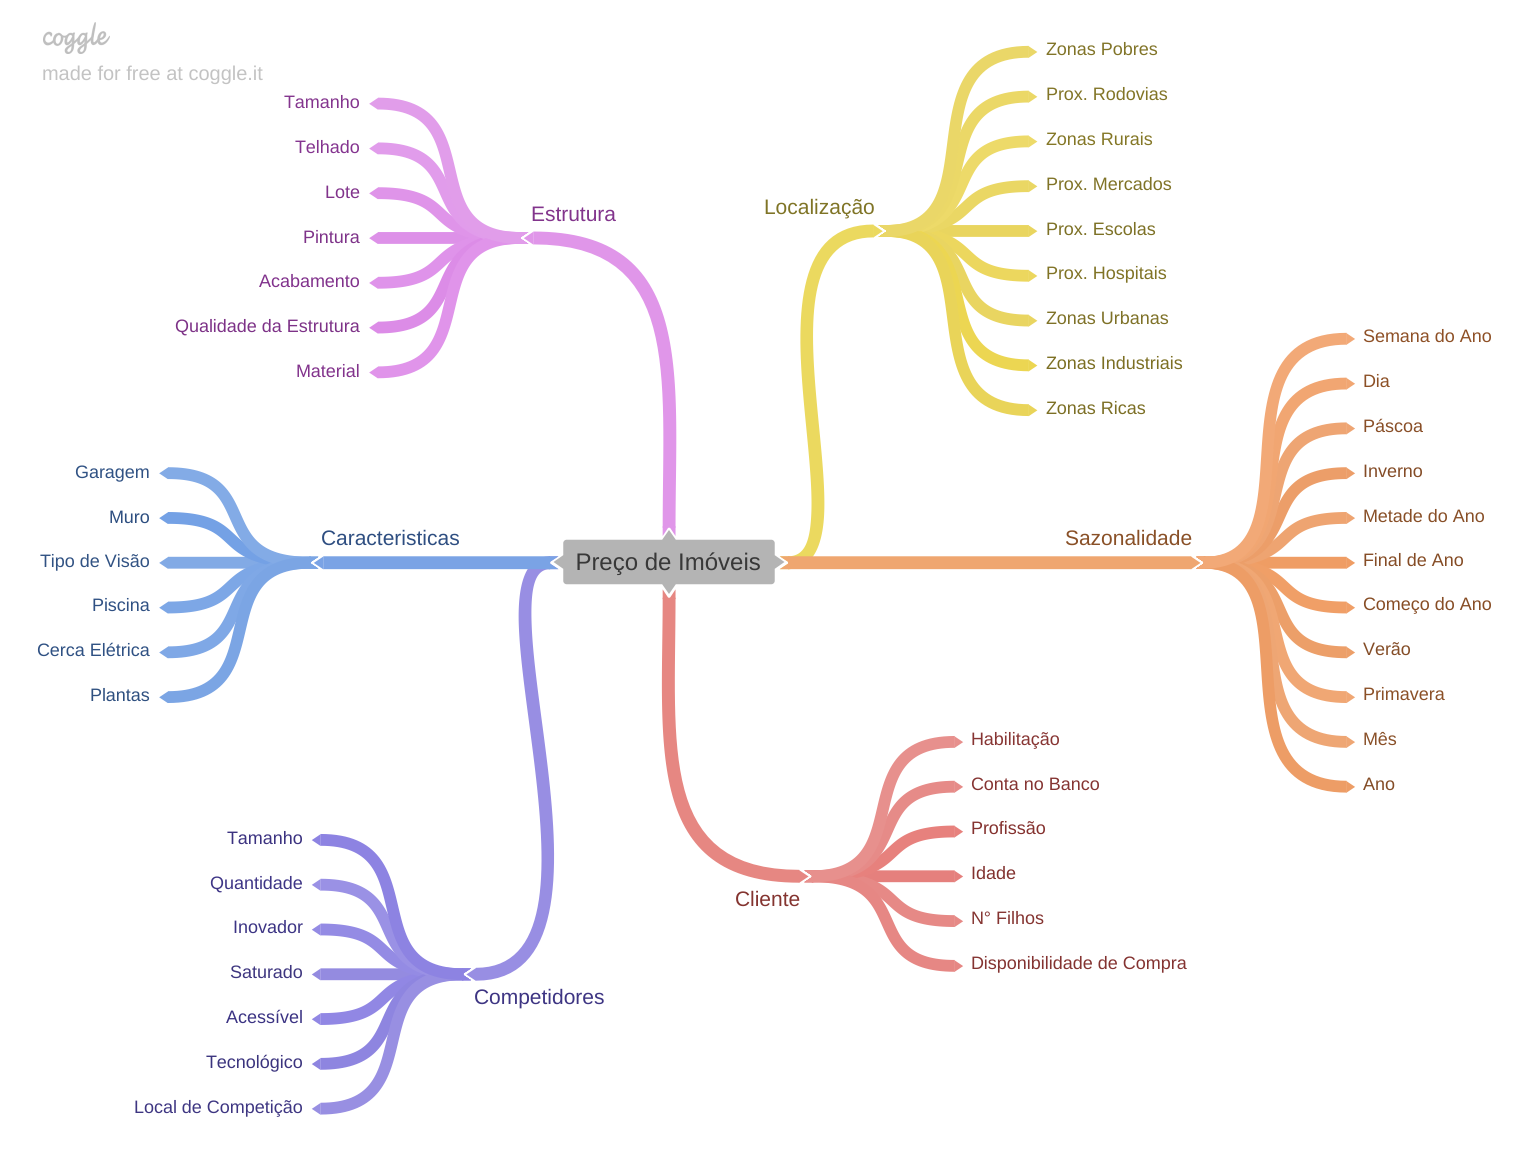

In [86]:
Image('../img/mind.png')

## 2.2. Hypothesis List

**1.** Imóveis com maior lote possuem o preço maior.

**2.** 30% do faturamento vem de casas com o m2 lote maior que 10000.

**3.** Casas vendidas durante o feriado natalino geram mais lucro que em feriados da páscoa.

**4.** Casas com piscina e fogueira são 10% mais caras que casas com apenas piscina.

**5.** Casas na vizinhaça de timberland possuem a média de preço mais alta que nas demais vizinhanças.

**6.** Casas com maior qualidade representam mais de 20% das vendas.

**7.** Casas com elevador representam 70% do faturamente da categoria extras.

**8.** As vendas de imóveis creçem a cada ano

## 2.3. Feature Engineering

Second Cycle Features

**1. christmans** Check if property has selled on Christmans.

**2. easter** Check if property has selled on Easter.

**3. total_sqft** Total Living Area + Total Basement Area.

**4. total_garage_size** //

**5. total_size_porch** Sum of all porchs to get a total porch.

**6. garage_per_car** Garage Size multt total of cars.

**7. total_bath** Sum of all baths on the house.

**8. total_abv_grade** Sum of all "above grade".

**9. floors_sqft** Sum of all sqft floors.


In [173]:
df1['christmans'] = df1['mo_sold'].apply( lambda x: 1 if x == 12 else 0 )
df1['easter']     = df1['mo_sold'].apply( lambda x: 1 if x == 4 else 0 )
df1['total_sqft']        = df1.total_bsmt_sf + df1.gr_liv_area
#df1['total_garage_size'] = df1.garage_cars   + df1.garage_area
df1['total_size_porch']  = df1.wood_deck_sf  + df1.open_porch_sf + df1.enclosed_porch + df1['3_ssn_porch'] + df1.screen_porch
df1['garage_multy_car']    = df1.garage_area   * df1.garage_cars
df1['total_bath']        = df1.bsmt_full_bath  + df1.full_bath + df1.bsmt_half_bath + df1.half_bath
df1['total_abv_grade']   = df1.tot_rms_abv_grd + df1.kitchen_abv_gr + df1.bedroom_abv_gr 
df1['floors_sqft']       = df1.low_qual_fin_sf + df1['2nd_flr_sf'] + df1['1st_flr_sf'] + df1.total_bsmt_sf

# 3.0. Data Filtering

In [174]:
df1

ms_sub_class ms_zoning  lot_frontage  lot_area street     alley  \
0               60        RL          65.0      8450   Pave  DontHave   
1               20        RL          80.0      9600   Pave  DontHave   
2               60        RL          68.0     11250   Pave  DontHave   
3               70        RL          60.0      9550   Pave  DontHave   
4               60        RL          84.0     14260   Pave  DontHave   
...            ...       ...           ...       ...    ...       ...   
1455            60        RL          62.0      7917   Pave  DontHave   
1456            20        RL          85.0     13175   Pave  DontHave   
1457            70        RL          66.0      9042   Pave  DontHave   
1458            20        RL          68.0      9717   Pave  DontHave   
1459            20        RL          75.0      9937   Pave  DontHave   

     lot_shape land_contour utilities lot_config  ... sale_condition  \
0          Reg          Lvl    AllPub     Inside  ...         Normal   
1          Reg          Lvl    AllPub        FR2  ...         Normal   
2          IR1          Lvl    AllPub     Inside  ...         Normal   
3          IR1          Lvl    AllPub     Corner  ...        Abnorml   
4          IR1          Lvl    AllPub        FR2  ...         Normal   
...        ...          ...       ...        ...  ...            ...   
1455       Reg          Lvl    AllPub     Inside  ...         Normal   
1456       Reg          Lvl    AllPub     Inside  ...         Normal   
1457       Reg          Lvl    AllPub     Inside  ...         Normal   
1458       Reg          Lvl    AllPub     Inside  ...         Normal   
1459       Reg          Lvl    AllPub     Inside  ...         Normal   

     sale_price christmans easter total_sqft total_size_porch  \
0        208500          0      0       2566               61   
1        181500          0      0       2524              298   
2        223500          0      0       2706               42   
3        140000          0      0       2473              307   
4        250000          1      0       3343              276   
...         ...        ...    ...        ...              ...   
1455     175000          0      0       2600               40   
1456     210000          0      0       3615              349   
1457     266500          0      0       3492               60   
1458     142125          0      1       2156              478   
1459     147500          0      0       2512              804   

      garage_multy_car  total_bath  total_abv_grade  floors_sqft  
0                 1096           4               12         2566  
1                  920           3               10         2524  
2                 1216           4               10         2706  
3                 1926           2               11         2473  
4                 2508           4               14         3343  
...                ...         ...              ...          ...  
1455               920           3               11         2600  
1456              1000           3               11         3615  
1457               252           2               14         3492  
1458               240           2                8         2156  
1459               276           3               10         2512  

[1460 rows x 88 columns]

## 3.1. Filtering Rows

In [175]:
len(df1[df1.garage_yr_blt == 0])

81

In [176]:
# Vies Input of 1900
df1.loc[df1['garage_yr_blt'] == 0, 'garage_yr_blt'] = 1900

## 3.2. Filtering Columns

1. Utilities, in Dataset is 99.9% ( AllPub All public Utilities (E,G,W,& S) ), with One Row with ( NoSeWa Electricity and Gas Only ).
2. Street, in Dataset, only 6 Rows have Street equal to Gravel, other 1454 are Pavimentation.

In [177]:
df1 = df1.drop( columns=['street', 'utilities'], axis=1 )

# 4.0. Exploratory Data Analysis

In [178]:
df1.to_csv('../data_backup/df1.csv')
#df2 = df1.copy()
df2 = pd.read_csv('../data_backup/df1.csv')
df2 = df2.drop( columns=['Unnamed: 0'], axis=1 )

## 4.1. Univariable Analysis

### 4.1.1. Response Variable

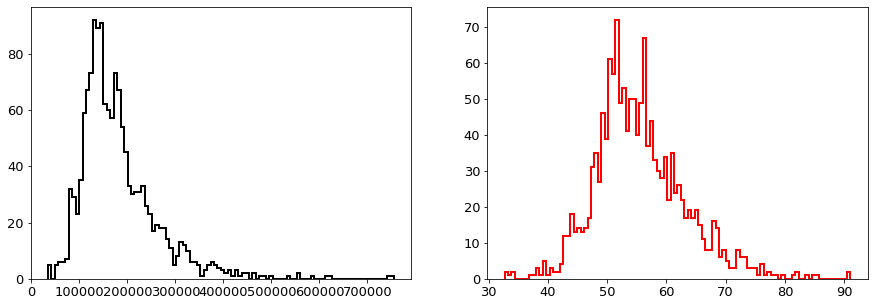

In [110]:
plot_targ_cube( df2, 'sale_price' )

### 4.1.2. Numerical Variable

<Figure size 1800x1296 with 0 Axes>

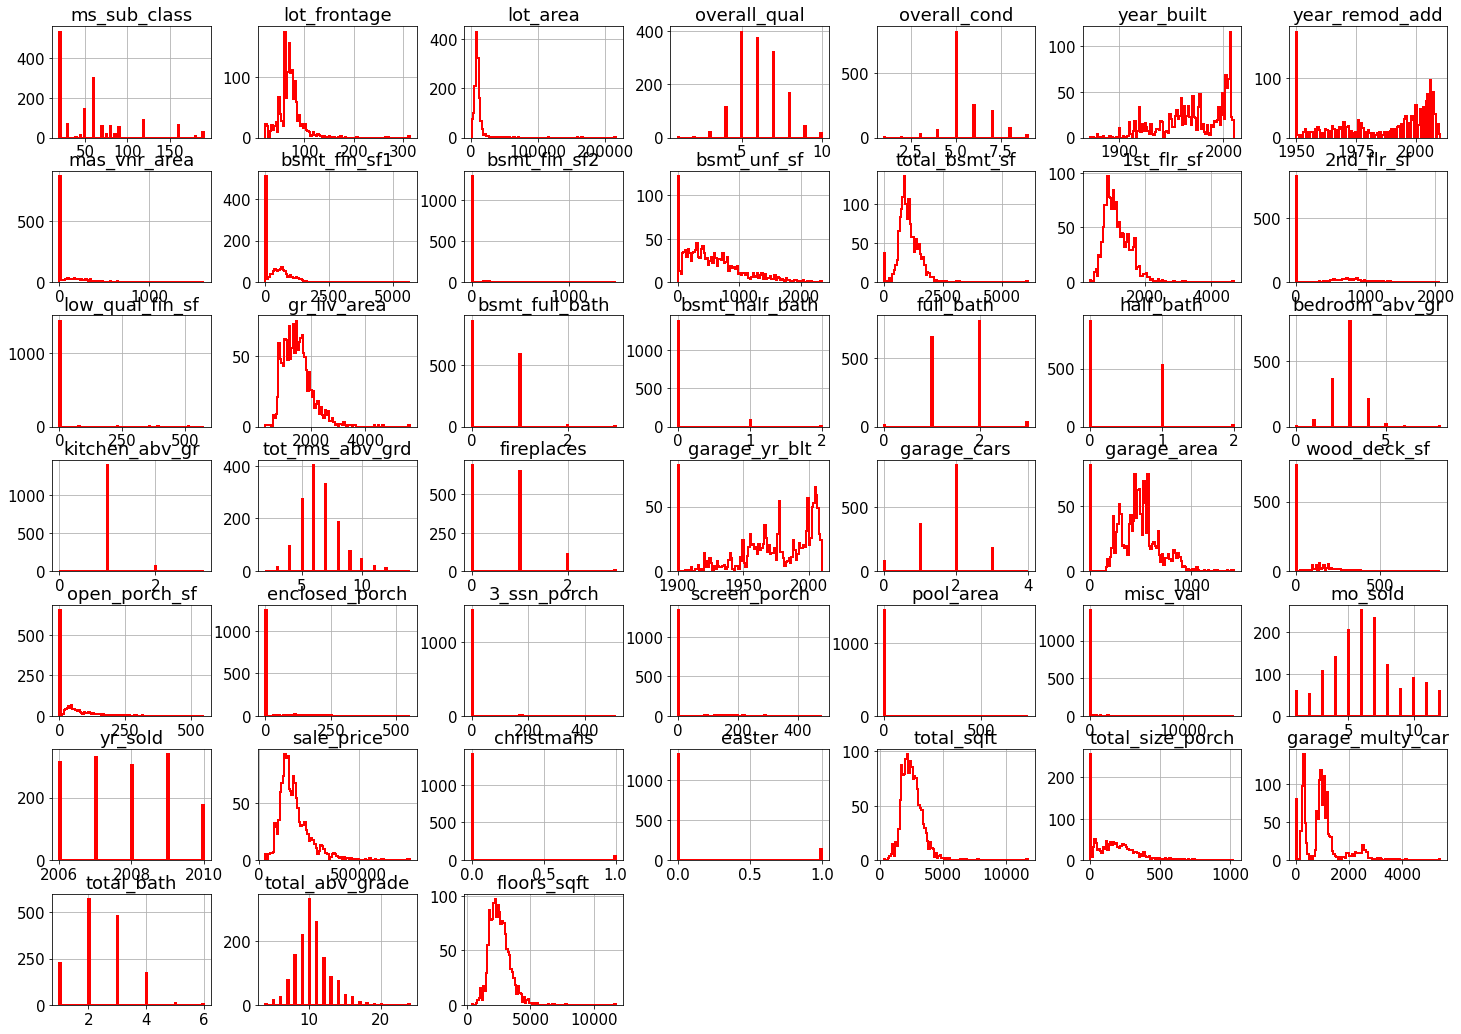

In [179]:
plt.rcParams['figure.figsize'] = [25, 18]
plt.tight_layout(w_pad=2., h_pad=5.)
n, c = metrics( df2, False )
n.hist( **args( bins=100 ) );

### 4.1.3. Categorical Data

In [160]:
#c.columns.tolist()
c['sale_price'] = df2['sale_price']

In [161]:
simple_columns = []
large_columns  = []
for i in c.columns[:-1]:
    if len(c[i].unique()) >= 5:
        large_columns.append( i )
    else:
        simple_columns.append( i )

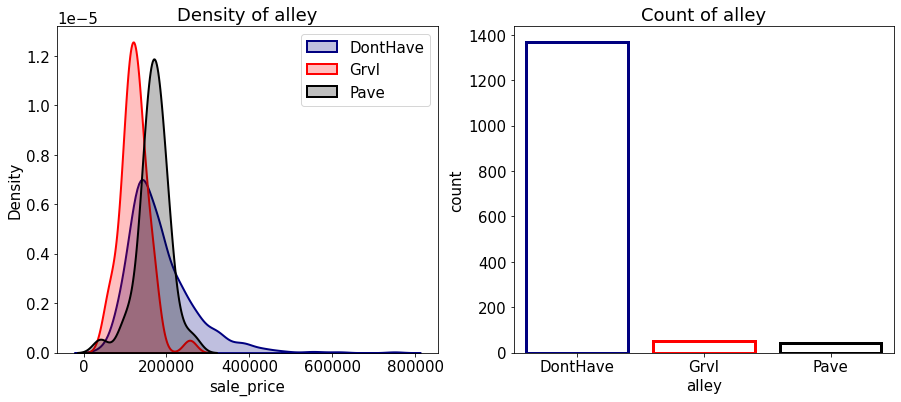

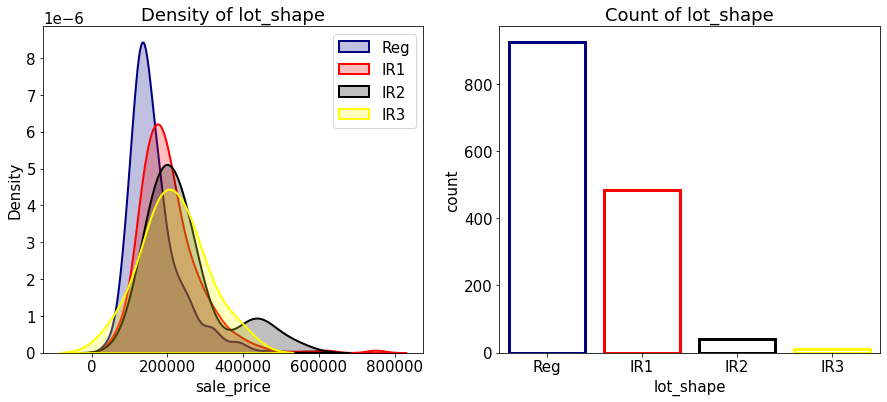

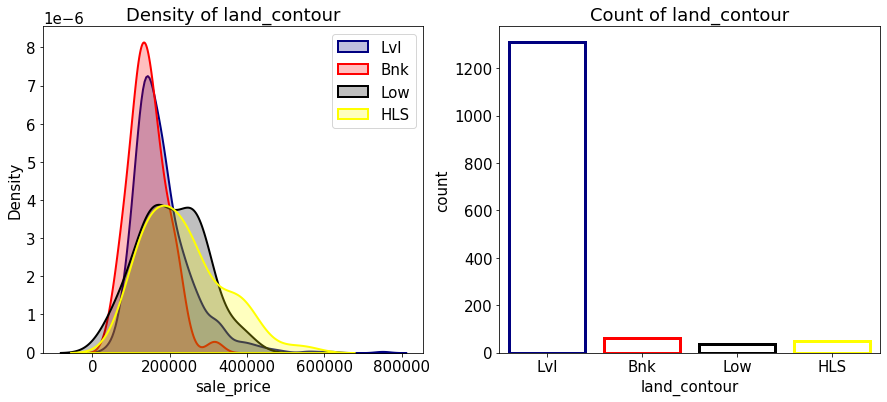

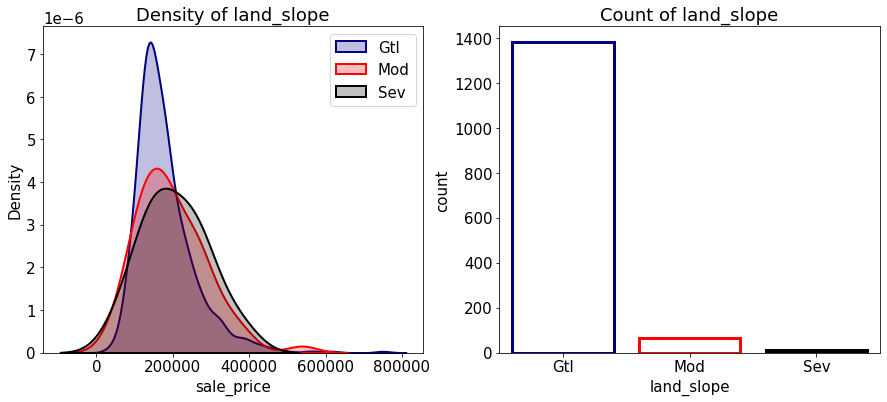

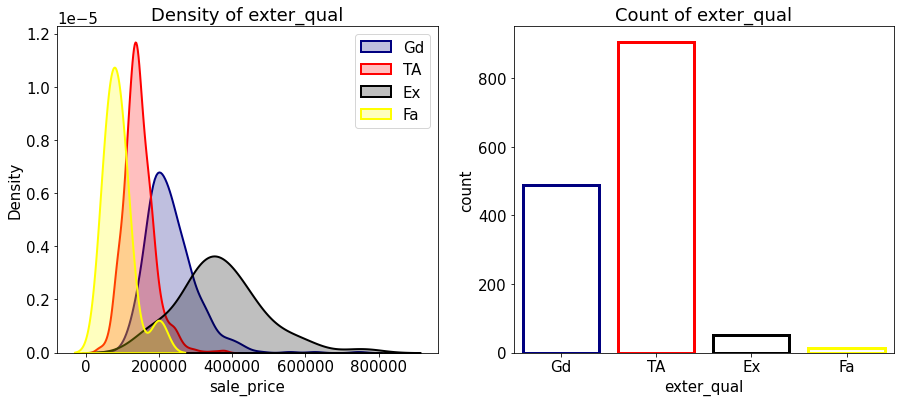

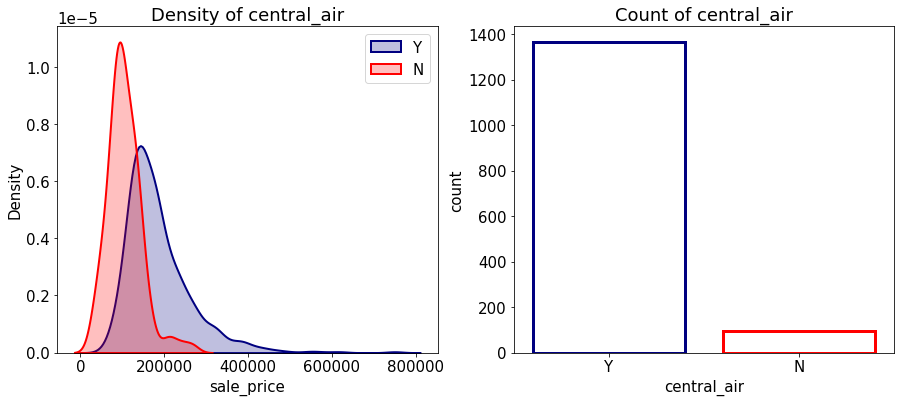

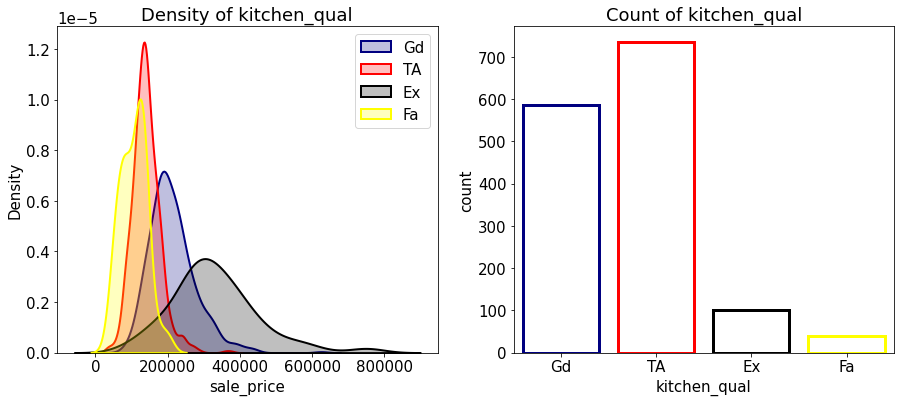

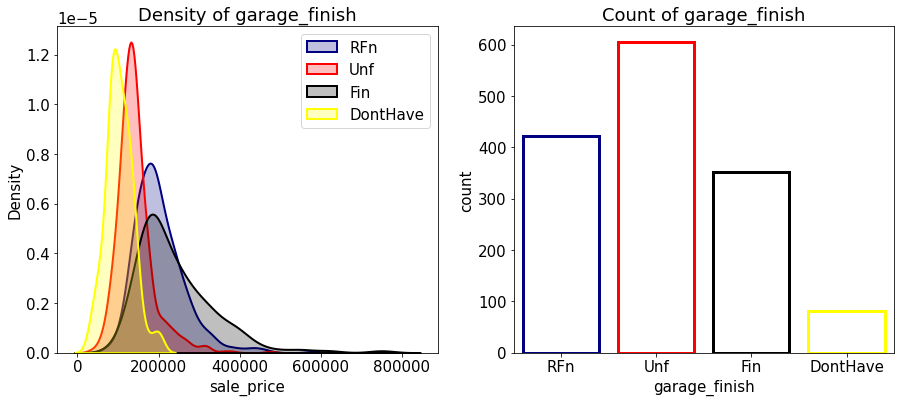

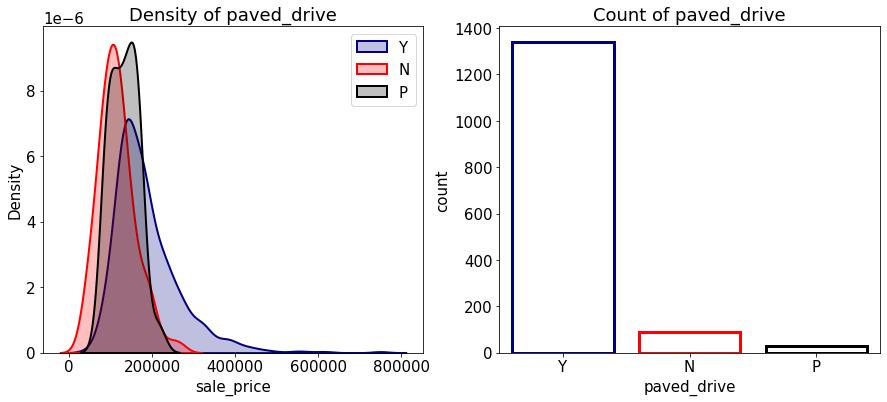

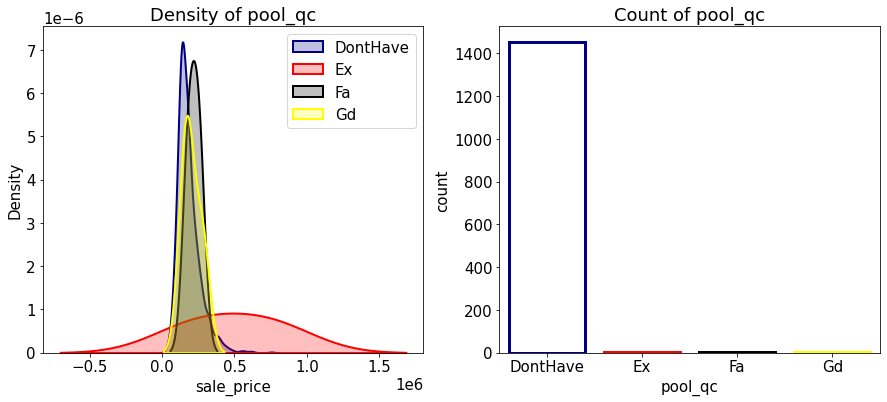

In [162]:
plot_simple_columns( simple_columns )

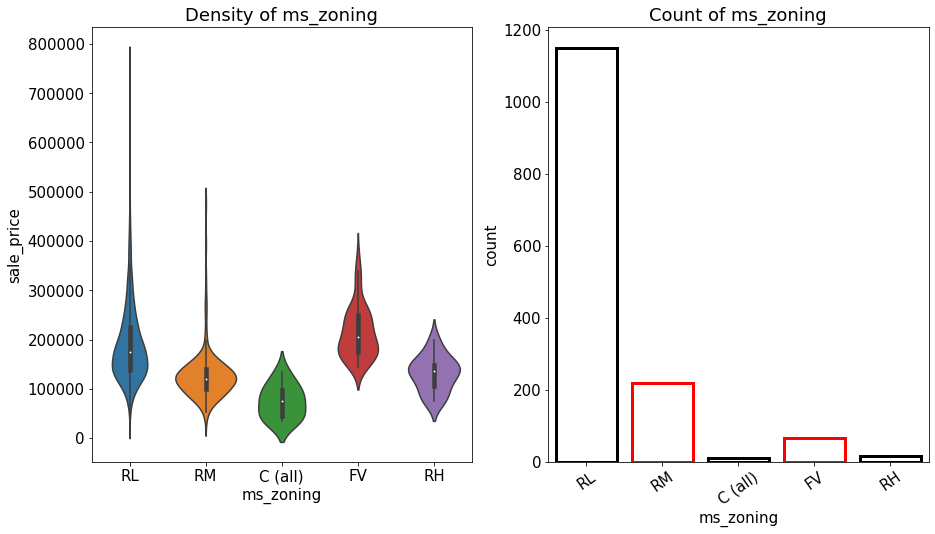

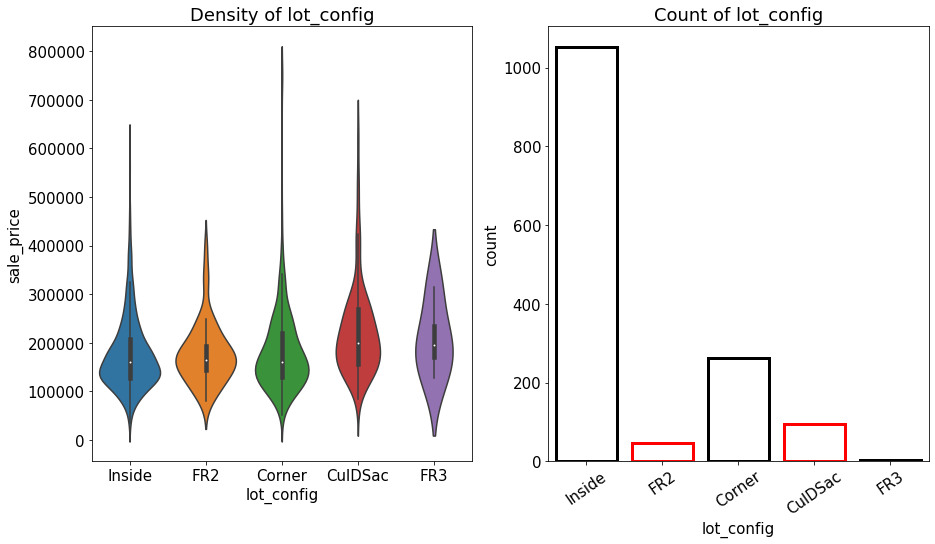

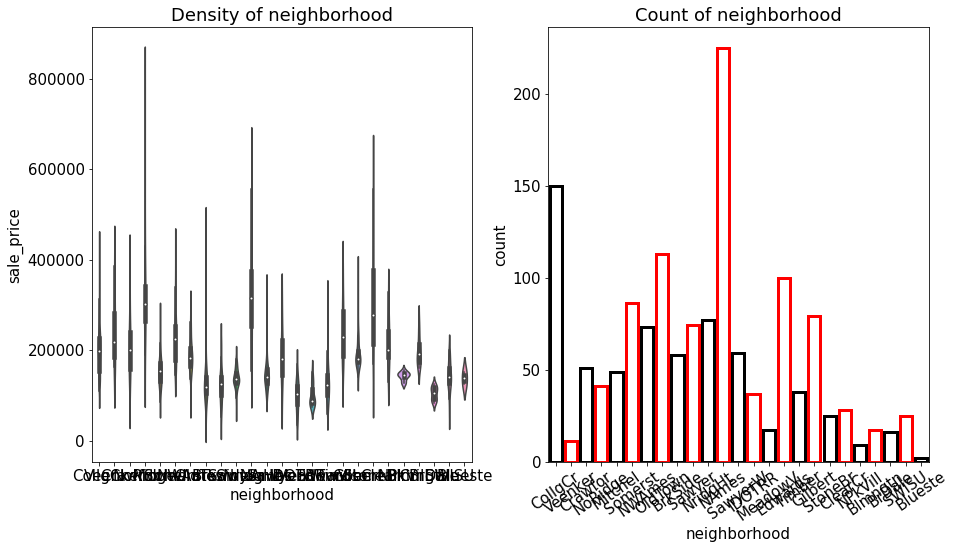

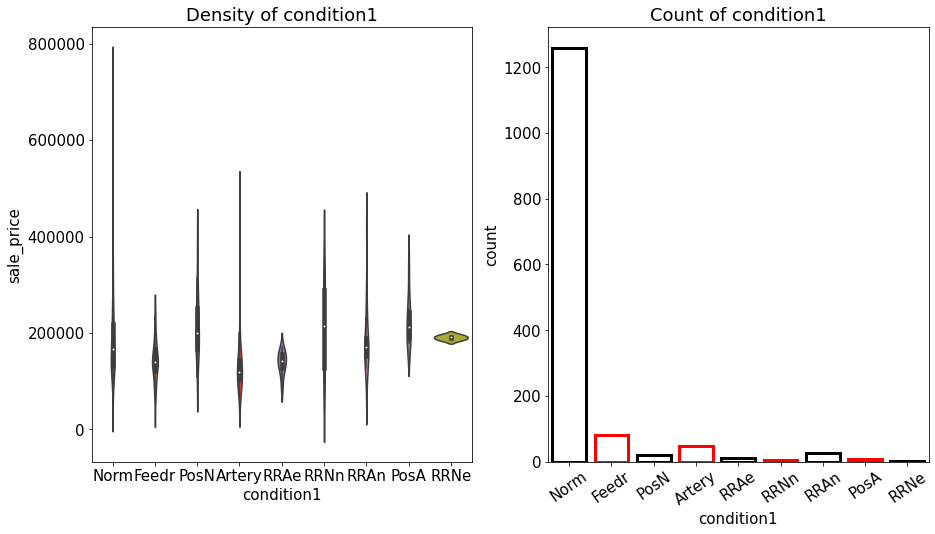

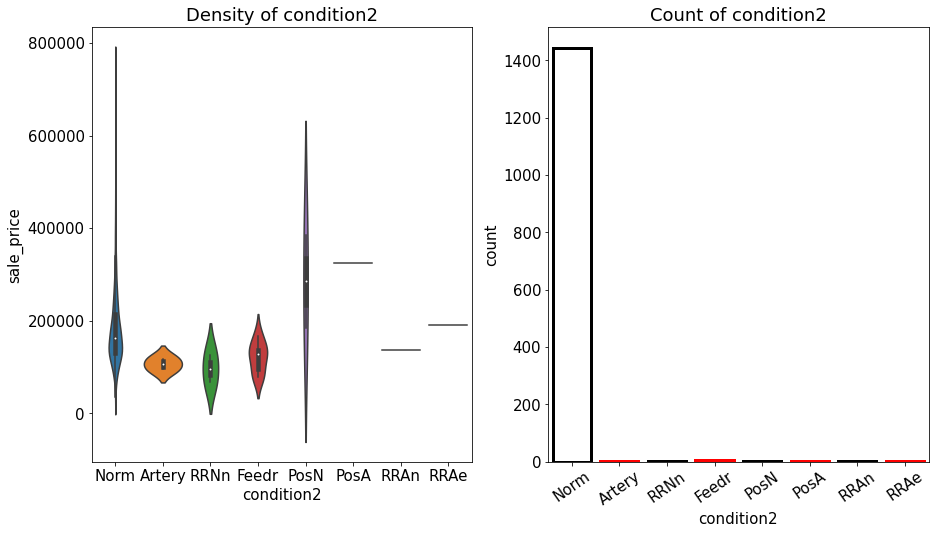

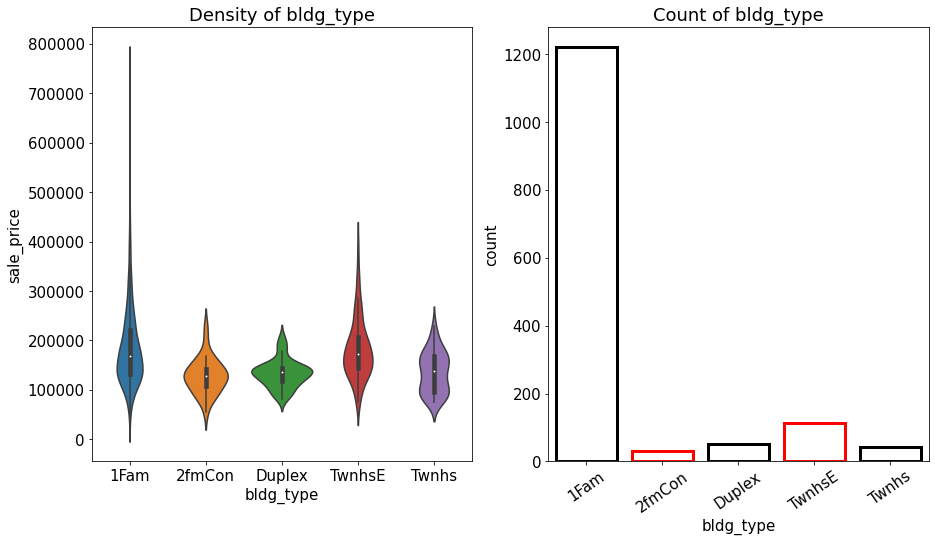

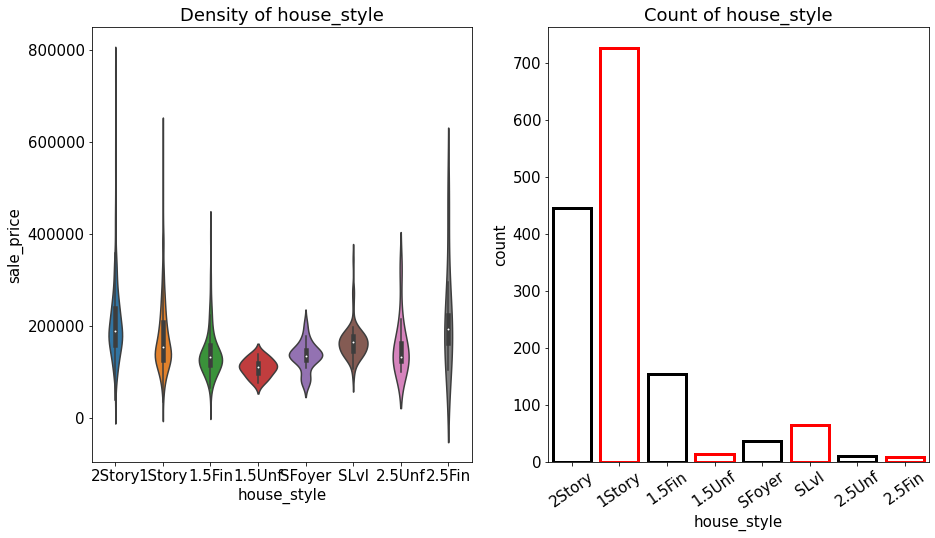

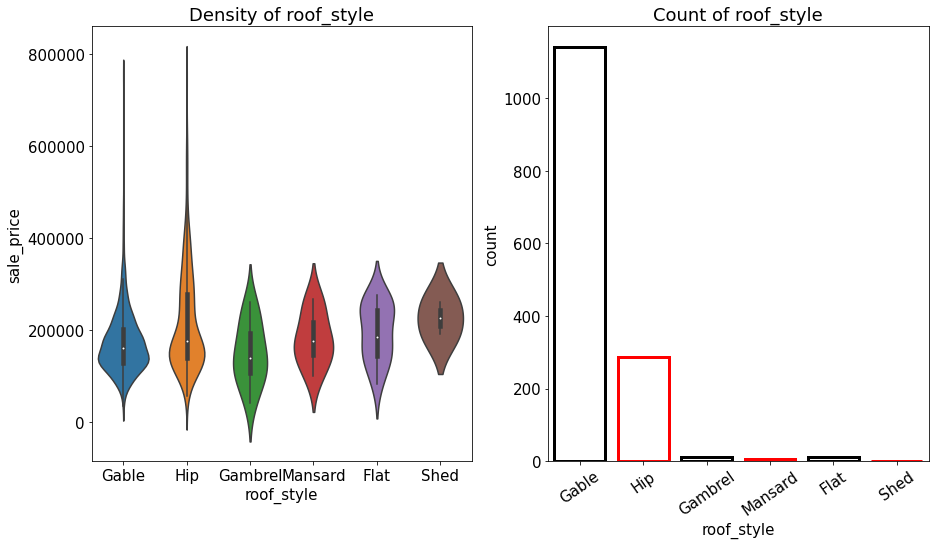

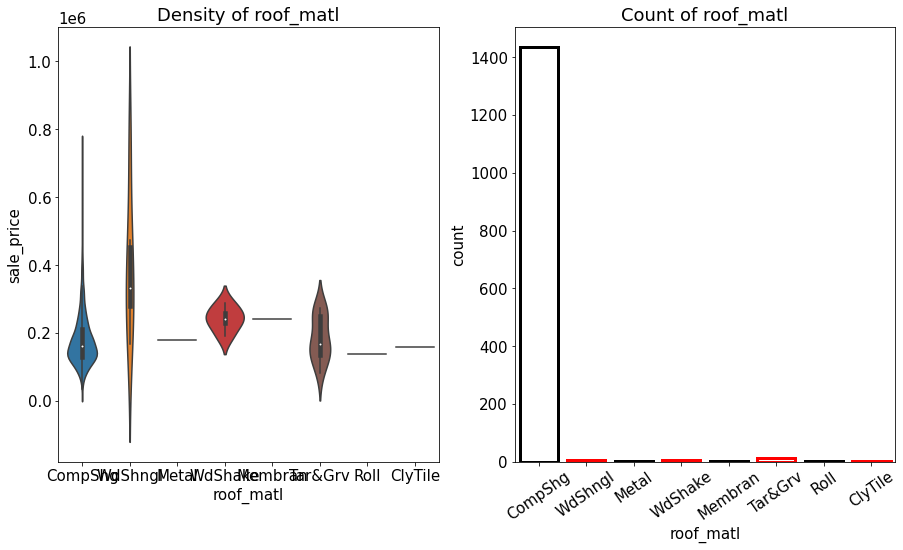

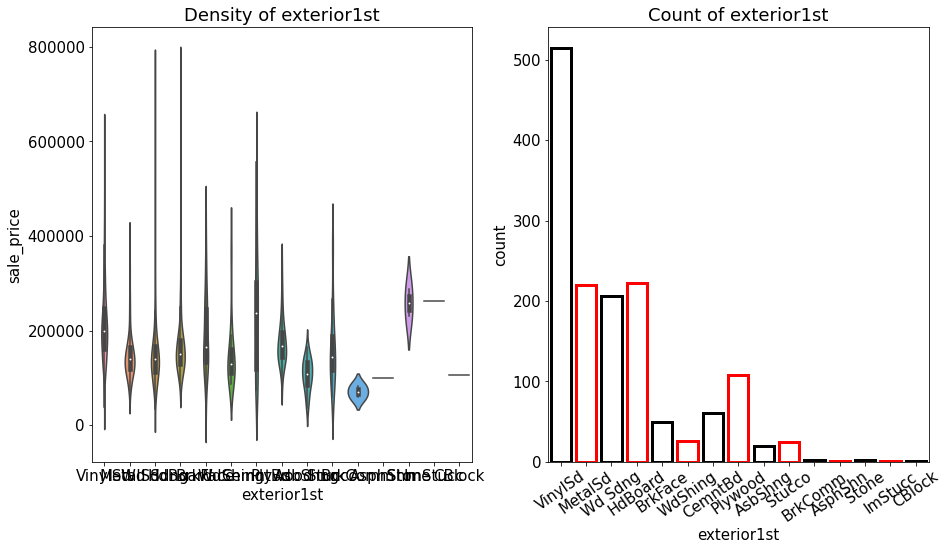

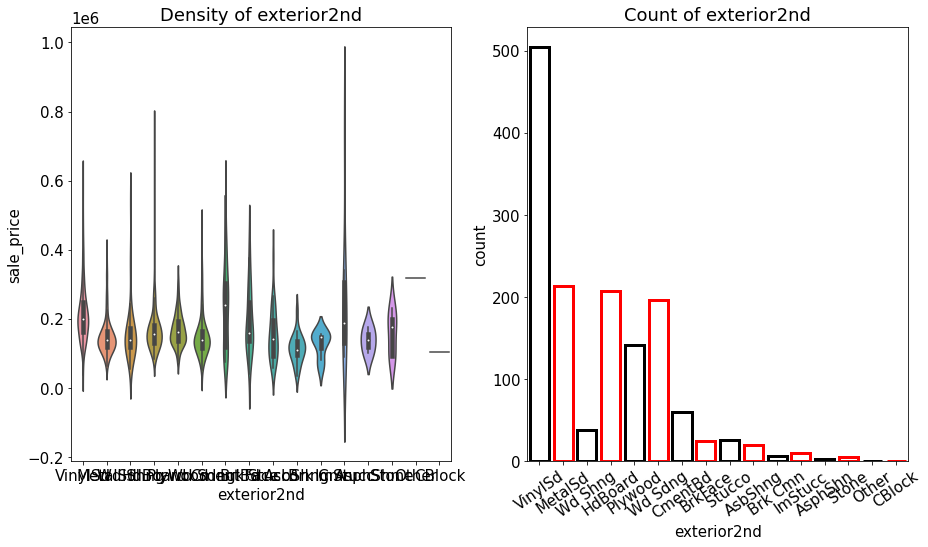

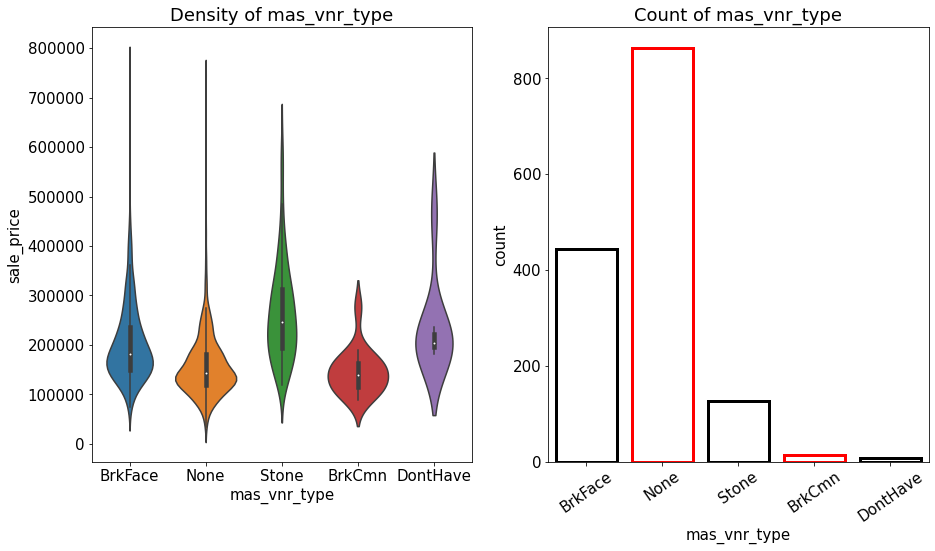

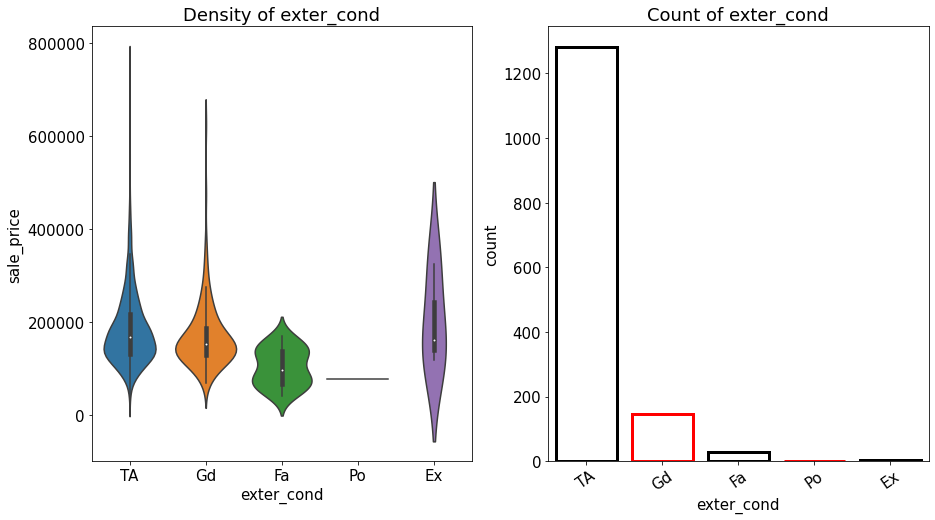

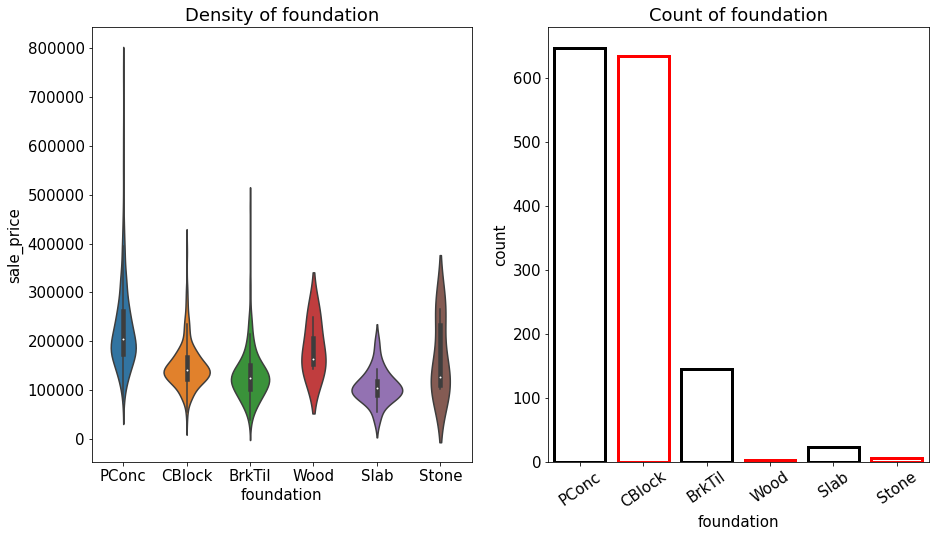

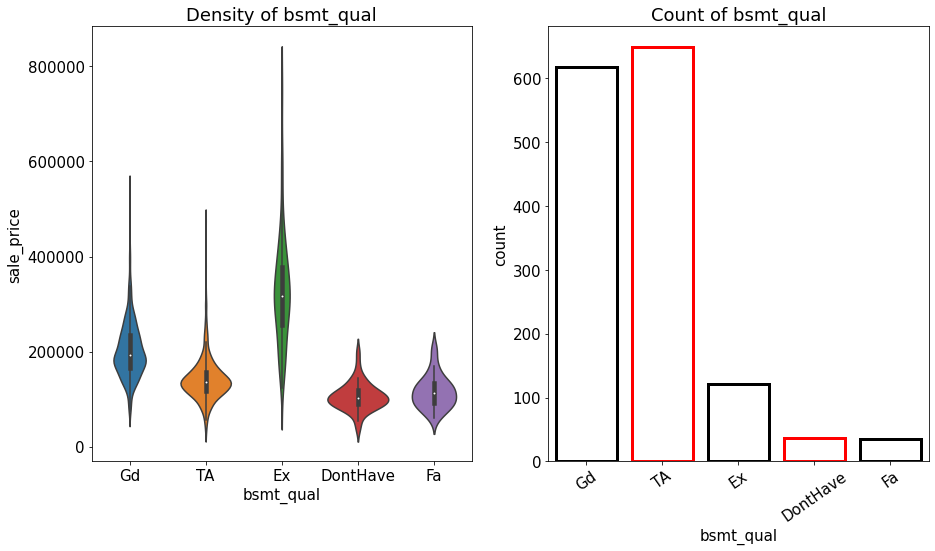

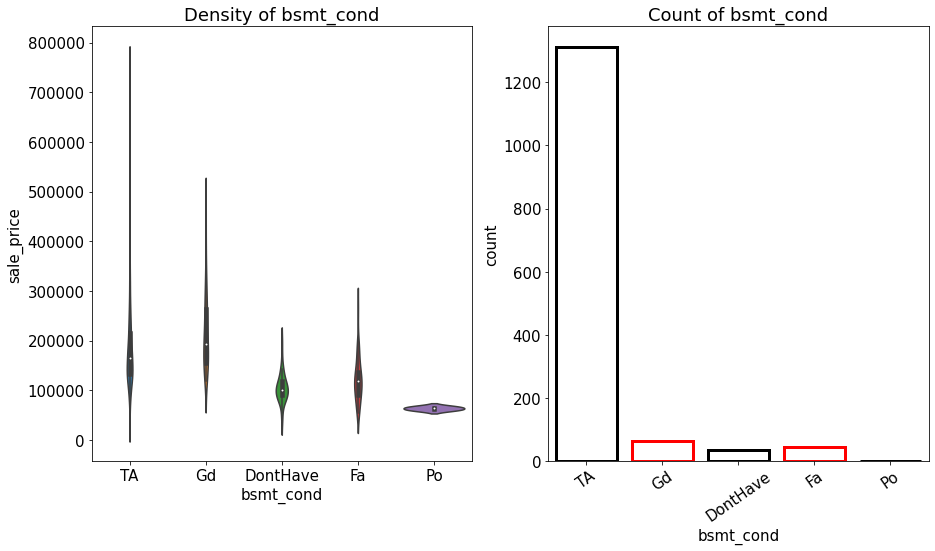

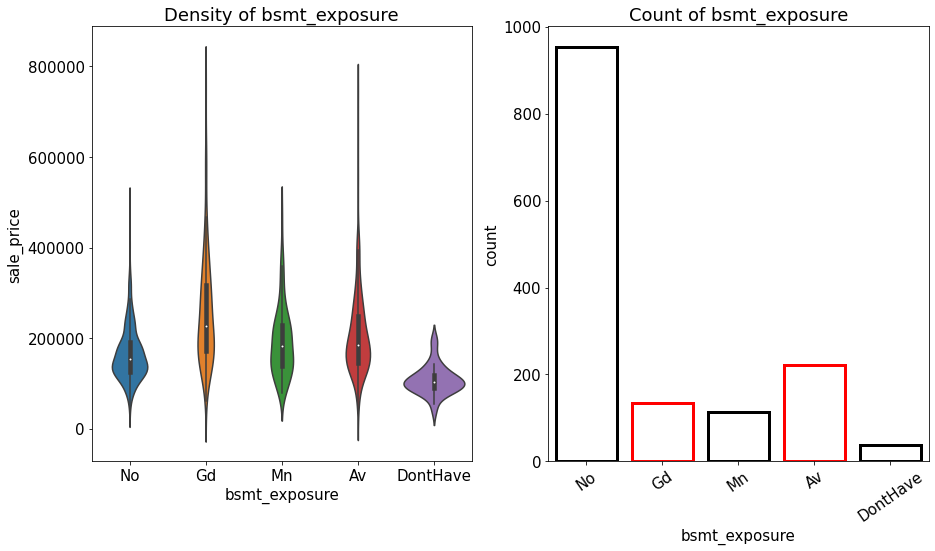

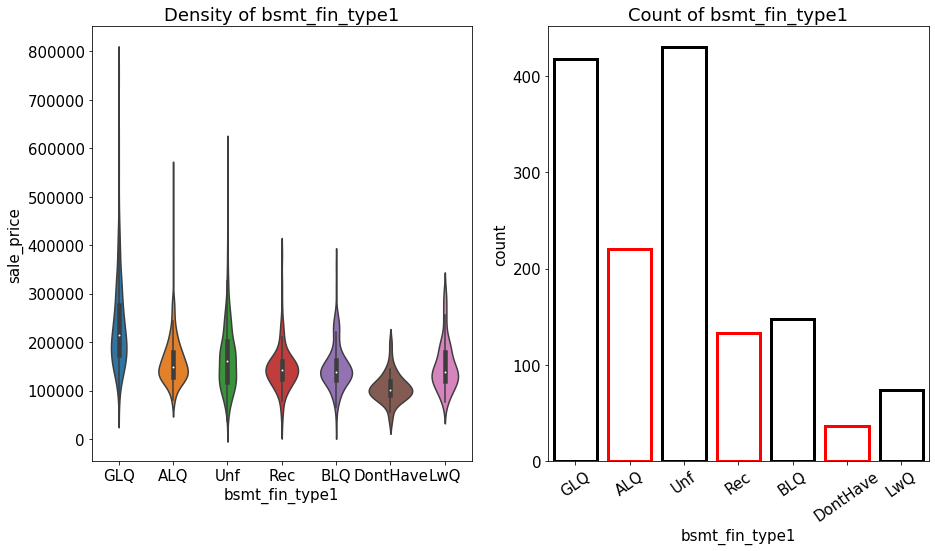

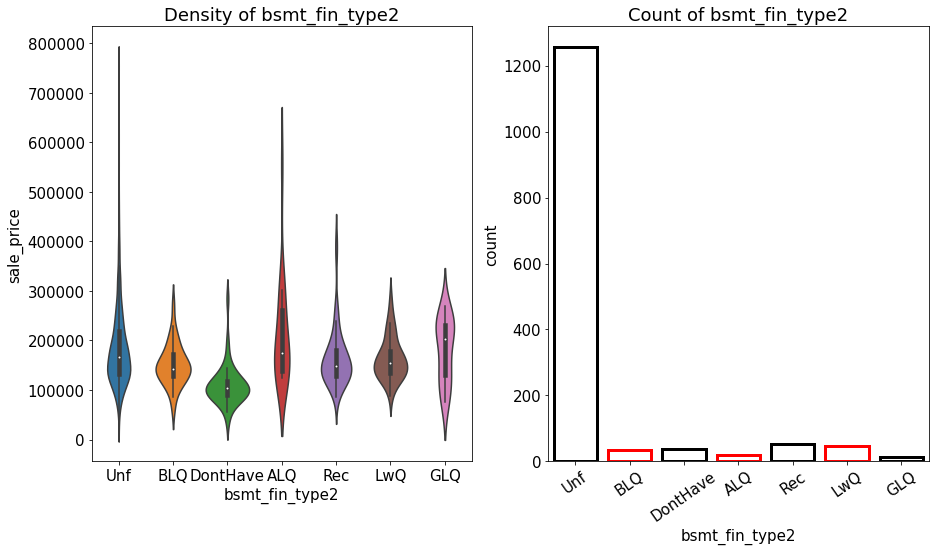

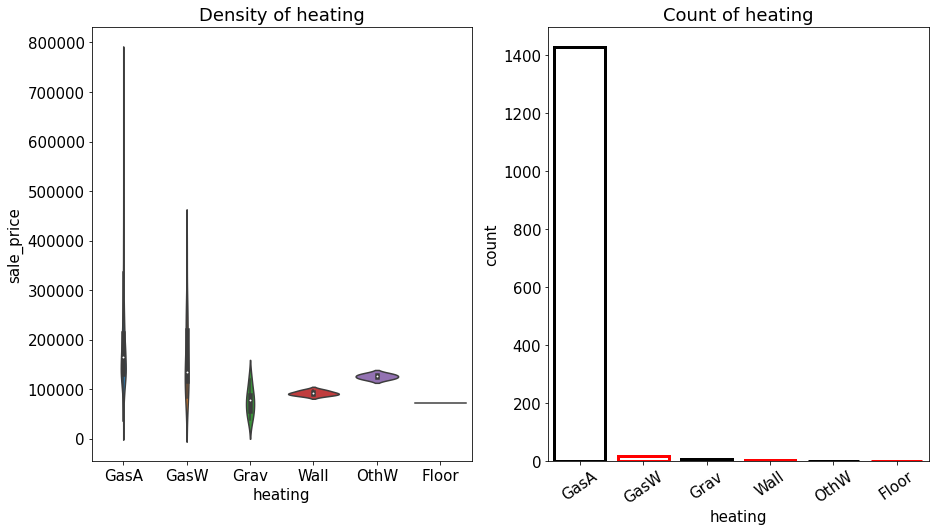

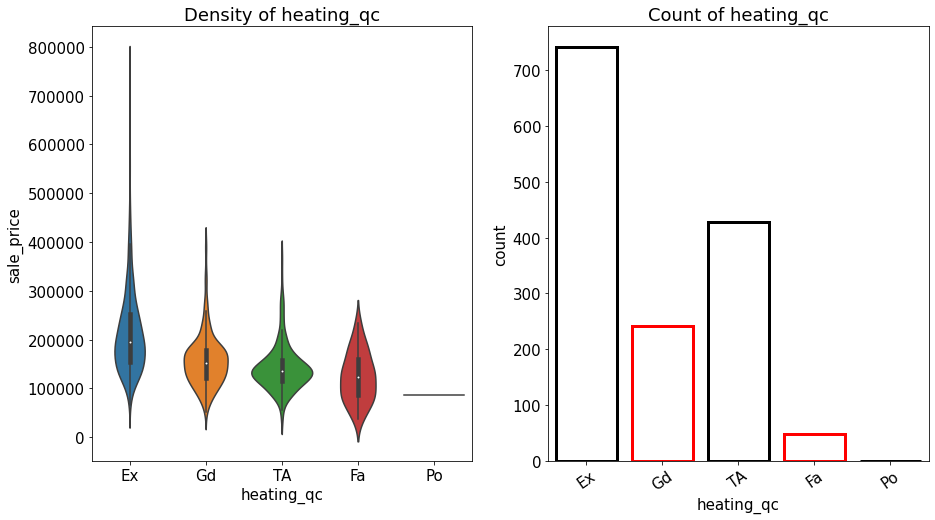

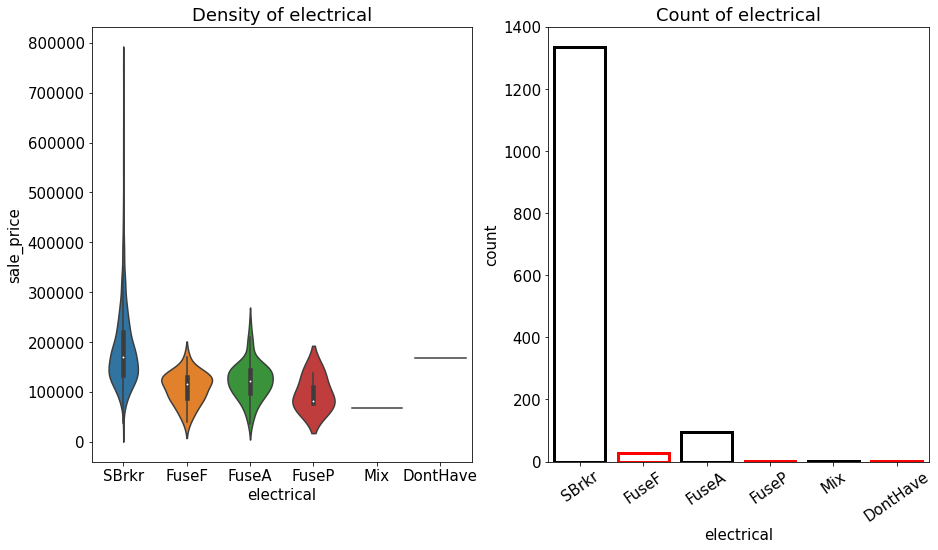

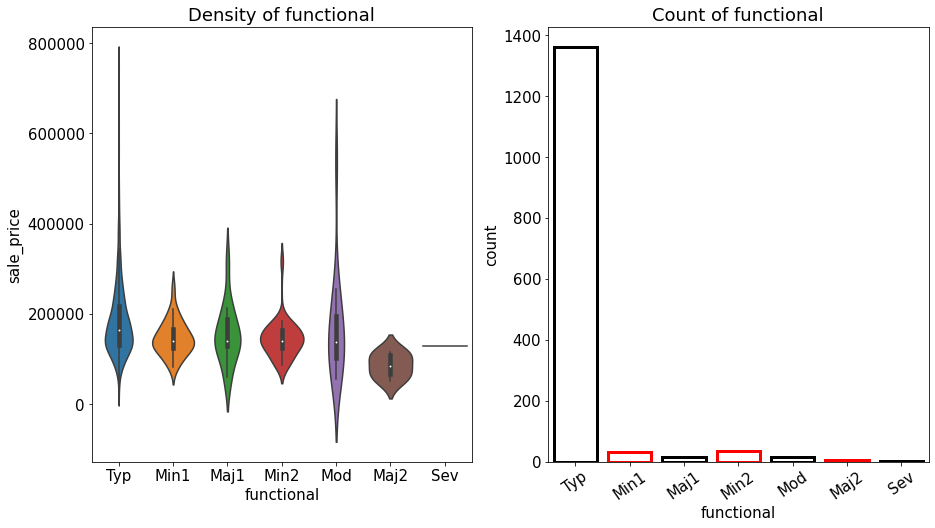

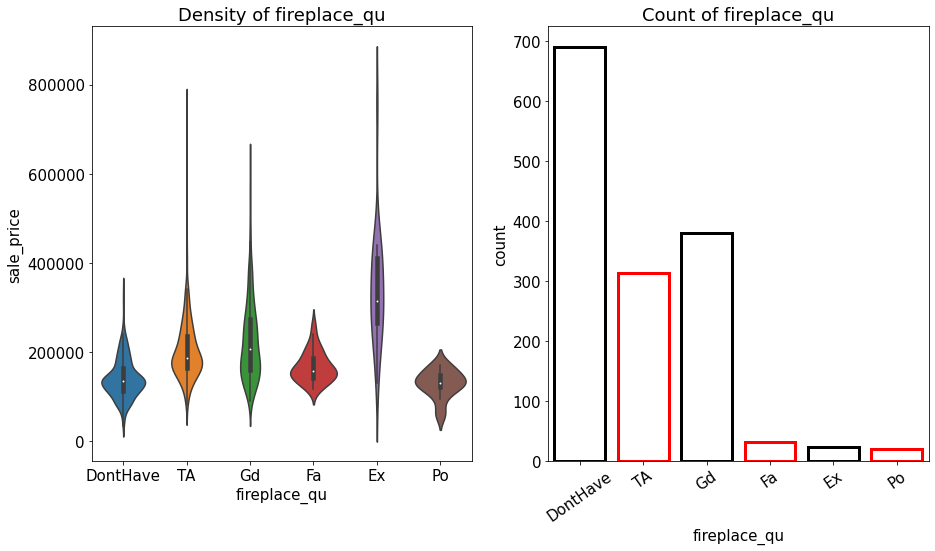

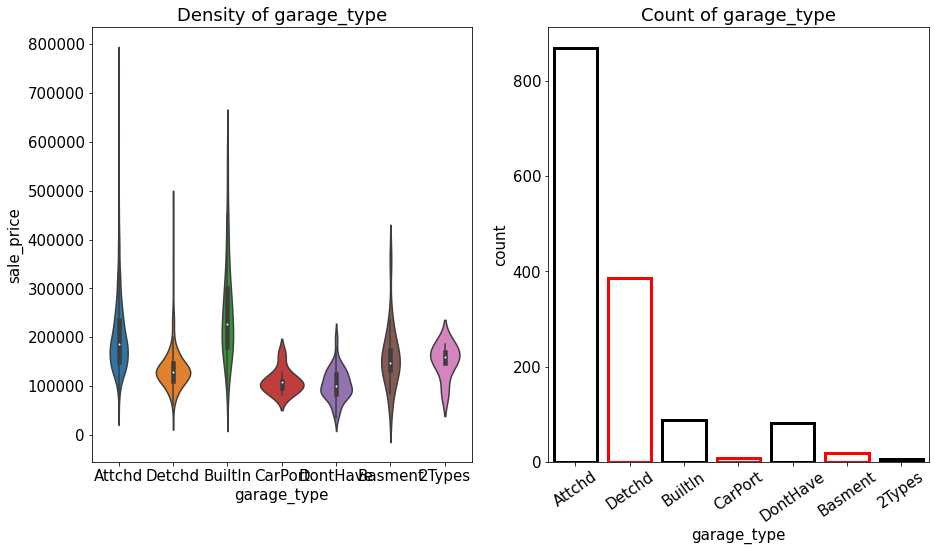

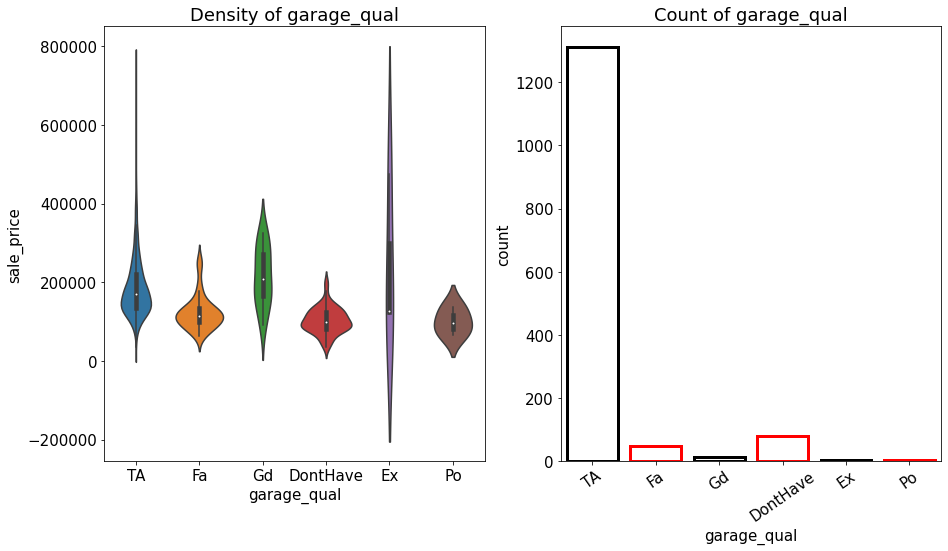

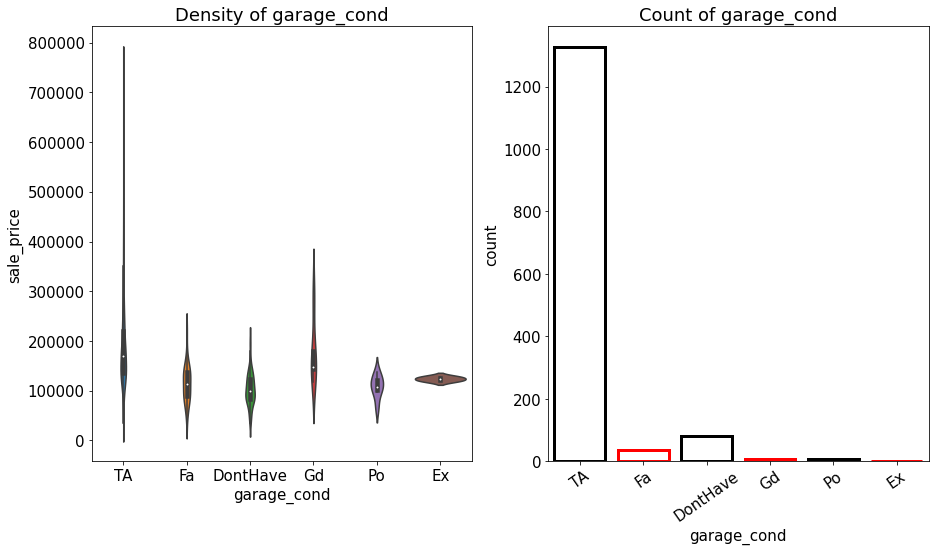

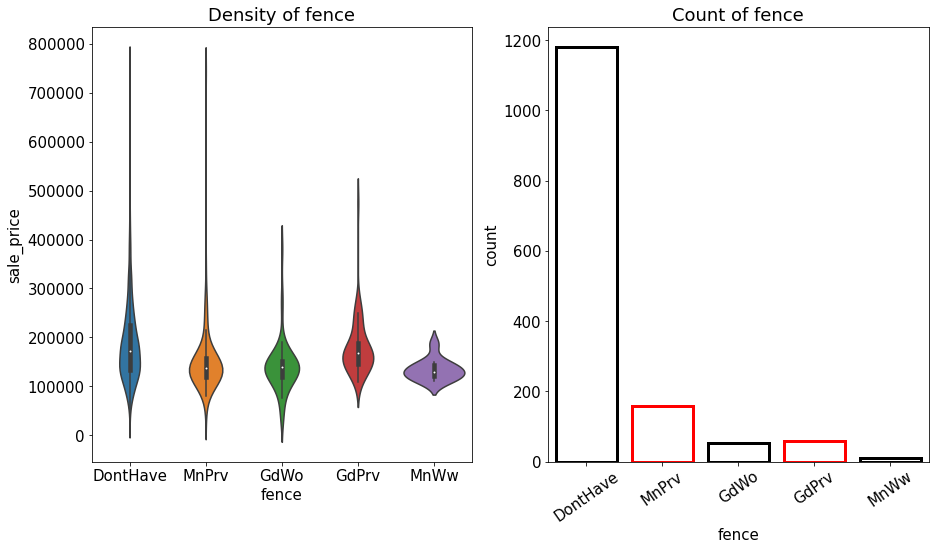

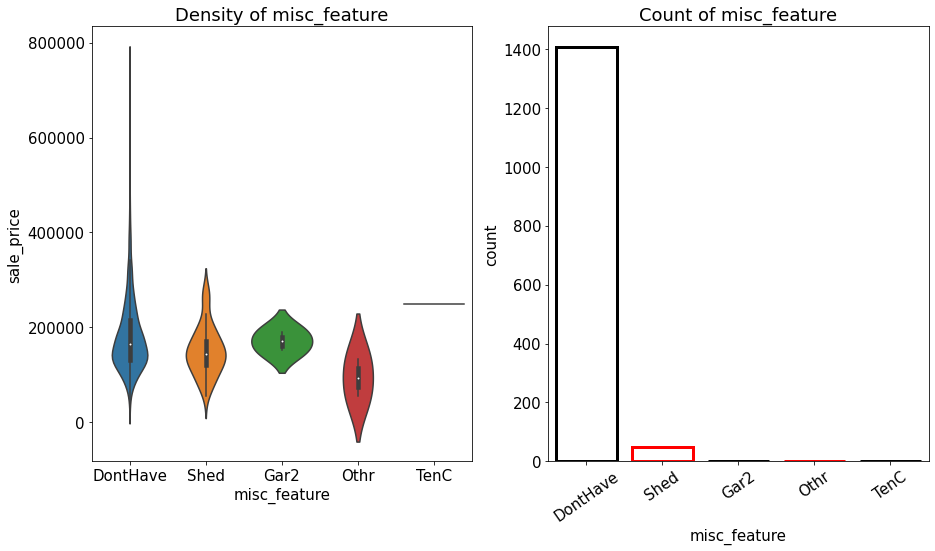

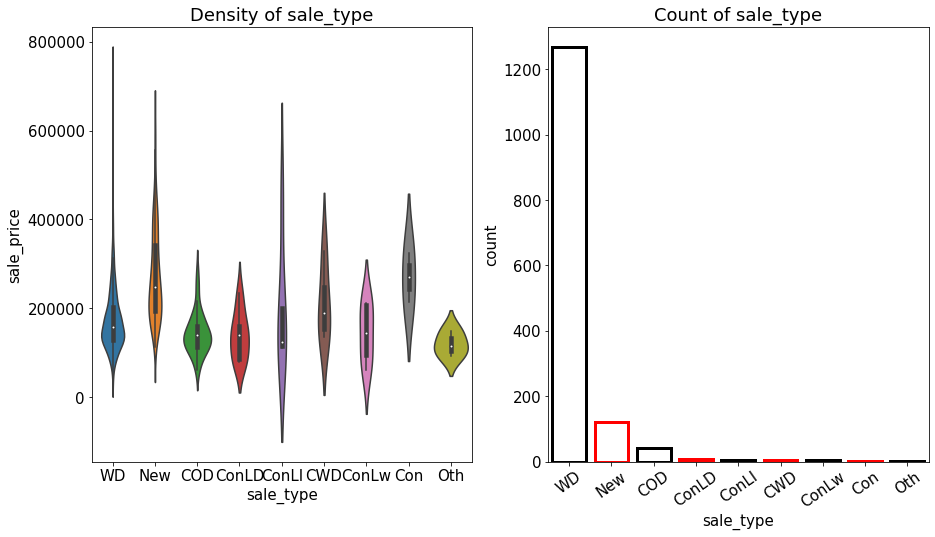

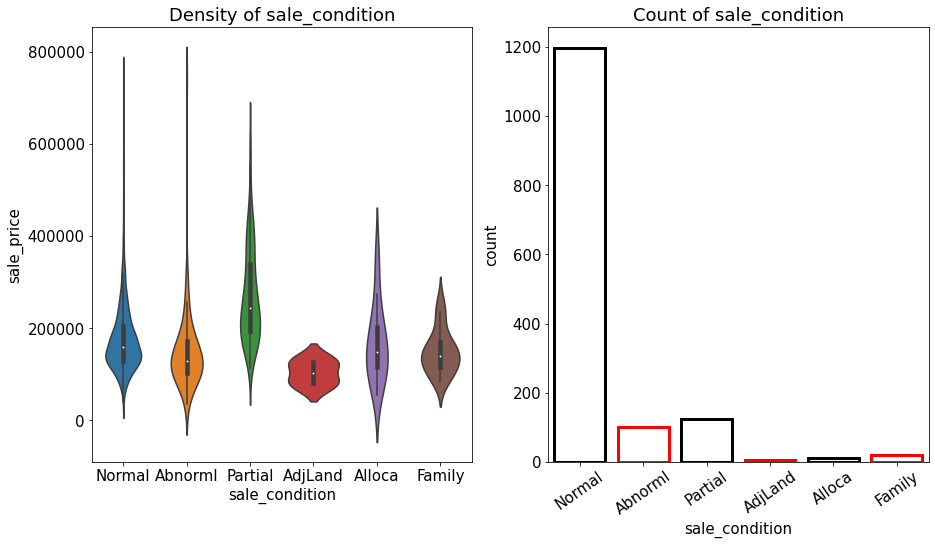

In [163]:
for i in large_columns:
    fig, ax = plt.subplots( 1, 2, figsize=(15, 8))
    sns.violinplot( c[i], c['sale_price'], ax=ax[0] )
    sns.countplot( c[i], color=(1, 1, 1, 0), linewidth=3, edgecolor=['k', 'r'] );
    ax[0].set_title(f'Density of {i}')
    ax[1].set_title(f'Count of {i}')
    plt.xticks( rotation=35 )

**Important Variables**<br>
'alley',
'lot_shape',
'exter_qual',
'kitchen_qual',
'garage_finish',
'pool_qc',
'neighbourhood',
'condition1',
'condition2',
'house_style',
'roof_style',
'roof_mati',
'exterior1st',
'exterior2nd',
'mas_vnr_type',
'bsmt_qual',
'bsmt_fin_type1',
'fireplace_qu',
'garage_type',
'sale_cond',
'sale_type',

## 4.2. Bivariated Analysis

### **1.** Imóveis com maior lote possuem o preço maior.
Dado os dados, idependentemento do tamanho do terreno vende parecido, sendo muito mais inflenciado por outras variaveis **Falso**

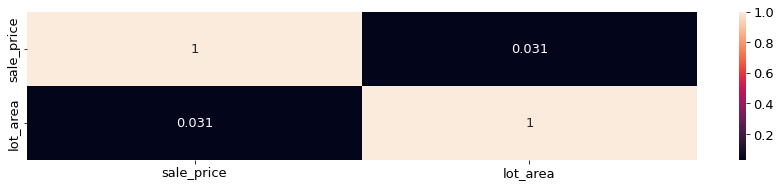

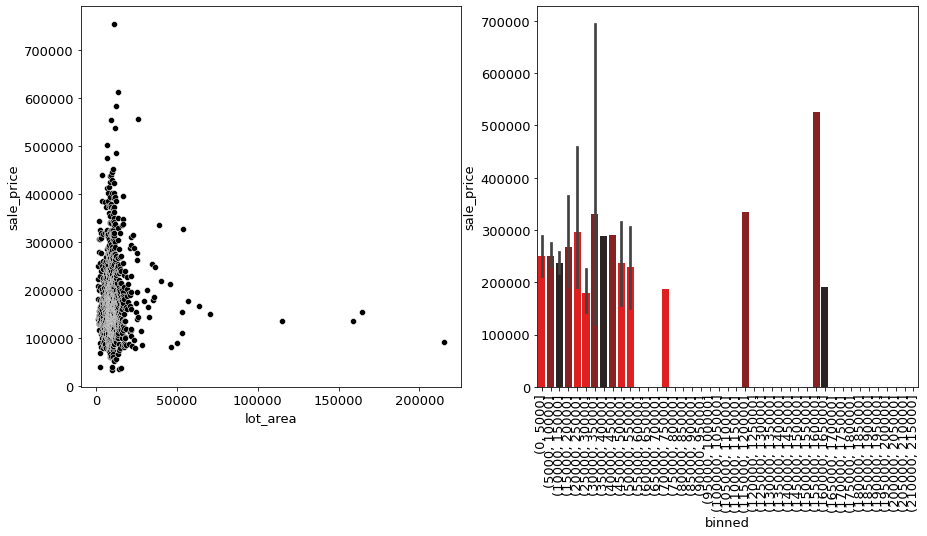

In [135]:
dfa = df2[['sale_price', 'lot_area']].groupby( 'lot_area' ).sum().reset_index()
dfa['binned'] = pd.cut( df2['lot_area'], bins=np.arange( 0, 215245, 5000 ) )

plt.subplot( 2, 1, 1 )
sns.heatmap( dfa[['sale_price', 'lot_area']].corr( method='pearson' ), annot=True )

fig, ax = plt.subplots( 1, 2, figsize=(15, 7))
sns.scatterplot( dfa['lot_area'], df2['sale_price'], ax=ax[0], color='k' )

sns.barplot( dfa['binned'], dfa['sale_price'], ax=ax[1] );
plt.xticks( rotation=90 );

### **2.** 30% do faturamento do vem de casas com o m2 lote maior que 100000.
**Falso**

In [455]:
dfx = df2[['house_style', 'sale_price', 'lot_area']]
dfx['lot_area'] = dfx['lot_area'] / 10.764
dfx = dfx[['house_style', 'sale_price', 'lot_area']].groupby( 'house_style' ).sum().reset_index()
greater = dfx[dfx['lot_area'] > 100000]['lot_area'].sum()
lower   = dfx[dfx['lot_area'] < 100000]['lot_area'].sum()

print('O faturamente é {}% maior em relação ao lote'.format( np.round(greater / lower, 2)))
dfx.sort_values( 'lot_area', ascending=False )

O faturamente é 11.1% maior em relação ao lote


house_style  sale_price       lot_area
2      1Story   127765457  717933.946488
5      2Story    93473035  426857.952434
0      1.5Fin    22039978  163794.871795
7        SLvl    10835720   63633.686362
6      SFoyer     4997756   26374.489038
4      2.5Unf     1730900    9353.957637
3      2.5Fin     1760000    9266.536603
1      1.5Unf     1542100    9258.825715

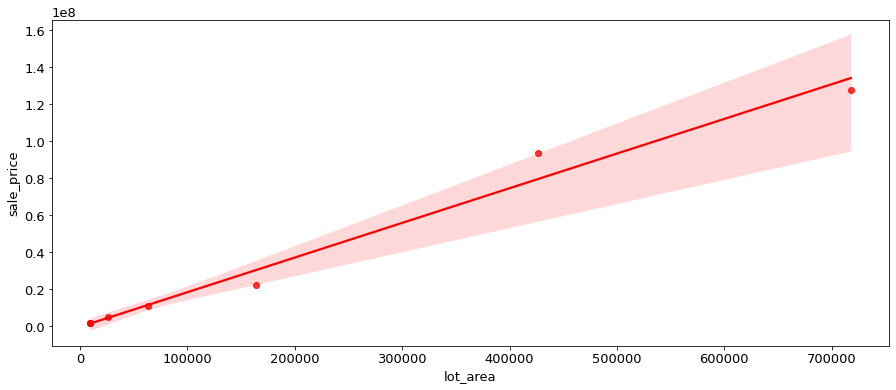

In [380]:
sns.regplot( dfx['lot_area'], dfx['sale_price'], color='red' );

### **3.** Casas vendidas durante o feriado natalino geram mais lucro que em feriados da páscoa.
De acordo com os dados é **Verdadeiro**, porem ainda não há registros de vendas natalinas no ano de 2009 e 2010.

In [415]:
dfa1 = df2[['sale_price', 'christmans', 'yr_sold']].groupby( ['christmans', 'yr_sold'] ).mean().reset_index()
dfa2 = df2[['sale_price', 'easter', 'yr_sold']].groupby( ['easter', 'yr_sold'] ).mean().reset_index()
dfa1a = dfa1[dfa1['christmans'] == 1]
dfa2a = dfa2[dfa2['easter'] == 1]

In [452]:
dfa1a.sort_values( 'sale_price', ascending=False )

christmans  yr_sold     sale_price
6           1     2007  214414.500000
5           1     2006  185545.000000
7           1     2008  175600.000000
8           1     2009  164014.533333

In [453]:
dfa2a.sort_values( 'sale_price', ascending=False )

easter  yr_sold     sale_price
8       1     2009  181680.769231
5       1     2006  174312.814815
9       1     2010  171344.025641
6       1     2007  170772.608696
7       1     2008  159293.346154

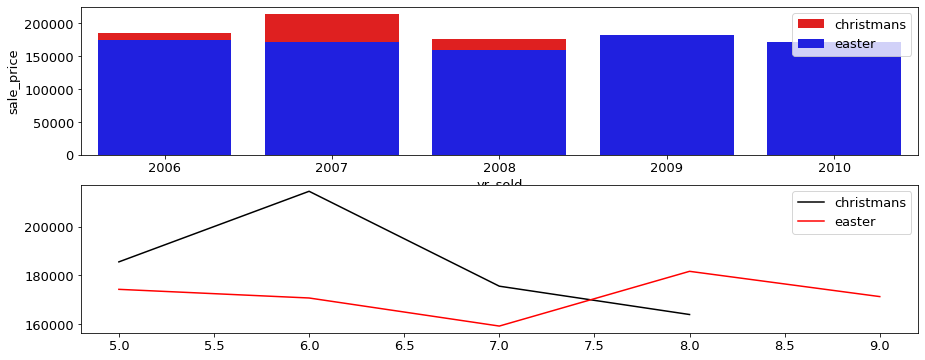

In [447]:
plt.subplot( 2, 1, 1 )
sns.heatmap( dfa[['sale_price', 'lot_area']].corr( method='pearson' ), annot=True )

plot_diff( dfa1a, dfa2a, 'yr_sold', 'sale_price' )

### <s> **4.** Casas com piscina e fogueira são 10% mais caras que casas com apenas piscina.</s>
Indefinido, pois todas as casas que tem piscina, possui uma fogueira.

In [471]:
df2[(df2['pool_qc'] != 'DontHave') & (df2['fireplace_qu'] != 'DontHave')][['pool_qc', 'fireplace_qu']].T

197  810  1170 1182 1298 1386 1423
pool_qc        Ex   Fa   Gd   Ex   Gd   Fa   Gd
fireplace_qu   Ex   Fa   Po   TA   Gd   TA   Gd

### **5.** Casas na vizinhaça de timberland possuem a média de preço mais alta que nas demais vizinhanças.
Comparando os demais portfolios, realmente a vizinhança Timber tem um certo preço mais alto em comparação com aproximadamente 75% de todo o portfolio, a linha em azul escuro representa o mínimo de vendas da vizinhança timber em comparação com as demais vizinhamças, e a azul clara o portfolio mais caro da vizinhança Timber já vendida, logo a hipótese é **Falsa**.

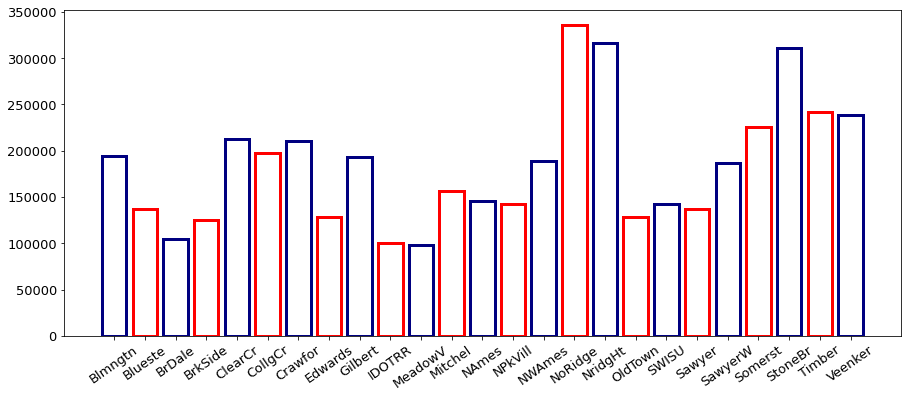

In [50]:
dfa  = df2[['sale_price', 'neighborhood']].groupby( 'neighborhood' ).mean().reset_index()
dfa1 = df2[['sale_price', 'neighborhood', 'mo_sold']].groupby( ['neighborhood', 'mo_sold'] ).mean().reset_index()

plt.bar( dfa['neighborhood'], dfa['sale_price'], **args_b() );
plt.xticks( rotation=35 );

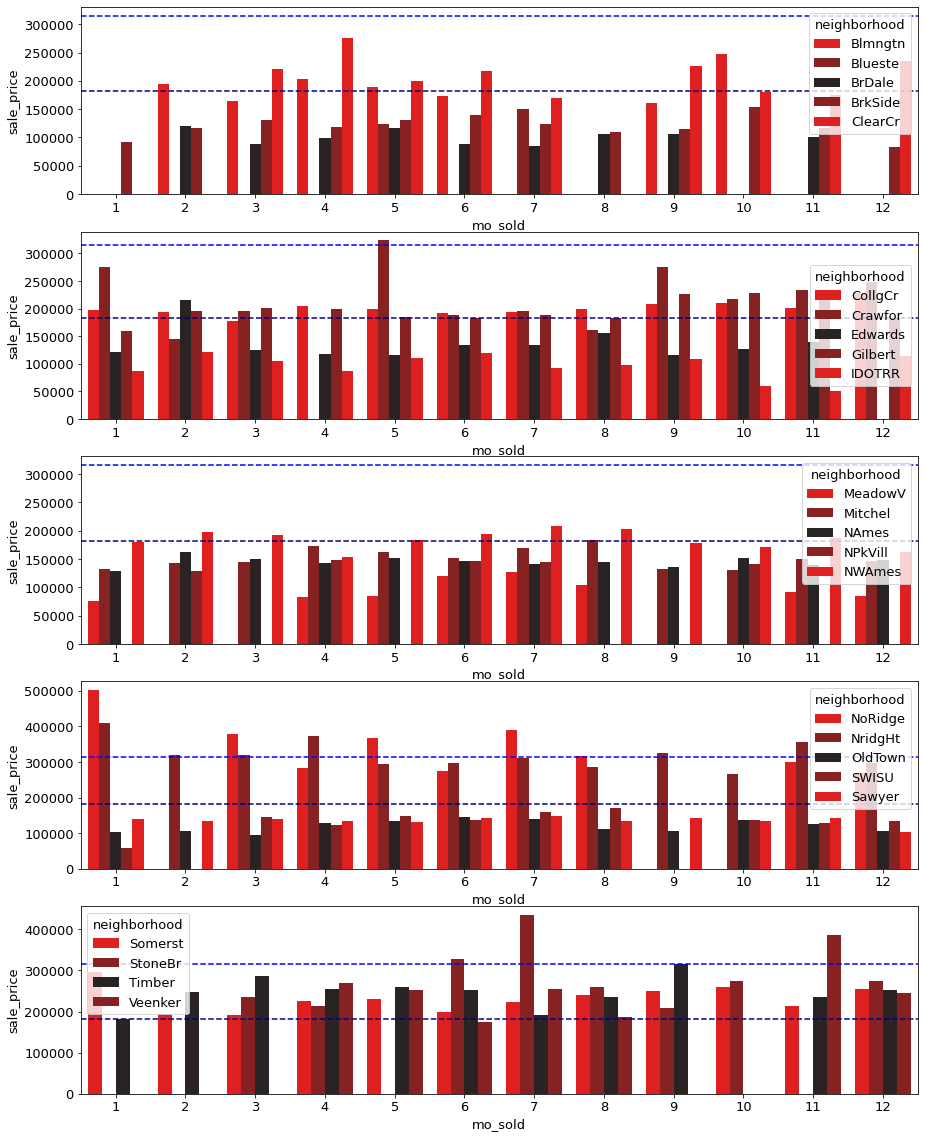

In [166]:
fig, ax = plt.subplots( 5, 1, figsize=(15, 20) )
for k in zip( l, range( 0, 5 ) ):
    dfa2 = dfa1[dfa1.neighborhood.isin( k[0] )]
    sns.barplot( dfa2['mo_sold'], dfa2['sale_price'], hue=dfa2['neighborhood'], ax=ax[k[1]] )
    ax[k[1]].axhline( 315500, linestyle='--', c='b' )
    ax[k[1]].axhline( 182750, linestyle='--', c='navy' )

### **6.** Casas com maior qualidade representam mais de 20% das vendas.
De acordo com os dados, a qualidade geral dos materiais da casa representa 27% das venda, então é **Verdadeira**.

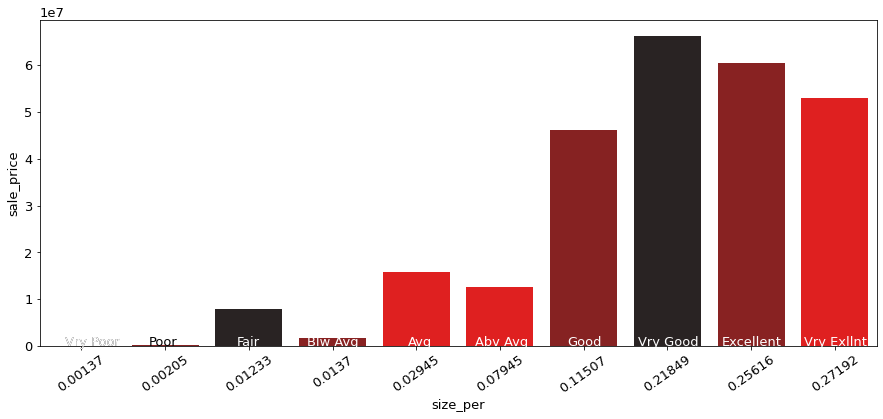

In [263]:
dfa = df2[['sale_price', 'overall_qual']].groupby('overall_qual').sum()
dfa['size_per'] = np.round( (df2.groupby('overall_qual').size() / len( df2 )), 5 )
dfa = dfa.reset_index()
a = {10: 'Very Excellent', 9: 'Excellent', 8: 'Very Good', 7: 'Good', 6: 'Above Average', 5: 'Average', 4: 'Below Average', 3: 'Fair', 2: 'Poor', 1: 'Very Poor' }
dfa['overall_qual'] = dfa['overall_qual'].map( a )

plot_percent( dfa )

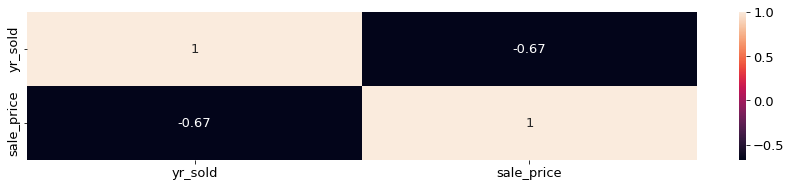

In [203]:
plt.subplot( 2, 1, 1 )
sns.heatmap( dfa.corr( method='pearson'), annot=True );

In [339]:
a = []
sales = []
for i in df2['overall_qual'].sort_values().unique():
    values = df2[df2['overall_qual'] == i]['sale_price'].tolist()
    a.append( {str(i):values} )
    

sales_q = [list(a[k].values())[0] for k in list(range( 0, 10, 1 ))]

In [344]:
f, p = ss.f_oneway( sales_q[0], sales_q[1], sales_q[2], sales_q[3], sales_q[4], sales_q[5], sales_q[6], sales_q[7], sales_q[8], sales_q[9] )
print( f'P-Value: {p}\nF Stats: {f}' )

P-Value: 0.0
F Stats: 349.02683956930736


### <s> **7.** Casas com elevador representam 70% do faturamente da categoria extras.</s>
Dão existem Elevadores na categoria Misc

In [151]:
df2[['misc_feature', 'sale_price']].groupby( 'misc_feature' ).sum().reset_index().T

0       1       2        3       4
misc_feature   DontHave    Gar2    Othr     Shed    TenC
sale_price    255957253  341500  188000  7408193  250000

### **8.** As vendas de imóveis creçem a cada ano.
De acordo com os dados, as vendas permanecem constantes ao longo dos anos, porem com um decaimento a cada 2 anos, e o ano de 2010 não esta completo, logo a hipótese é **Falsa**

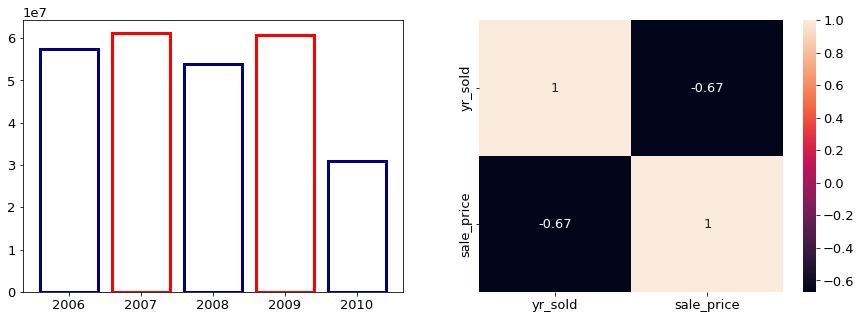

In [202]:
dfa = df2[['yr_sold', 'sale_price']].groupby('yr_sold').sum().reset_index()

plot_bar( dfa, 'yr_sold', 'sale_price' )

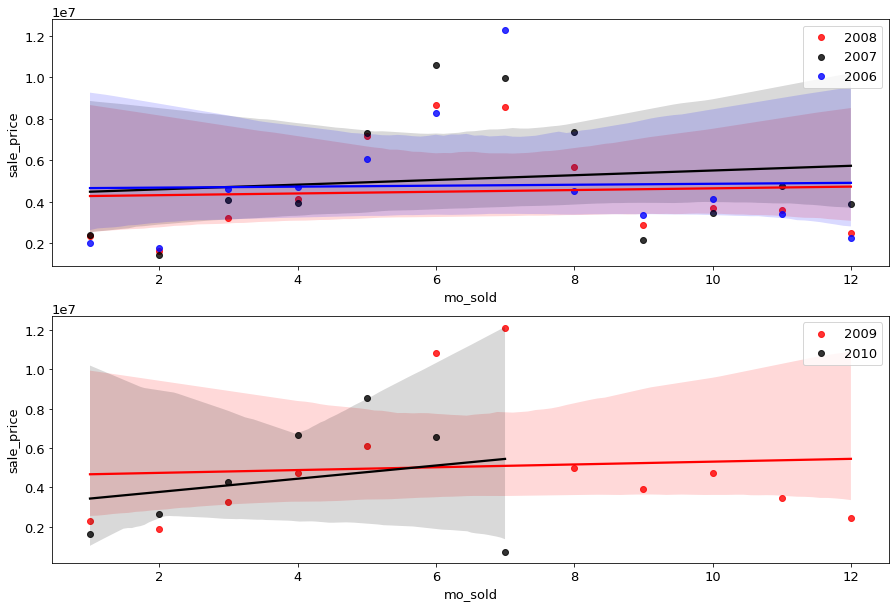

In [261]:
plot_year( df2, 'mo_sold', 'sale_price', [2008, 2007, 2006], [2009, 2010] )

### 4.2.1. All Variables per Sale

In [180]:
m, c = metrics( df2 )

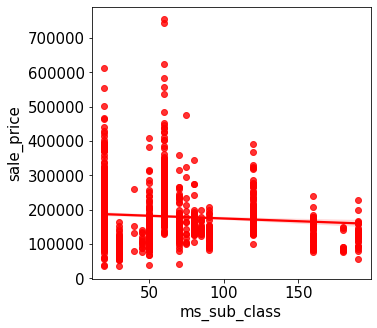

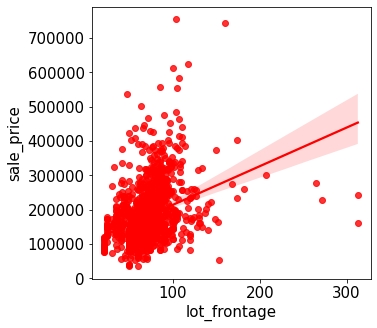

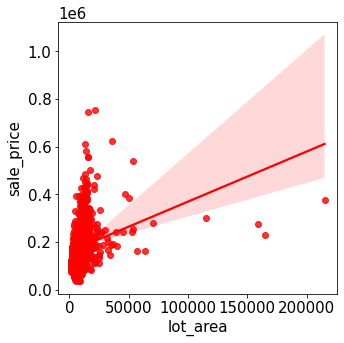

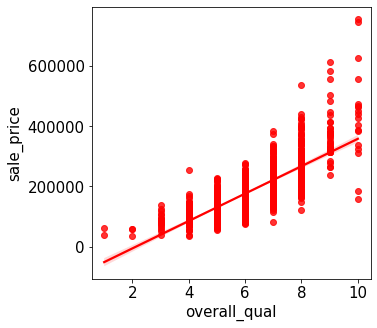

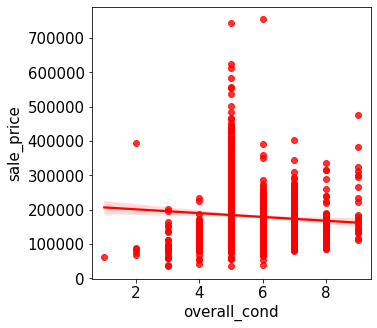

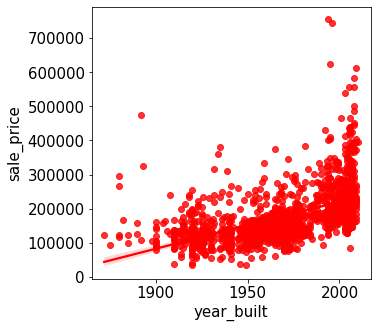

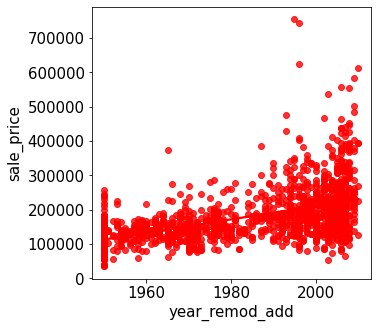

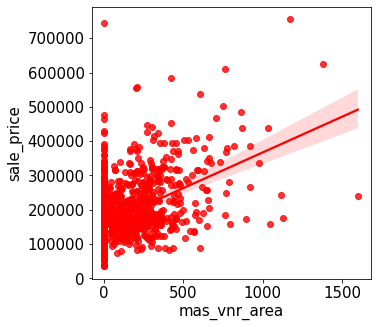

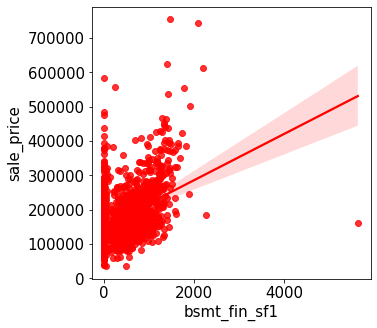

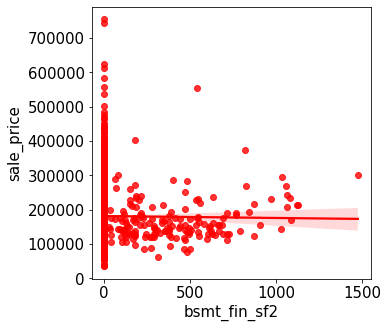

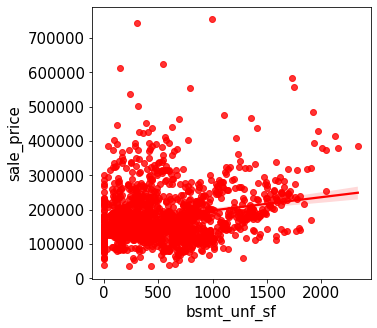

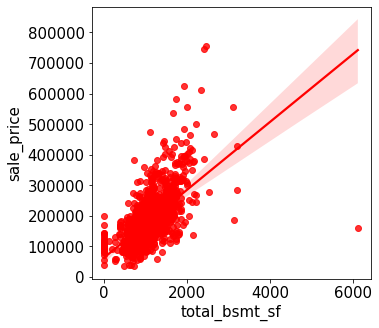

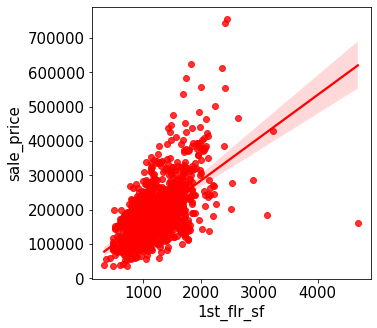

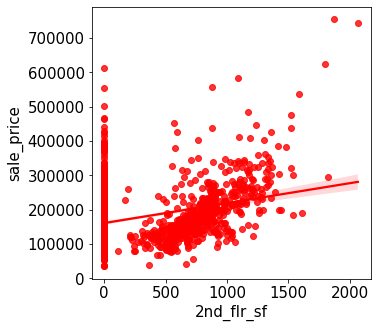

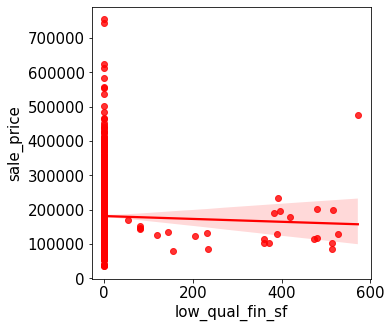

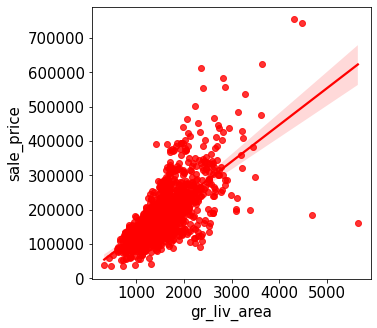

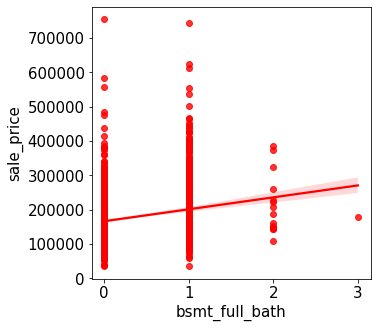

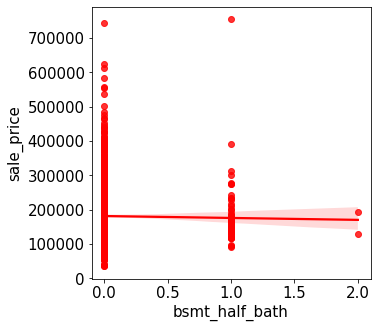

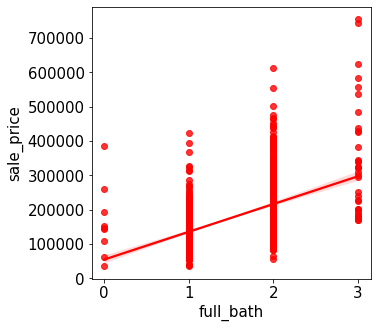

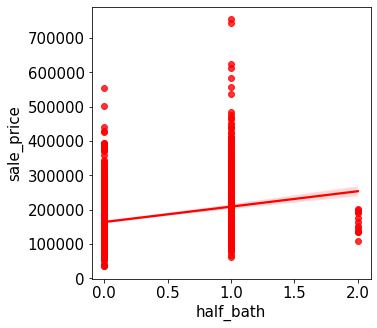

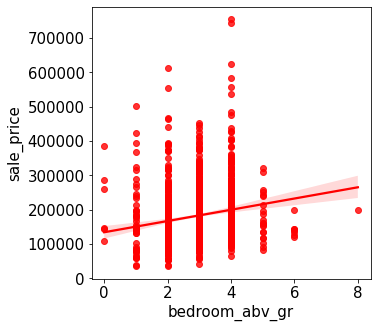

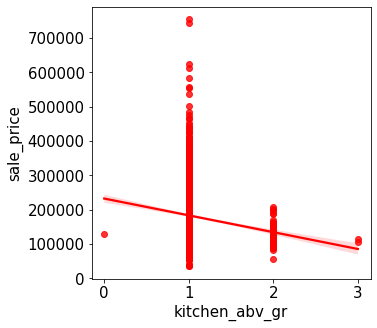

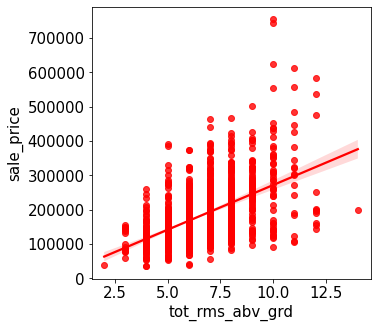

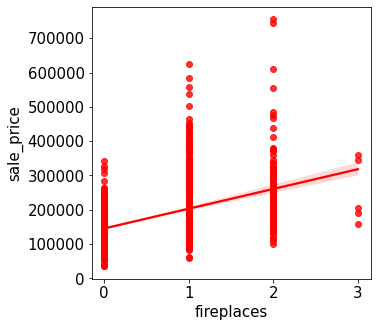

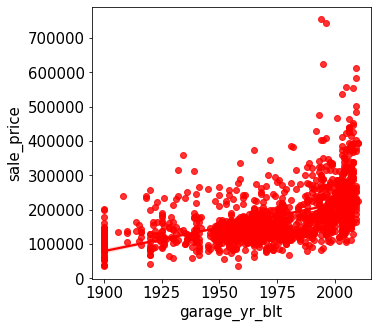

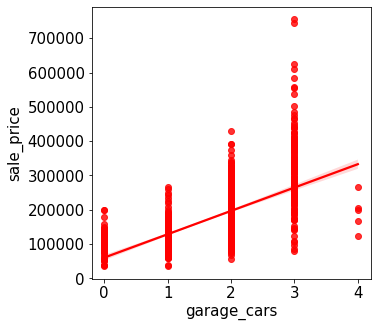

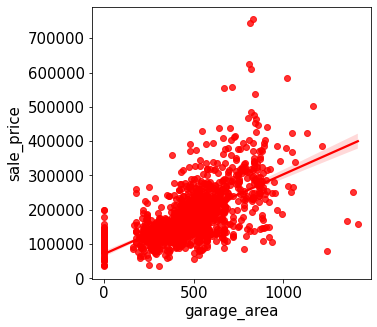

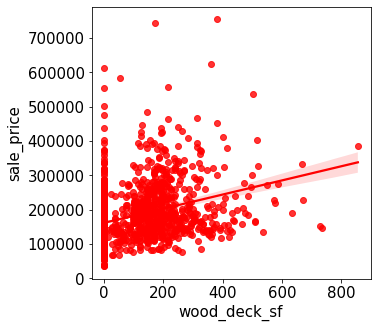

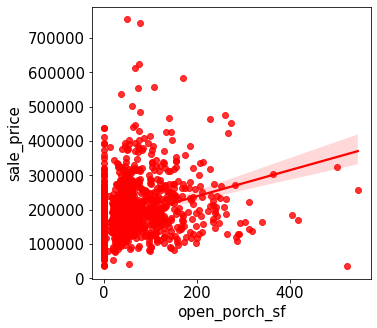

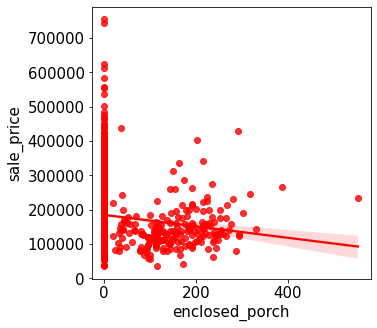

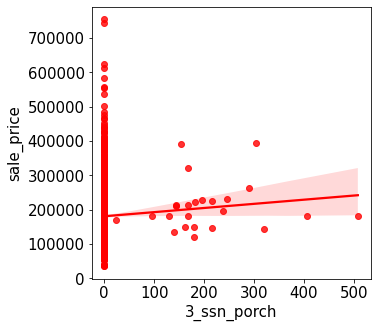

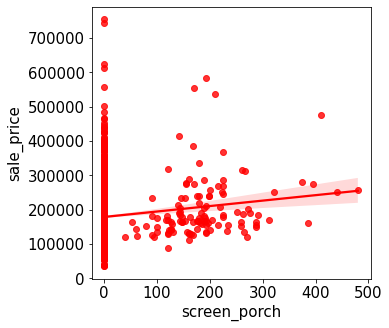

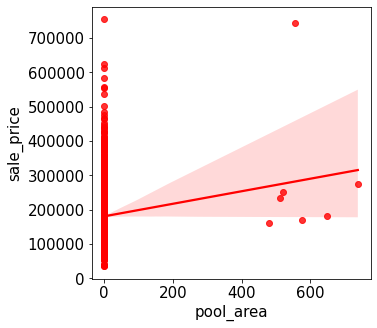

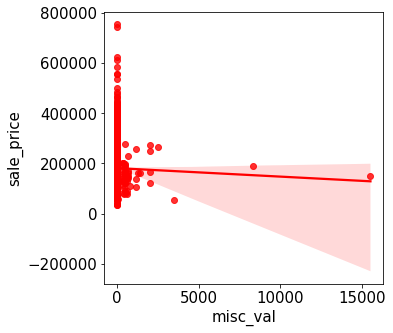

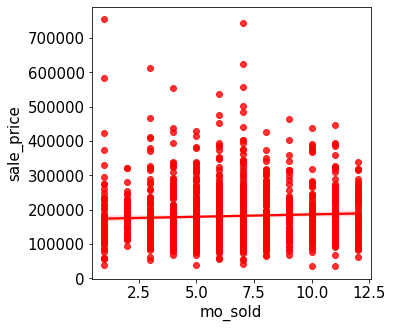

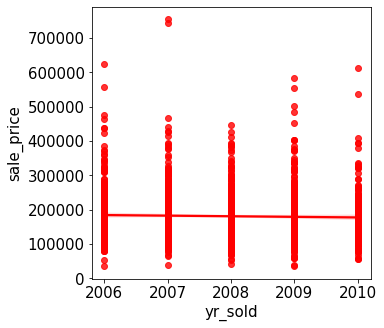

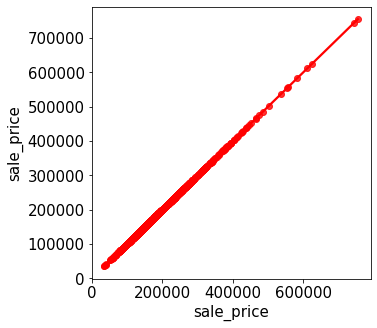

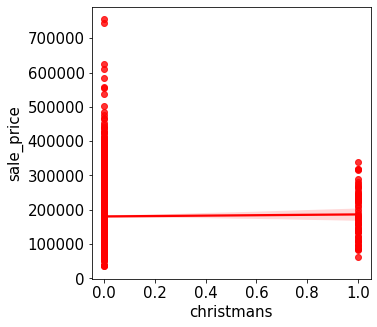

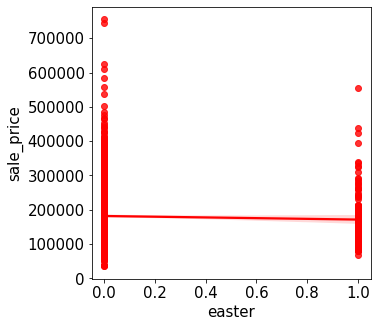

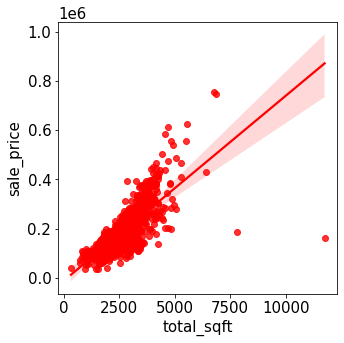

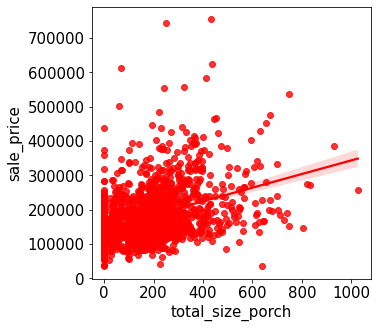

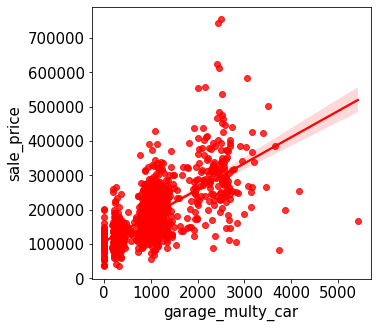

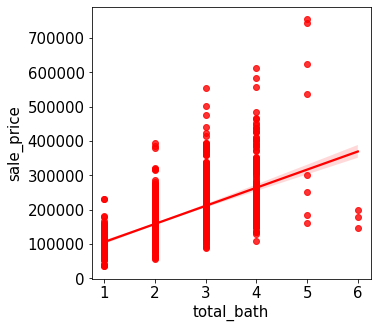

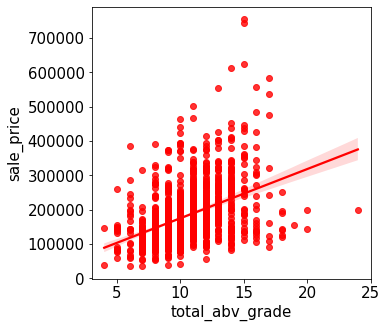

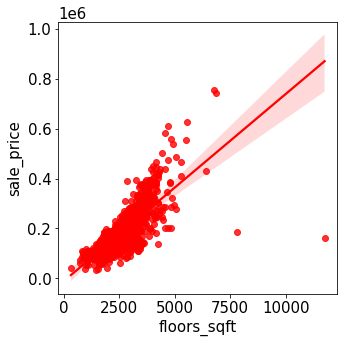

In [181]:
for i in m.columns:
    fig, ax = plt.subplots( figsize=(5, 5))
    sns.regplot( df2[i], df2['sale_price'], color='r' )

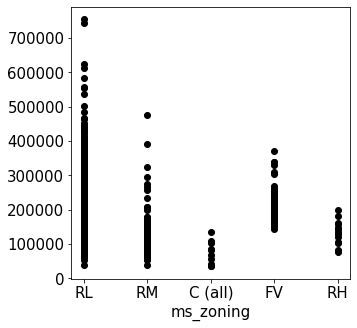

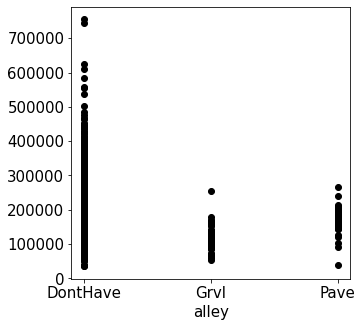

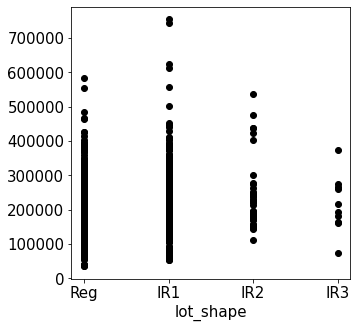

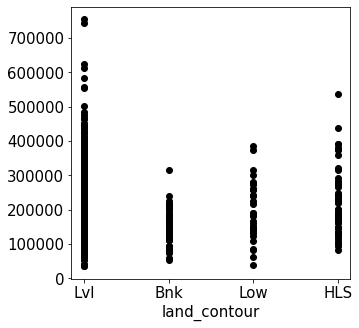

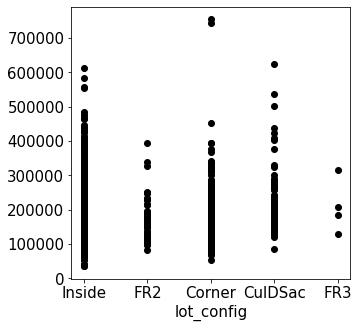

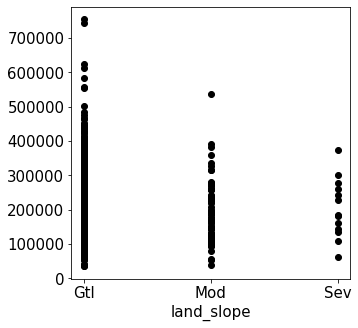

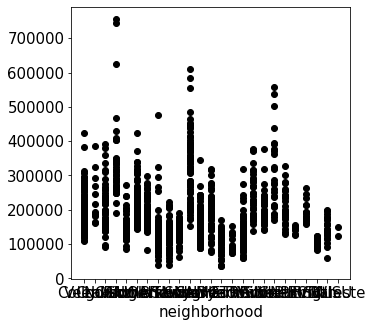

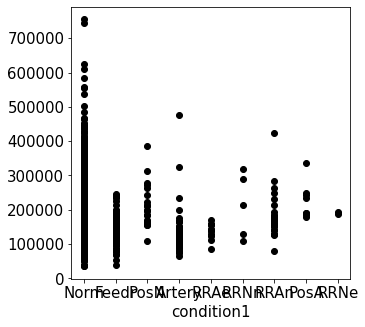

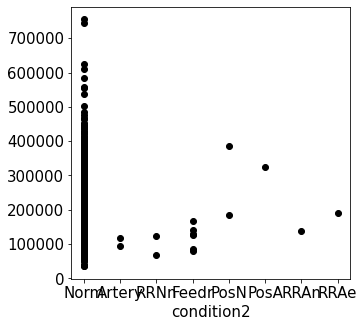

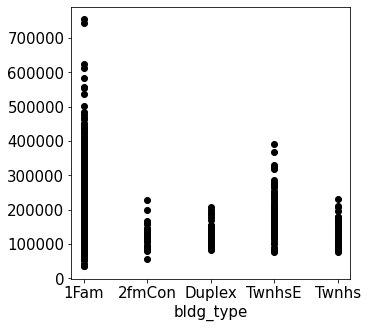

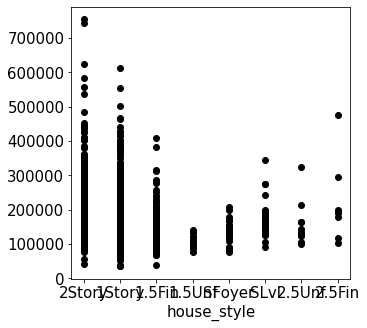

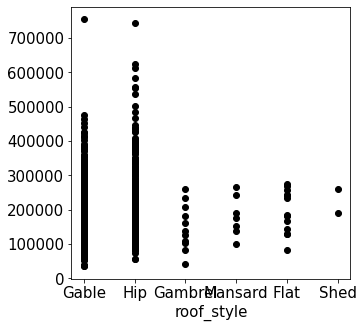

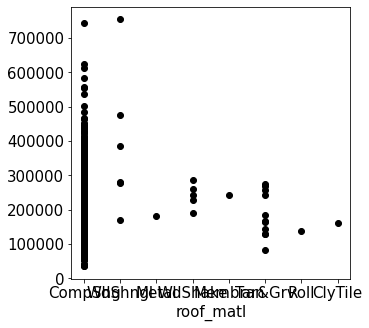

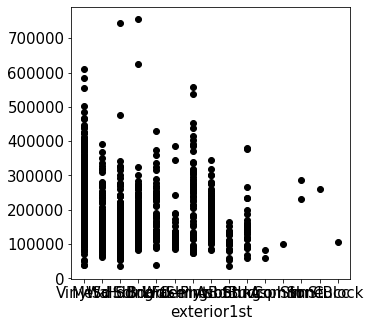

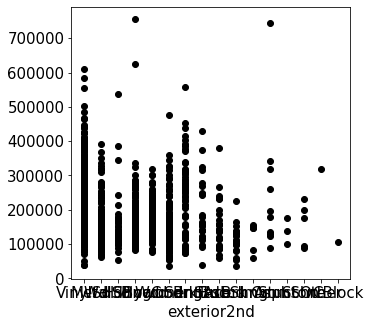

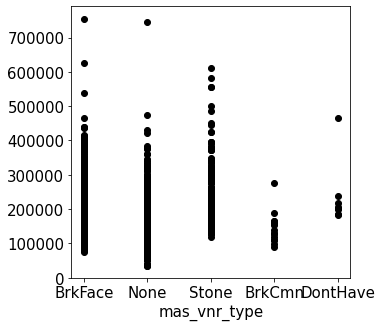

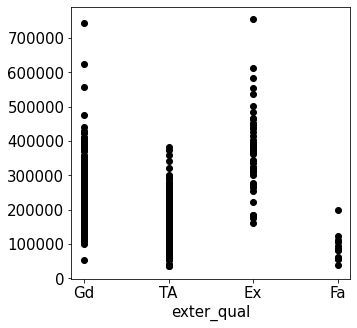

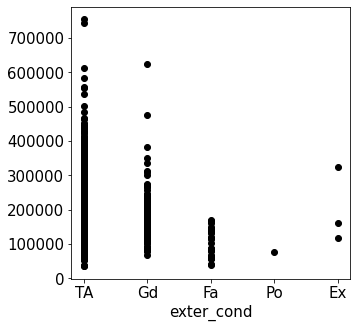

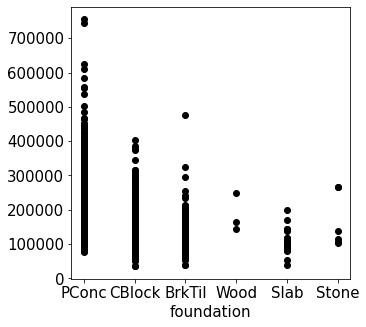

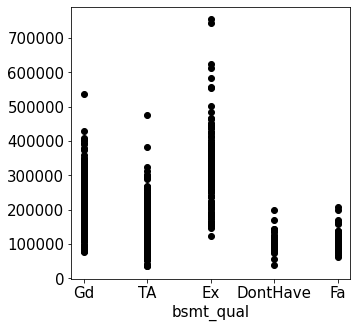

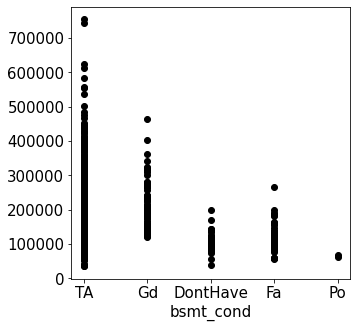

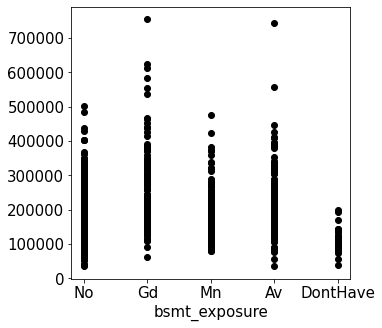

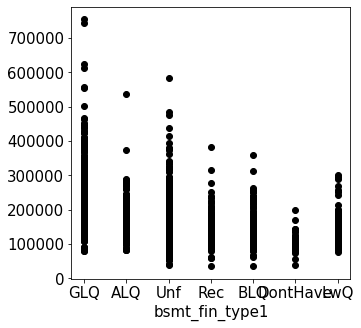

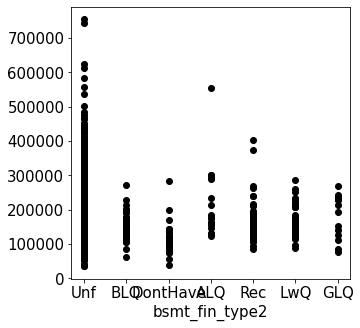

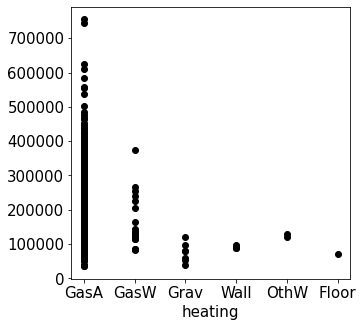

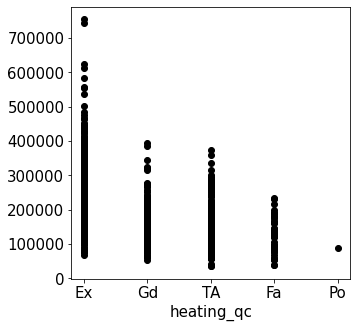

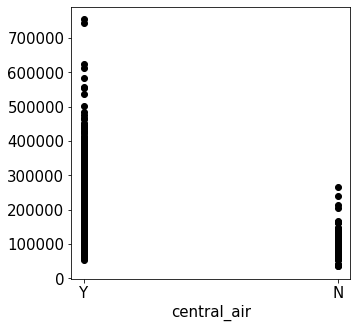

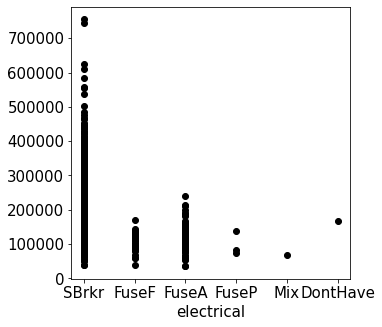

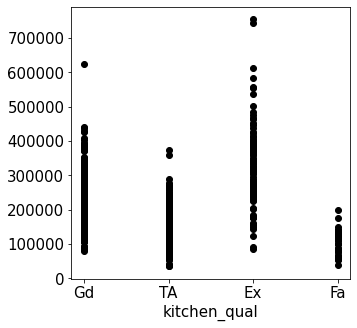

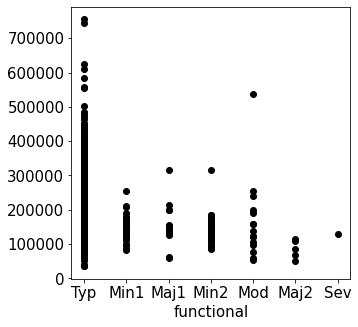

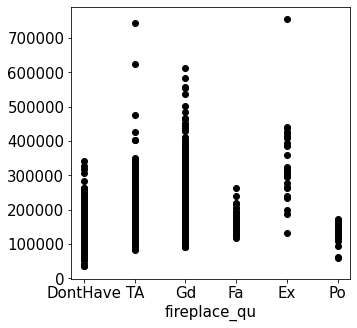

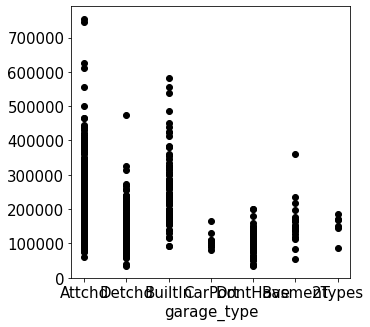

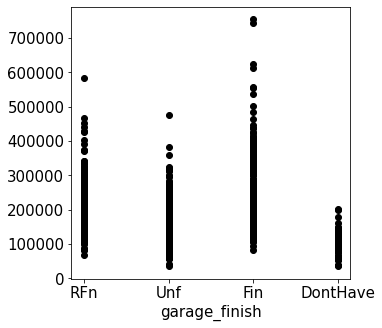

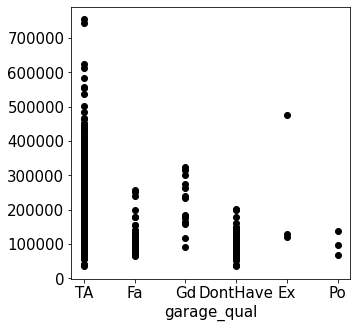

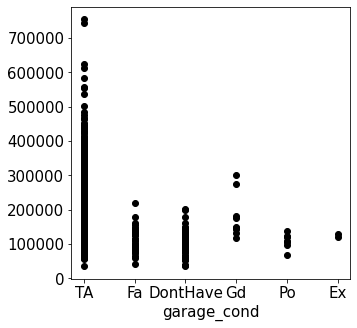

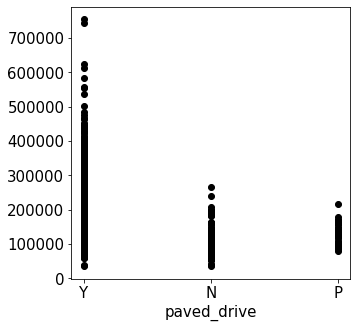

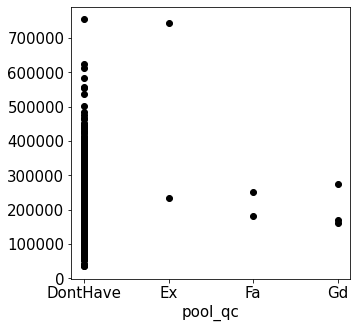

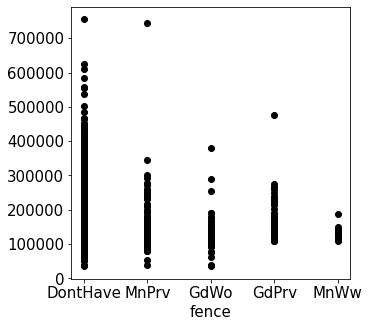

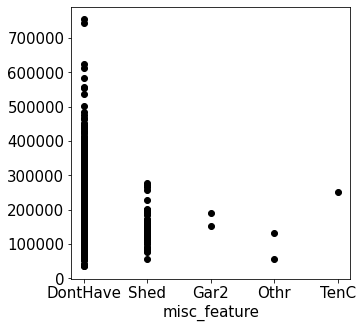

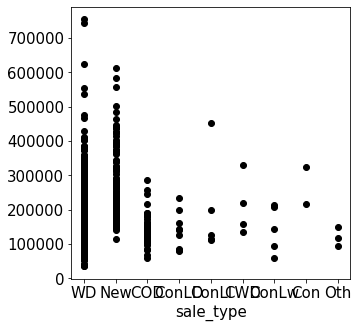

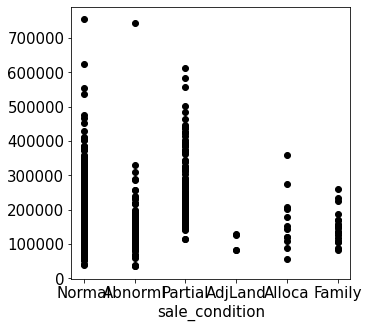

In [169]:
for i in c.columns:
    fig, ax = plt.subplots( figsize=(5, 5))
    ax.scatter( c[i], df2['sale_price'], c='k' );
    ax.set_xlabel(i)

## 4.3. Multivariable Analysis

In [191]:
m, catt = metrics( df2 )

In [10]:
m1 = m.iloc[:, :13]
m2 = m.iloc[:, 13:26]
m3 = m.iloc[:, 26:]

### 4.3.1. Numerical Attributes

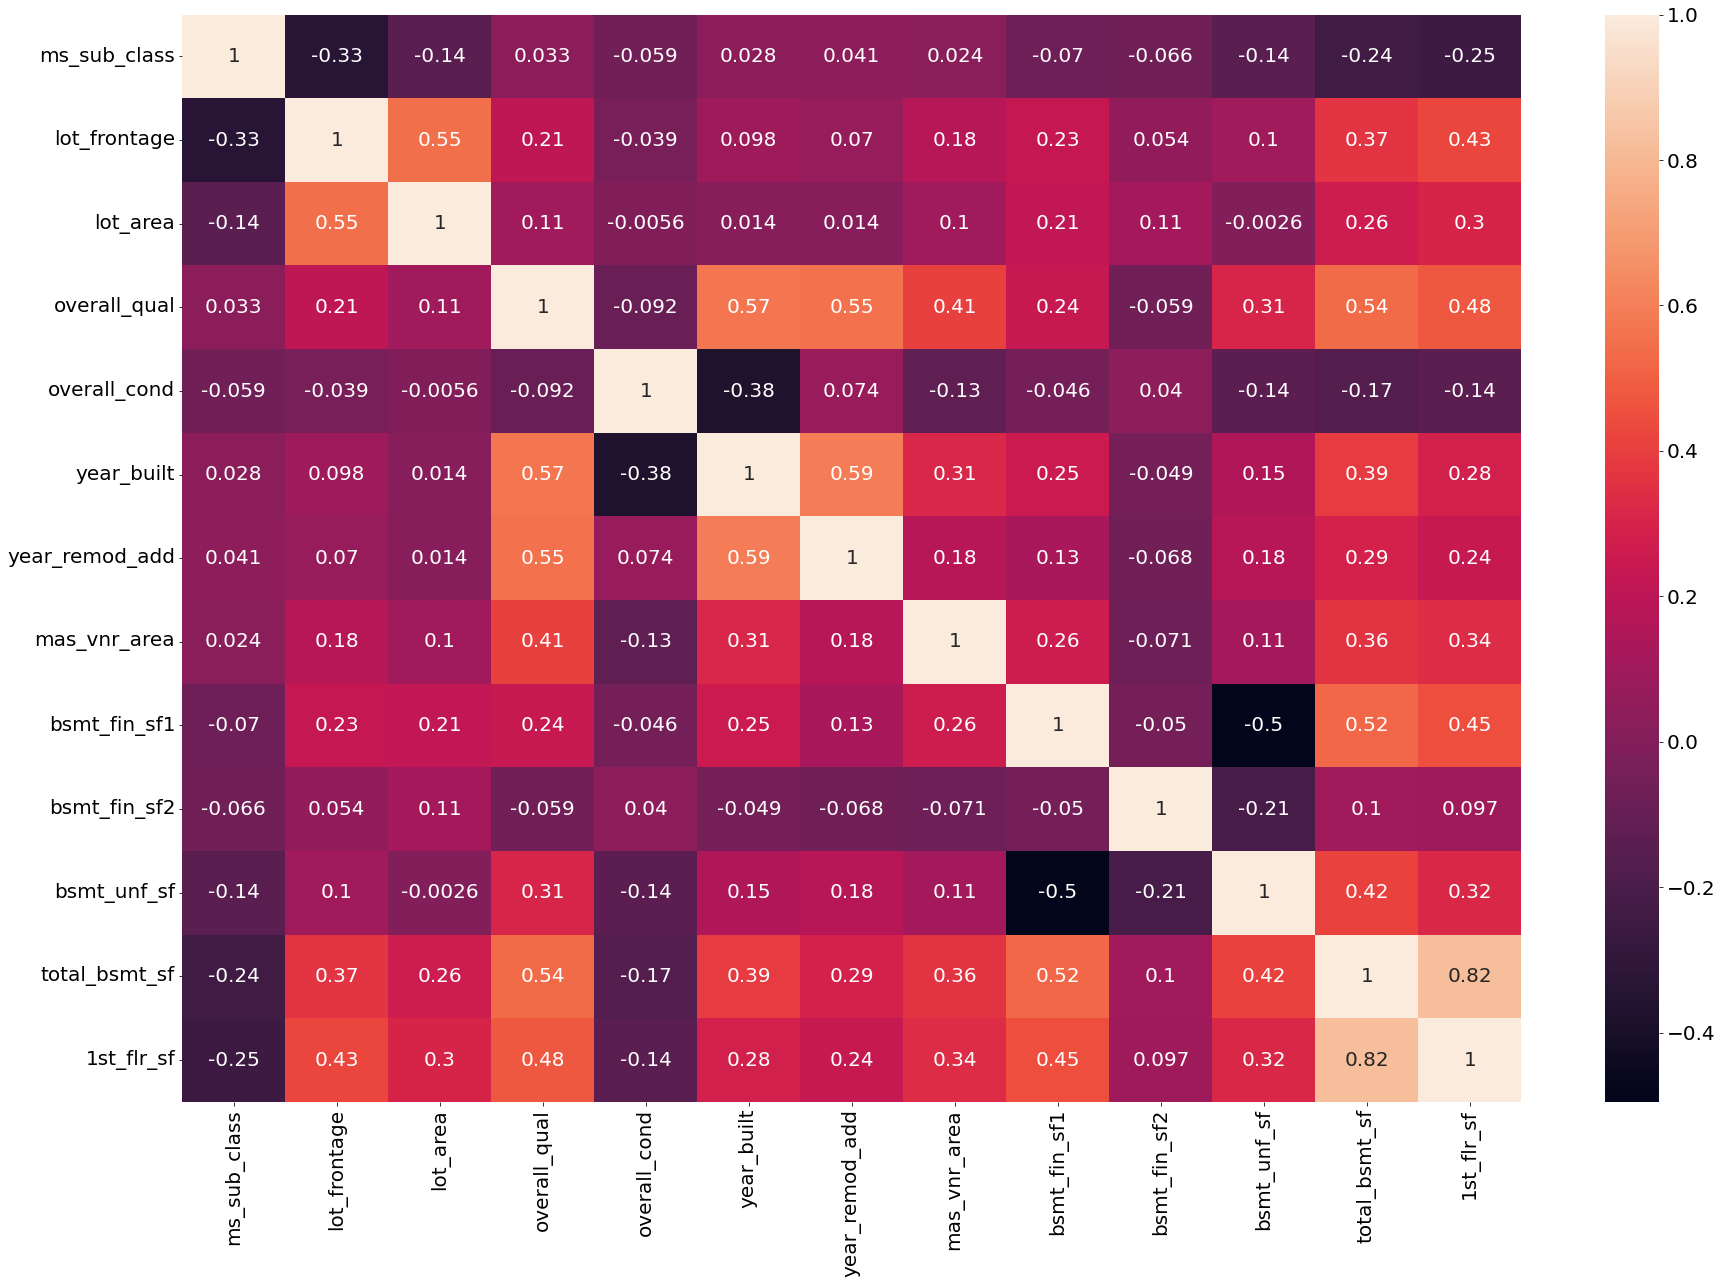

In [24]:
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['font.size'] = 20
sns.heatmap( m1.corr( method='pearson' ), annot=True );

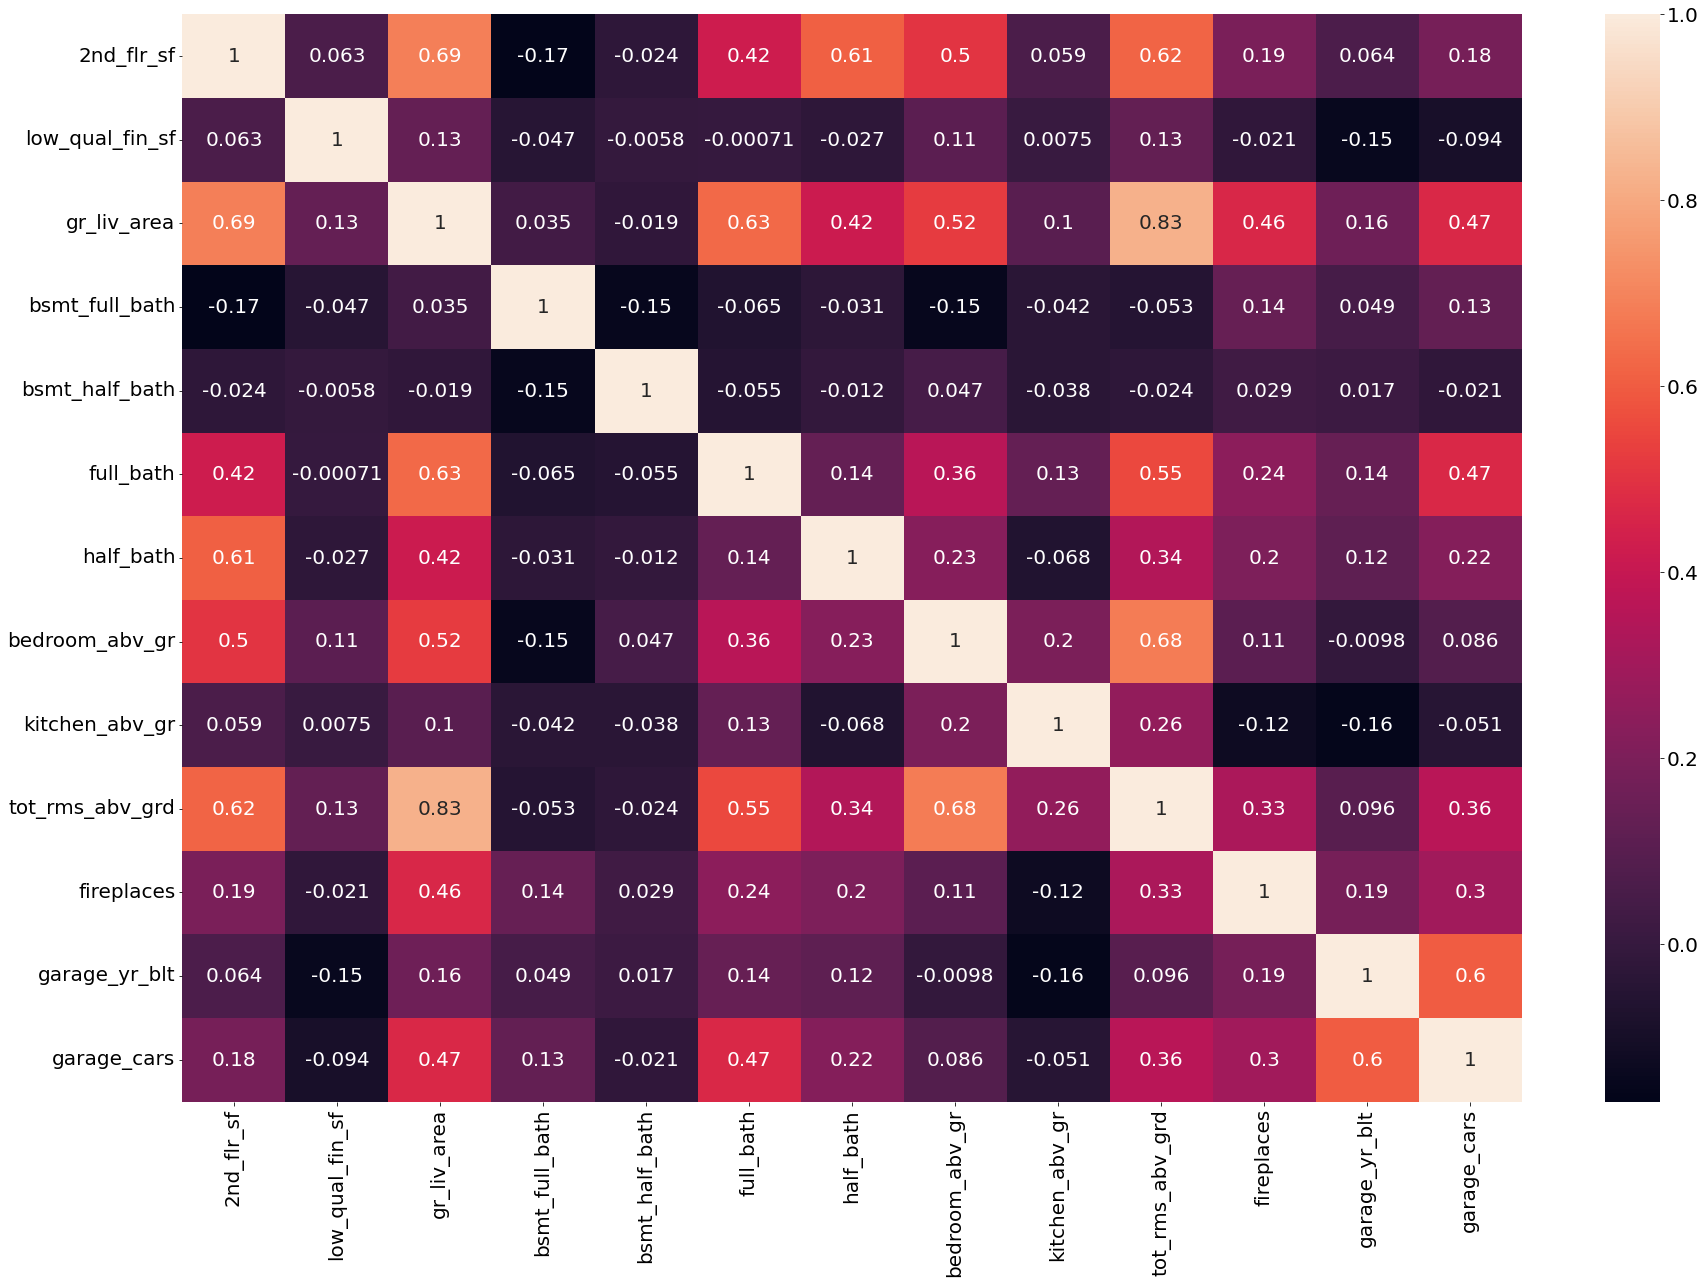

In [25]:
sns.heatmap( m2.corr( method='pearson' ), annot=True );

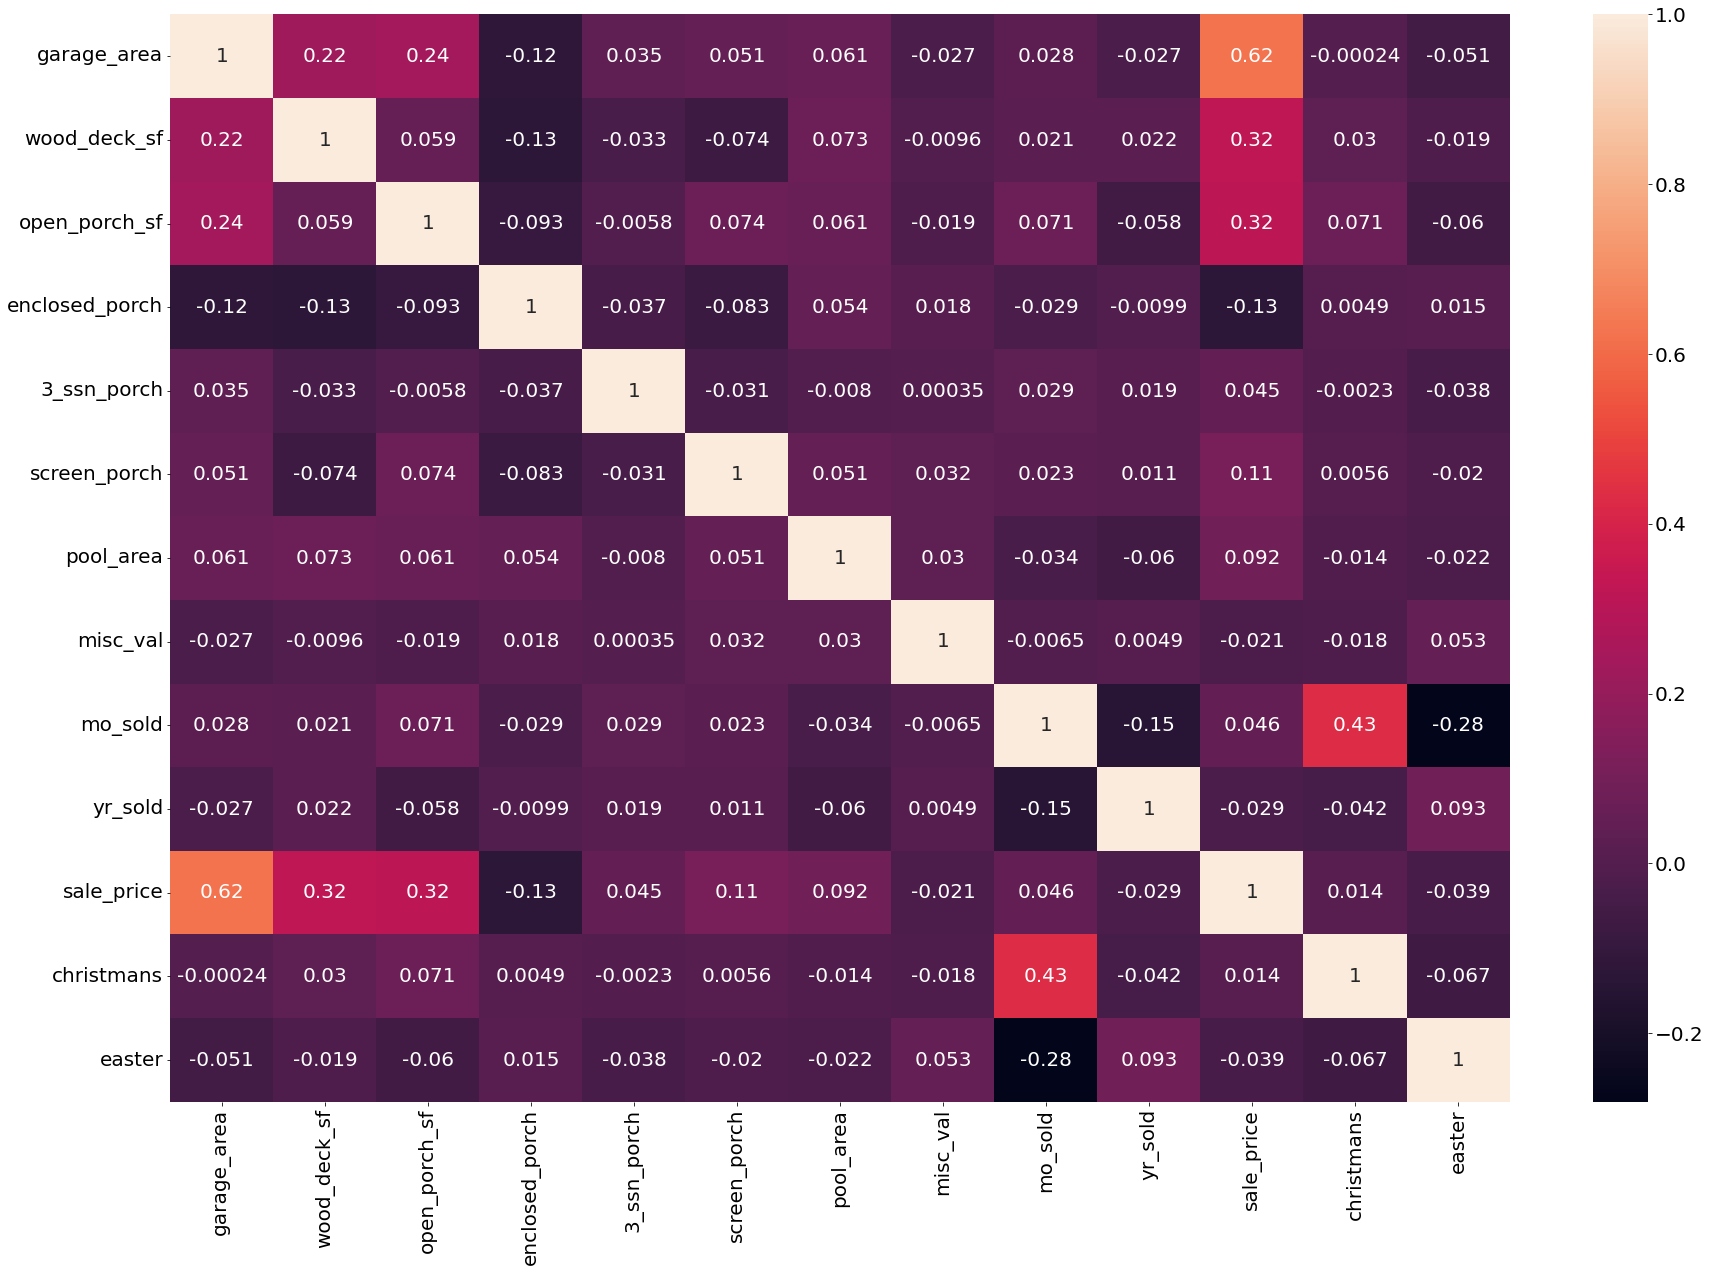

In [26]:
sns.heatmap( m3.corr( method='pearson' ), annot=True );

### 4.3.2. Categorical Attributes

In [236]:
cols = []
for i in catt.columns.tolist():
    for j in catt.columns.tolist():
        index = cramer_v( catt[i], catt[j] )
        cols.append( index )

In [257]:
df = pd.DataFrame()
for i, k in zip( range( 0, 1850, 45 ), range( 0, 42 )):
    a = pd.DataFrame( {catt.columns[k]: cols[i:i+42]})
    df = pd.concat( [df, a], axis=1 )
    #print(f"'{catt.columns[k]}: cols[{i}:{i+42}]'")

In [276]:
df = df.corr()
df1 = df.iloc[:15, :15]
df2 = df.iloc[15:, 15:]

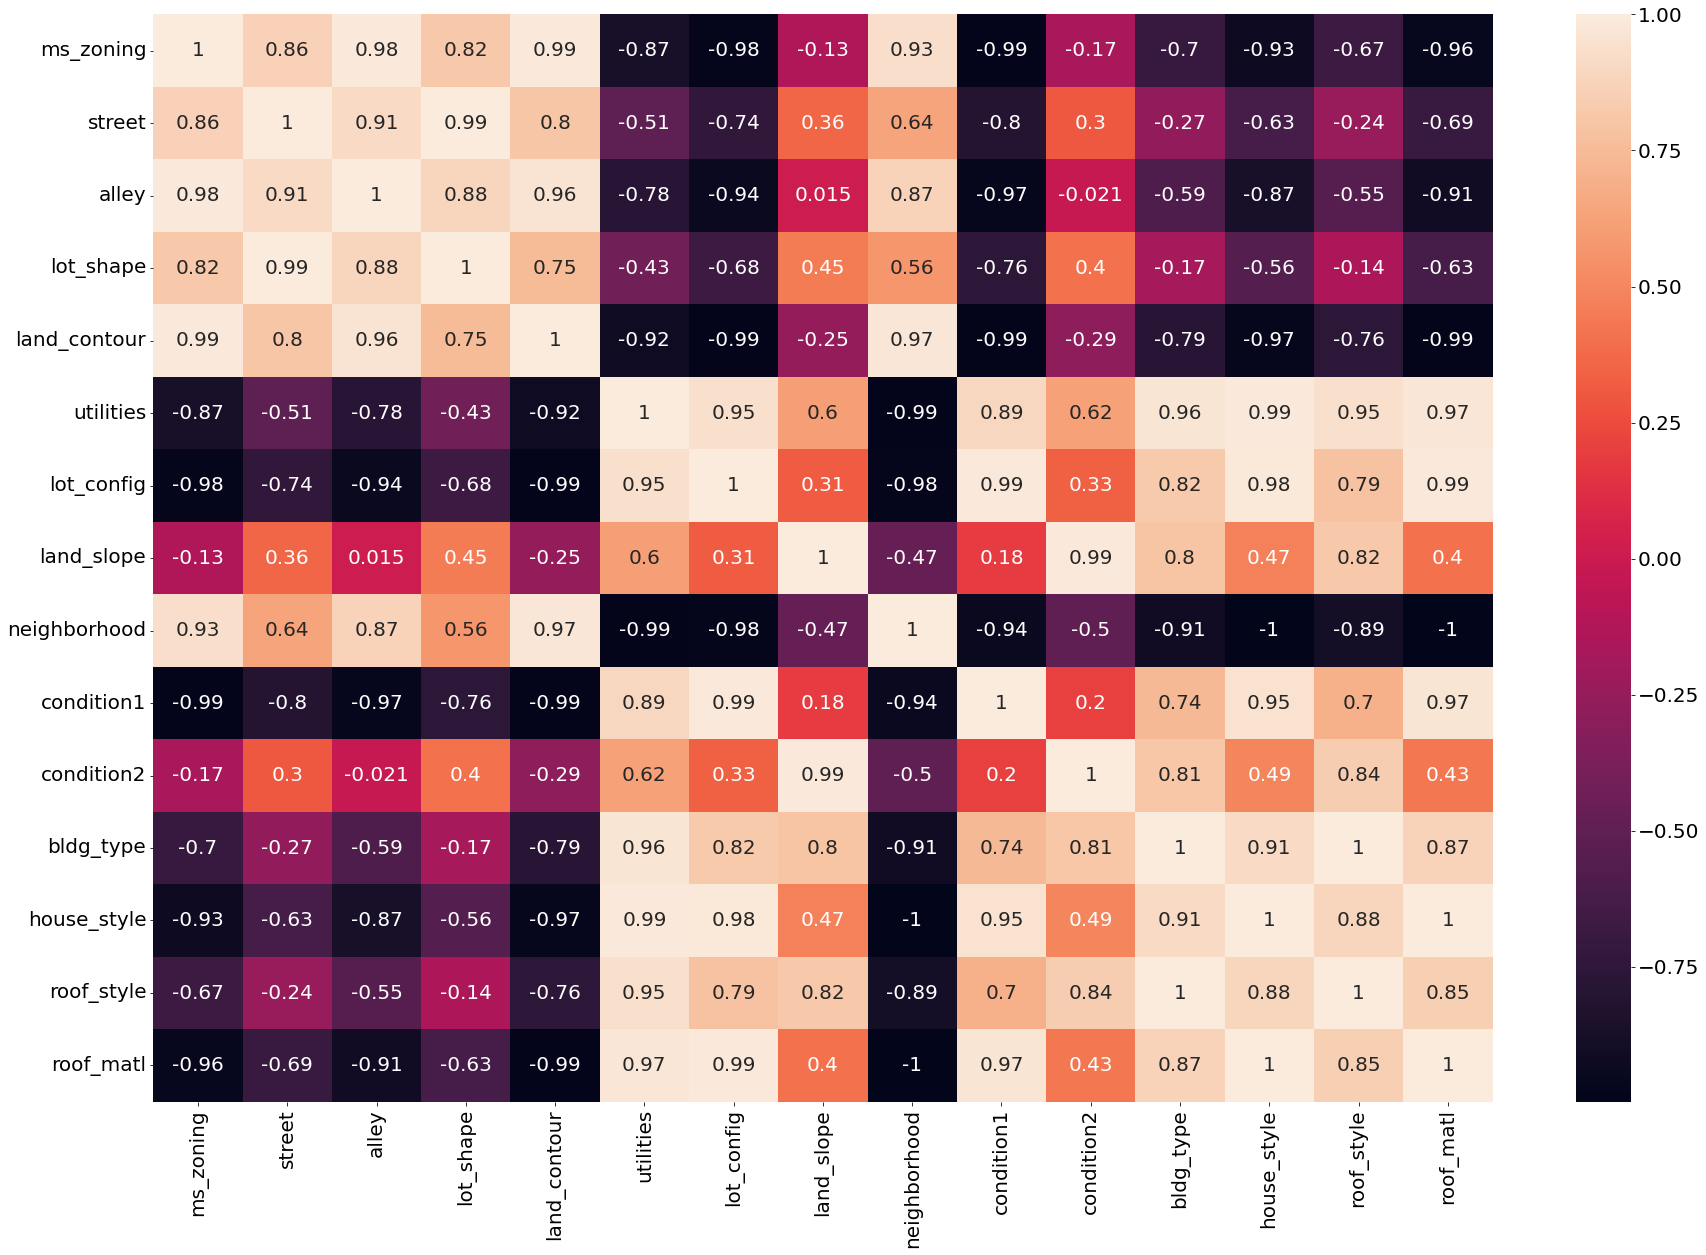

In [279]:
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['font.size'] = 20
sns.heatmap( df1, annot=True );

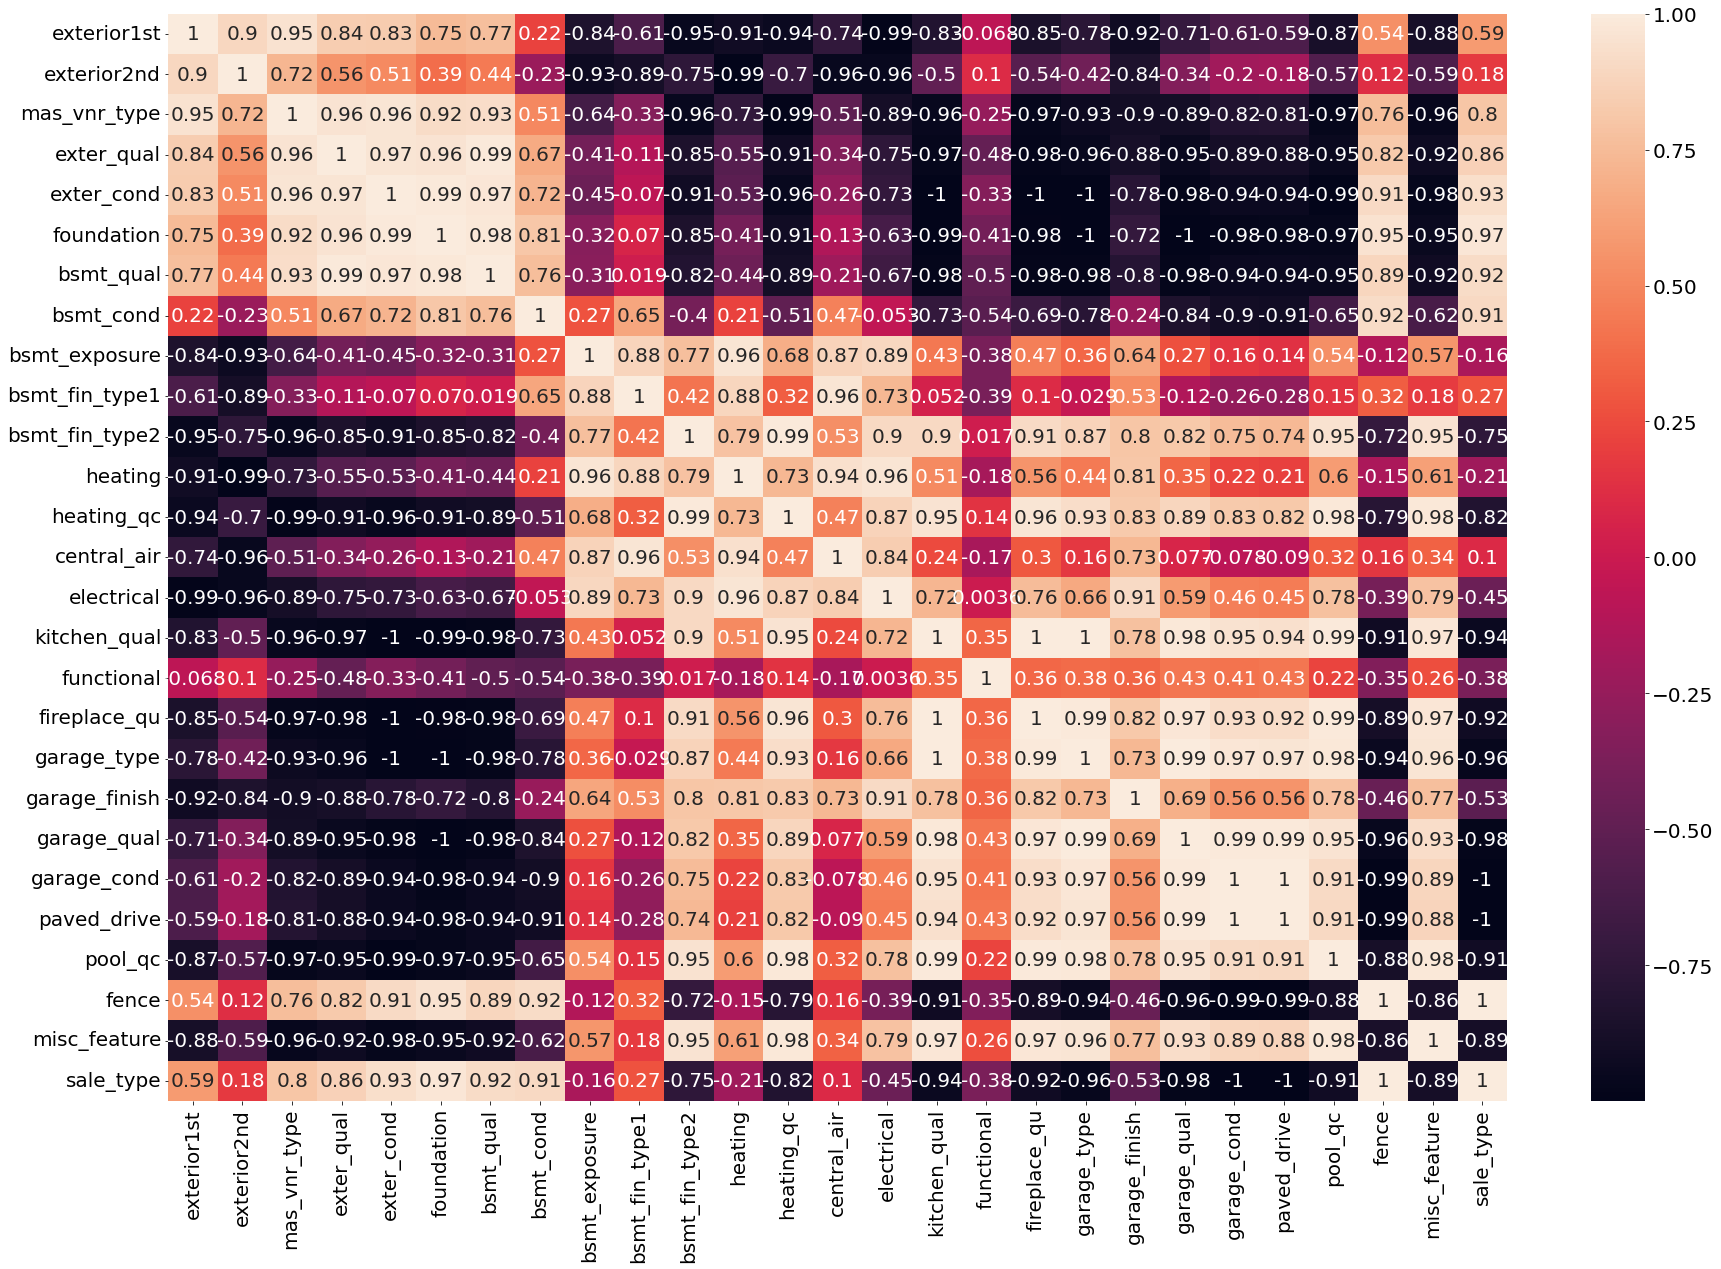

In [280]:
sns.heatmap( df2, annot=True );

# 5.0. Data Preparation

In [464]:
df5 = df2.copy()
num_att, catt_att = metrics( df5 )

## 5.1. Normalization

IndexError: index 21 is out of bounds for axis 0 with size 21

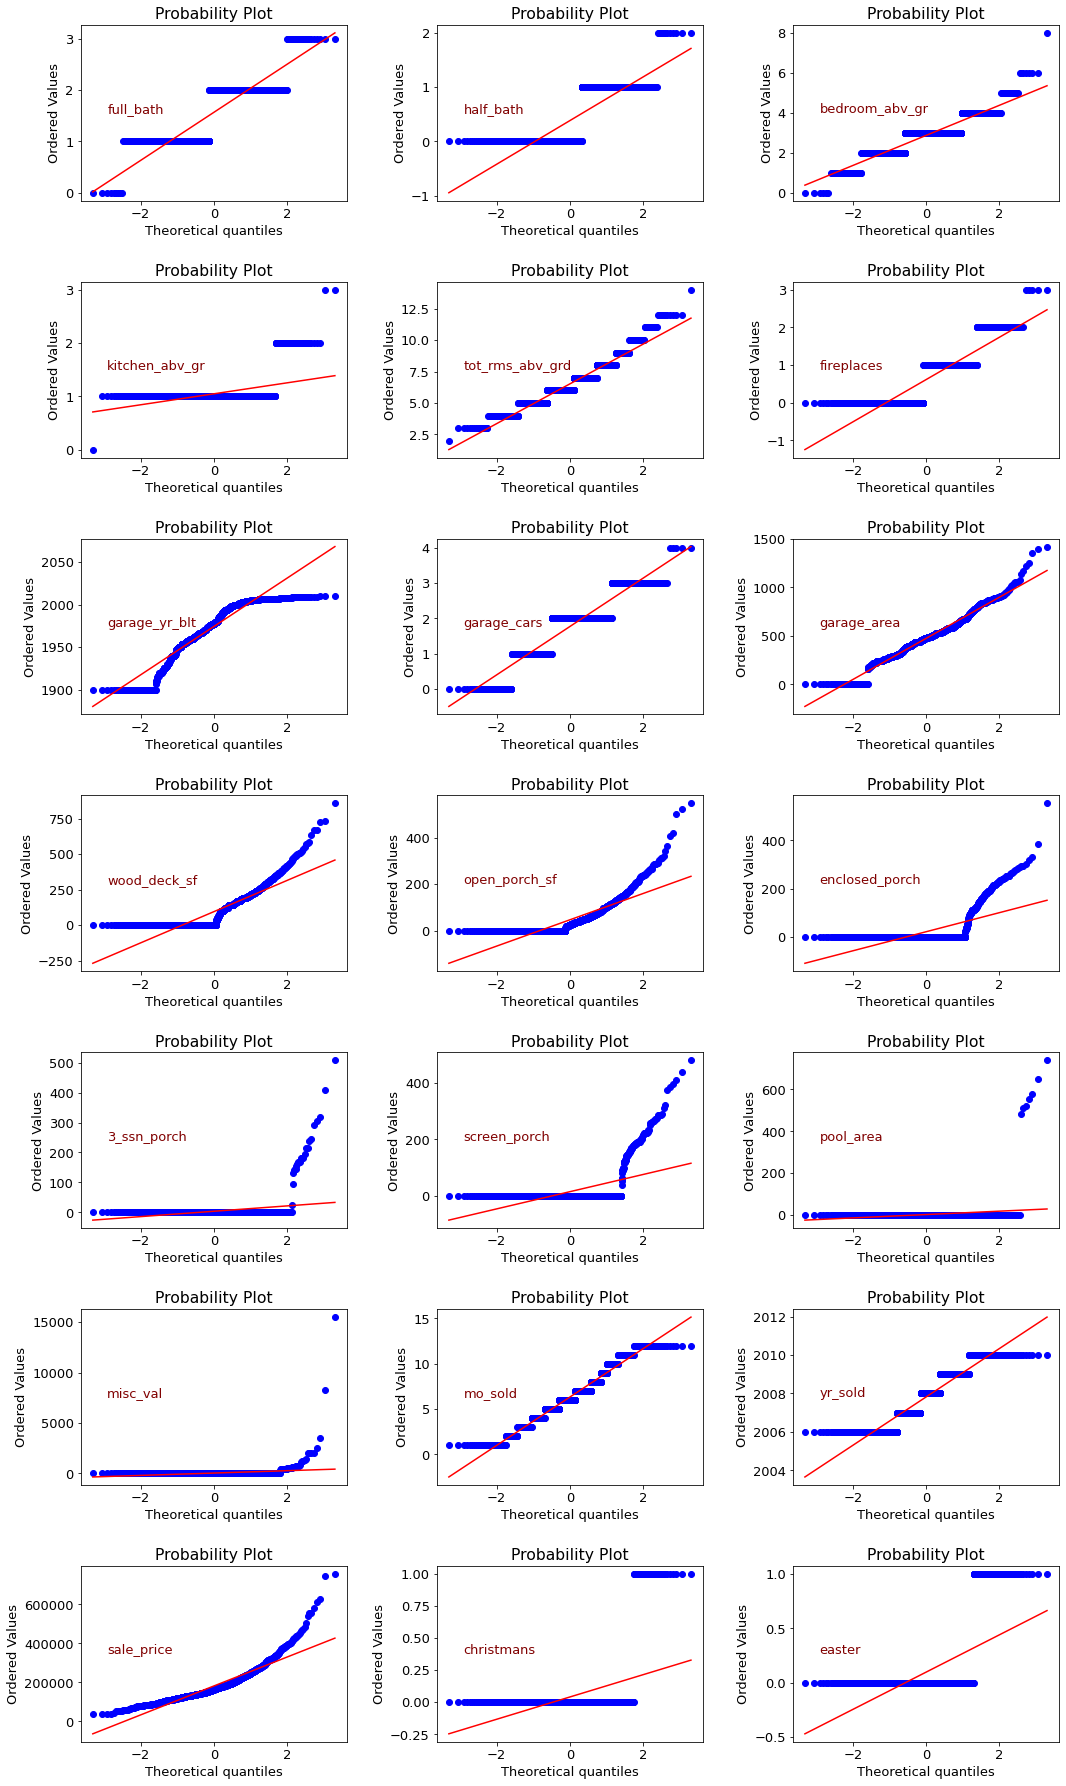

In [14]:
fig, ax = plt.subplots( 7, 3, figsize=(15, 25))
ax = ax.flatten()
for c, i in zip( num_att.columns[18:], range( len( num_att.columns[18:] ) ) ):
    ss.probplot( num_att[c], plot=ax[i] )
    plt.tight_layout(w_pad=2.0, h_pad=2.0)
    ax[i].text( .1, .5, c, color='maroon', transform=ax[i].transAxes)

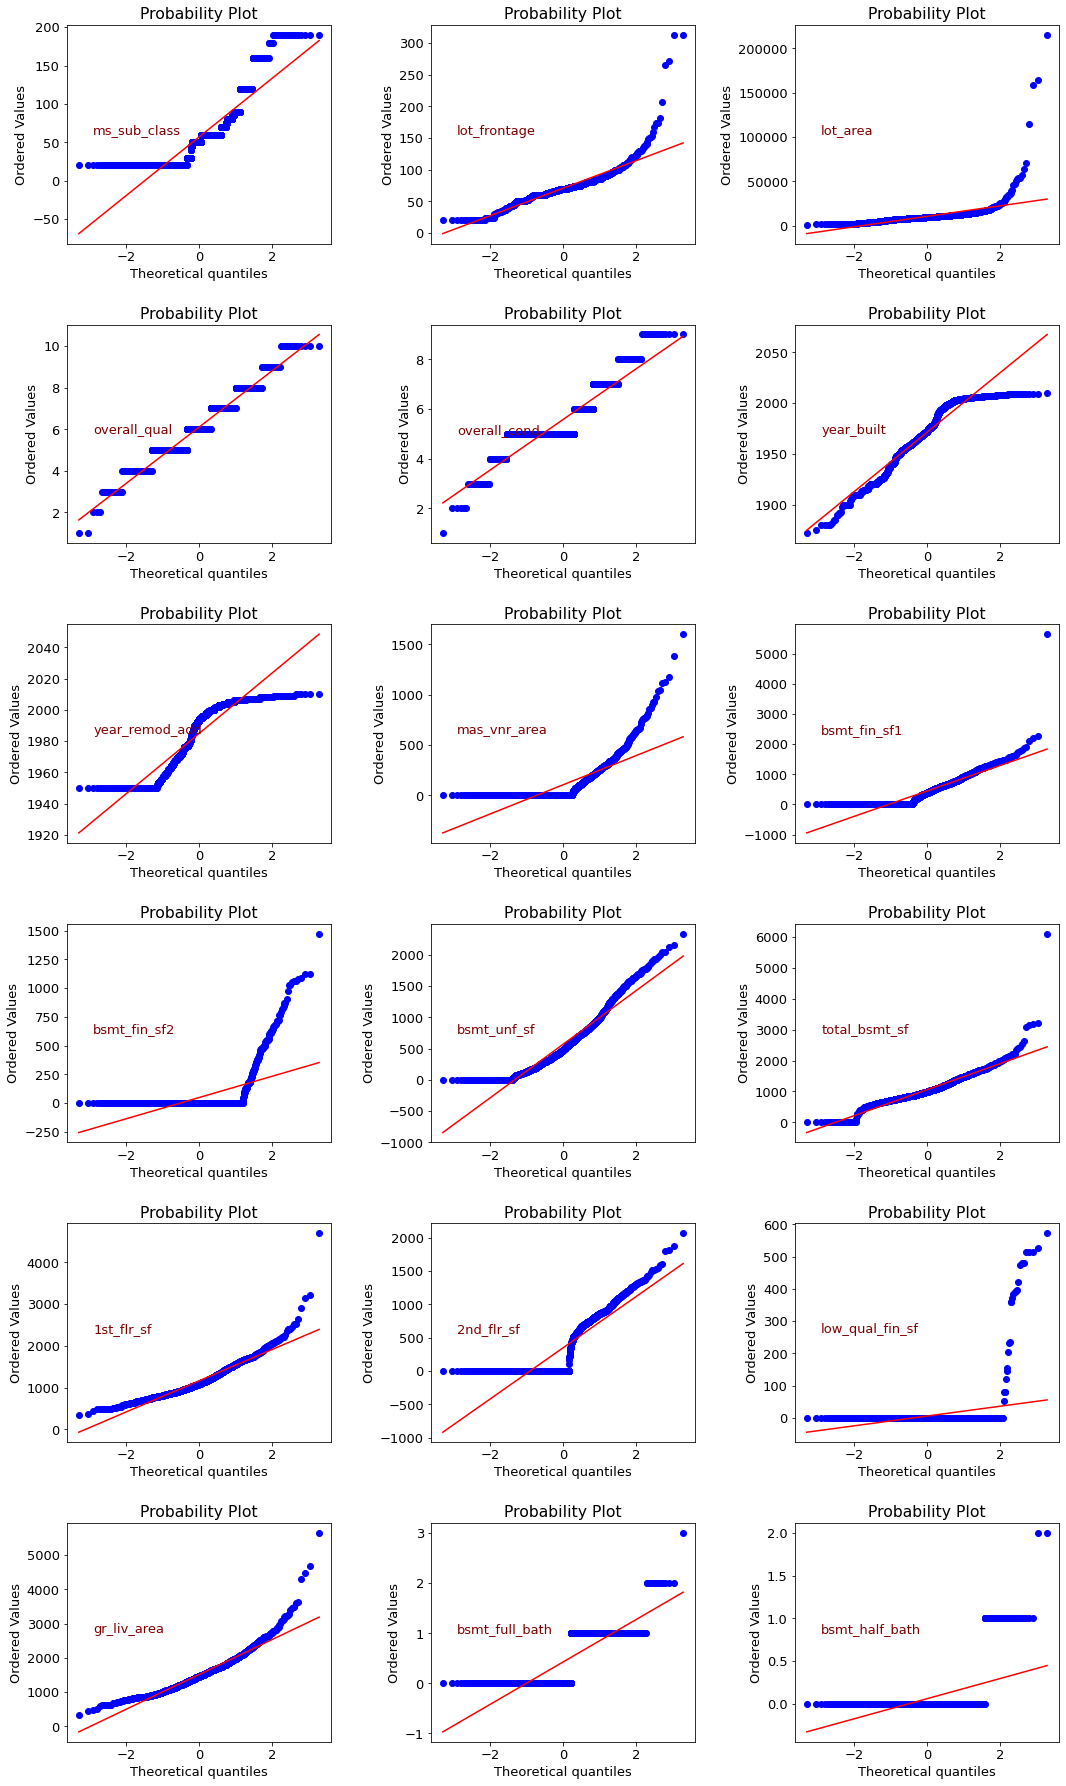

In [85]:
fig, ax = plt.subplots( 6, 3, figsize=(15, 25))
ax = ax.flatten()
for c, i in zip( num_att.columns[:18], range( len( num_att.columns[18:] ) ) ):
    ss.probplot( num_att[c], plot=ax[i] )
    plt.tight_layout(w_pad=2.0, h_pad=2.0)
    ax[i].text( .1, .5, c, color='maroon', transform=ax[i].transAxes)

## 5.2. Rescaling

In [189]:
df5 = df5.drop( columns=['floors_sqft'], axis=1 ) # 100% Corr

In [460]:
df5

ms_sub_class  ms_zoning  lot_frontage  lot_area  alley  lot_shape  \
0         0.235294   0.788356         -0.25 -0.254076      0          3   
1         0.000000   0.788356          0.50  0.030015      0          3   
2         0.235294   0.788356         -0.10  0.437624      0          2   
3         0.294118   0.788356         -0.50  0.017663      0          2   
4         0.235294   0.788356          0.70  1.181201      0          2   
...            ...        ...           ...       ...    ...        ...   
1455      0.235294   0.788356         -0.40 -0.385746      0          3   
1456      0.000000   0.788356          0.75  0.913167      0          3   
1457      0.294118   0.788356         -0.20 -0.107831      0          3   
1458      0.000000   0.788356         -0.10  0.058918      0          3   
1459      0.000000   0.788356          0.25  0.113266      0          3   

      land_contour  lot_config  land_slope  neighborhood  ...  sale_price  \
0                3    0.720548           2      0.102740  ...   59.297359   
1                3    0.032192           2      0.007534  ...   56.618567   
2                3    0.720548           2      0.102740  ...   60.686558   
3                3    0.180137           2      0.034932  ...   51.924941   
4                3    0.032192           2      0.028082  ...   62.996052   
...            ...         ...         ...           ...  ...         ...   
1455             3    0.720548           2      0.054110  ...   55.934447   
1456             3    0.720548           2      0.050000  ...   59.439220   
1457             3    0.720548           2      0.034932  ...   64.352547   
1458             3    0.720548           2      0.154110  ...   52.186338   
1459             3    0.720548           2      0.068493  ...   52.836090   

      christmans  easter  total_sqft  total_size_porch  garage_multy_car  \
0              0       0    0.195481          0.059396          0.181373   
1              0       0    0.191802          0.290166         -0.034314   
2              0       0    0.207742          0.040896          0.328431   
3              0       0    0.187336          0.298929          1.198529   
4              1       0    0.263531          0.268744          1.911765   
...          ...     ...         ...               ...               ...   
1455           0       0    0.198459          0.038948         -0.034314   
1456           0       0    0.287353          0.339825          0.063725   
1457           0       0    0.276581          0.058423         -0.852941   
1458           0       1    0.159573          0.465433         -0.867647   
1459           0       0    0.190751          0.782863         -0.823529   

      total_bath  total_abv_grade  mo_sold_sin  mo_sold_cos  
0              4             0.40     0.047582     0.998867  
1              3             0.30     0.189251     0.981929  
2              4             0.30     0.371662     0.928368  
3              2             0.35     0.047582     0.998867  
4              4             0.50     0.500000     0.866025  
...          ...              ...          ...          ...  
1455           3             0.35     0.327068     0.945001  
1456           3             0.35     0.047582     0.998867  
1457           2             0.50     0.189251     0.981929  
1458           2             0.20     0.142315     0.989821  
1459           3             0.30     0.235759     0.971812  

[1460 rows x 87 columns]

In [190]:
mms = MinMaxScaler()
rs = RobustScaler()

## MinMaxScaler
df5['ms_sub_class']    = mms.fit_transform( df5[['ms_sub_class']].values )
df5['overall_qual']    = mms.fit_transform( df5[['overall_qual']].values )
df5['overall_cond']    = mms.fit_transform( df5[['overall_cond']].values )
#df5['year_built']      = mms.fit_transform( df5[['year_built']].values )
df5['year_remod_add']  = mms.fit_transform( df5[['year_remod_add']].values )
df5['bsmt_unf_sf']     = mms.fit_transform( df5[['bsmt_unf_sf']].values )
df5['1st_flr_sf']      = mms.fit_transform( df5[['1st_flr_sf']].values )
df5['2nd_flr_sf']      = mms.fit_transform( df5[['2nd_flr_sf']].values )
df5['bsmt_full_bath']  = mms.fit_transform( df5[['bsmt_full_bath']].values )
df5['tot_rms_abv_grd'] = mms.fit_transform( df5[['tot_rms_abv_grd']].values )
df5['garage_yr_blt']   = mms.fit_transform( df5[['garage_yr_blt']].values )
df5['garage_area']     = mms.fit_transform( df5[['garage_area']].values )
df5['wood_deck_sf']    = mms.fit_transform( df5[['wood_deck_sf']].values )
df5['mo_sold']         = mms.fit_transform( df5[['mo_sold']].values )
#df5['yr_sold']        = mms.fit_transform( df5[['yr_sold']].values )
df5['total_sqft']      = mms.fit_transform( df5[['total_sqft']].values )
df5.total_size_porch   = mms.fit_transform( df5[['total_size_porch']].values )
df5.total_abv_grade    = mms.fit_transform( df5[['total_abv_grade']].values )

## RobustScaler
df5['lot_frontage']    = rs.fit_transform( df5[['lot_frontage']].values )
df5['lot_area']        = rs.fit_transform( df5[['lot_area']].values )
df5['mas_vnr_area']    = rs.fit_transform( df5[['mas_vnr_area']].values )
df5['bsmt_fin_sf1']    = rs.fit_transform( df5[['bsmt_fin_sf1']].values )
df5['bsmt_fin_sf2']    = rs.fit_transform( df5[['bsmt_fin_sf2']].values )
df5['total_bsmt_sf']   = rs.fit_transform( df5[['total_bsmt_sf']].values )
df5['low_qual_fin_sf'] = rs.fit_transform( df5[['low_qual_fin_sf']].values )
df5['gr_liv_area']     = rs.fit_transform( df5[['gr_liv_area']].values )
df5['open_porch_sf']   = rs.fit_transform( df5[['open_porch_sf']].values )
df5['enclosed_porch']  = rs.fit_transform( df5[['enclosed_porch']].values )
df5['3_ssn_porch']     = rs.fit_transform( df5[['3_ssn_porch']].values )
df5['screen_porch']    = rs.fit_transform( df5[['screen_porch']].values )
df5['pool_area']       = rs.fit_transform( df5[['pool_area']].values )
df5['misc_val']        = rs.fit_transform( df5[['misc_val']].values )
df5.garage_multy_car   = rs.fit_transform( df5[['garage_multy_car']].values )


In [465]:
mms = MinMaxScaler()
rs = RobustScaler()

# df5['overall_qual']    = mms.fit_transform( df5[['overall_qual']].values )
# pickle.dump( mms, open( 'overall_qual_scaler.pkl', 'wb' ) )

# df5['total_sqft']      = mms.fit_transform( df5[['total_sqft']].values )
# pickle.dump( mms, open( 'total_scaler.pkl', 'wb' ) )

# df5.total_abv_grade    = mms.fit_transform( df5[['total_abv_grade']].values )
# pickle.dump( mms, open( 'total_abv_scaler.pkl', 'wb' ) )

# df5.garage_multy_car   = rs.fit_transform( df5[['garage_multy_car']].values )
# pickle.dump( rs, open( 'garage_multy_car_scaler.pkl', 'wb' ))

# df5.exter_qual     = df5['exter_qual'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
# df5.foundation     = df5['foundation'].map( {'BrkTil':5, 'CBlock':4, 'PConc':3, 'Slab':2, 'Stone':1, 'Wood':0 } )
# df5.land_slope     = df5['land_slope'].map( {'Gtl':2, 'Mod':1, 'Sev':0} )
# df5.bldg_type      = df5['bldg_type'].map( {'1Fam':0, '2fmCon':1, 'Duplex':2, 'Twnhs':3, 'TwnhsE':4 } )
# df5.exter_cond     = df5['exter_cond'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
# df5.central_air    = df5['central_air'].map( {'Y':1, 'N':0} )
# df5.garage_finish  = df5['garage_finish'].map( {'Fin':3, 'RFn':2, 'Unf':1, 'DontHave':0} )
# df5.bsmt_cond      = df5['bsmt_cond'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )
# df5.heating_qc     = df5['heating_qc'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
# df5.paved_drive    = df5['paved_drive'].map( {'Y':2, 'P':1, 'N':0} )
# df5.fireplace_qu   = df5['fireplace_qu'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )

# f_conditi2 = df5.groupby( ['condition2'] ).size() / len(df5)
# f_neighbor = df5.groupby( ['neighborhood'] ).size() / len(df5)

# df5.condition2 = df5['condition2'].apply(  lambda x: f_conditi2[x] )
# df5.neighborhood  = df5['neighborhood'].apply(lambda x: f_neighbor[x] )

## 5.3. Transformation

### 5.3.1. Encoding

1. MSZoning: Identifies the general zoning classification of the sale.
2. LotShape: General shape of property
3. Alley: Acess on the property
4. LandContour: Flatness of the property
5. LotConfig: Lot configuration
6. Condition2: Proximity to various conditions (if more than one is present)
5. Condition1: Proximity to various conditions.
7. BldgType: Type of dwelling
8. Functional: Home functionality (Assume typical unless deductions are warranted)

In [192]:
f_zoning   = df5.groupby('ms_zoning').size() / len(df5)
f_lconfig  = df5.groupby( 'lot_config' ).size() / len(df5)
f_neighbor = df5.groupby( ['neighborhood'] ).size() / len(df5)
f_conditi1 = df5.groupby( ['condition1'] ).size() / len(df5)
f_conditi2 = df5.groupby( ['condition2'] ).size() / len(df5)
f_hstyle   = df5.groupby( ['house_style']).size() / len(df5)
f_rstyle   = df5.groupby( ['roof_style'] ).size() / len(df5)
f_roofmat  = df5.groupby( ['roof_matl'] ).size() / len(df5)
f_ext1     = df5.groupby( ['exterior1st'] ).size() / len(df5)
f_ext2     = df5.groupby( ['exterior2nd'] ).size() / len(df5)
f_msr      = df5.groupby( ['mas_vnr_type'] ).size() / len(df5)
f_heating  = df5.groupby( ['heating'] ).size() / len(df5)
f_eletric  = df5.groupby( ['electrical'] ).size() / len(df5)
f_funct    = df5.groupby( ['functional'] ).size() / len(df5)
f_grg_type = df5.groupby( ['garage_type'] ).size() / len(df5)
f_misc_feat= df5.groupby( ['misc_feature'] ).size() / len(df5)
f_sale_type= df5.groupby( ['sale_type'] ).size() / len(df5)
f_sale_cond= df5.groupby( ['sale_condition'] ).size() / len(df5) ###

df5.ms_zoning     = df5['ms_zoning'].apply(   lambda x: f_zoning[x] )
df5.lot_config    = df5['lot_config'].apply(  lambda x: f_lconfig[x] )
df5.neighborhood  = df5['neighborhood'].apply(lambda x: f_neighbor[x] )
df5.condition1    = df5['condition1'].apply(  lambda x: f_conditi1[x] )
df5.condition2    = df5['condition2'].apply(  lambda x: f_conditi2[x] )
df5.house_style   = df5['house_style'].apply( lambda x: f_hstyle[x] )
df5.roof_style    = df5['roof_style'].apply( lambda x: f_rstyle[x] )
df5.roof_matl     = df5['roof_matl'].apply(   lambda x: f_roofmat[x] )
df5.exterior1st   = df5['exterior1st'].apply( lambda x: f_ext1[x] )
df5.exterior2nd   = df5['exterior2nd'].apply( lambda x: f_ext2[x] )
df5.mas_vnr_type  = df5['mas_vnr_type'].apply( lambda x: f_msr[x] )
df5.heating       = df5['heating'].apply( lambda x: f_heating[x] )
df5.electrical    = df5['electrical'].apply(  lambda x: f_eletric[x] )
df5.functional    = df5['functional'].apply(  lambda x: f_funct[x] )
df5.garage_type   = df5['garage_type'].apply( lambda x: f_grg_type[x] )
df5.misc_feature  = df5['misc_feature'].apply( lambda x: f_misc_feat[x] )
df5.sale_type     = df5['sale_type'].apply( lambda x: f_sale_type[x] )
df5.sale_condition= df5['sale_condition'].apply( lambda x: f_sale_cond[x] )

df5.alley          = df5['alley'].map( {'Grvl':2, 'Pave':1, 'DontHave':0} )
df5.lot_shape      = df5['lot_shape'].map( {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0} )
df5.land_contour   = df5['land_contour'].map( {'Lvl':3, 'Bnk':2, 'Low':0, 'HLS':1} )
df5.land_slope     = df5['land_slope'].map( {'Gtl':2, 'Mod':1, 'Sev':0} )
df5.bldg_type      = df5['bldg_type'].map( {'1Fam':0, '2fmCon':1, 'Duplex':2, 'Twnhs':3, 'TwnhsE':4 } )
df5.exter_qual     = df5['exter_qual'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
df5.exter_cond     = df5['exter_cond'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
df5.foundation     = df5['foundation'].map( {'BrkTil':5, 'CBlock':4, 'PConc':3, 'Slab':2, 'Stone':1, 'Wood':0 } )
df5.bsmt_qual      = df5['bsmt_qual'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )
df5.bsmt_cond      = df5['bsmt_cond'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )
df5.bsmt_exposure  = df5['bsmt_exposure'].map( {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'DontHave':0 } )
df5.bsmt_fin_type1 = df5['bsmt_fin_type1'].map( {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'DontHave': 0 } )
df5.bsmt_fin_type2 = df5['bsmt_fin_type2'].map( {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'DontHave': 0 } )
df5.heating_qc     = df5['heating_qc'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
df5.central_air    = df5['central_air'].map( {'Y':1, 'N':0} )
df5.kitchen_qual   = df5['kitchen_qual'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0} )
df5.fireplace_qu   = df5['fireplace_qu'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )
df5.garage_finish  = df5['garage_finish'].map( {'Fin':3, 'RFn':2, 'Unf':1, 'DontHave':0} )
df5.garage_qual    = df5['garage_qual'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )
df5.garage_cond    = df5['garage_cond'].map( {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'DontHave':0} )
df5.paved_drive    = df5['paved_drive'].map( {'Y':2, 'P':1, 'N':0} )
df5.pool_qc        = df5['pool_qc'].map( {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'DontHave':0} )
df5.fence          = df5['fence'].map( {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'DontHave':0} )

### 5.3.1. Response Variable

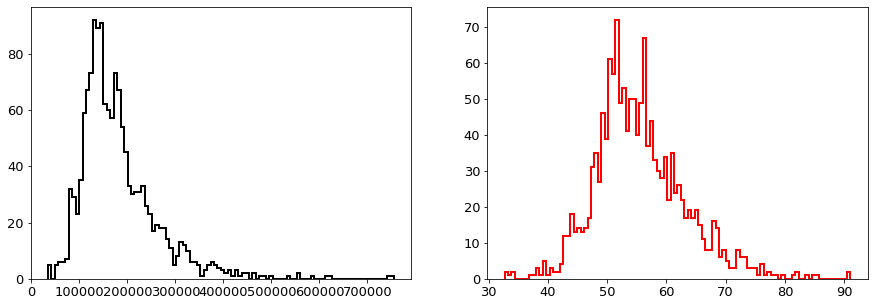

In [21]:
plot_targ_cube( df5, 'sale_price' )

In [193]:
df5['sale_price'] = (df5['sale_price'])**(1/3)

### 5.3.3. Natural

In [194]:
df5['mo_sold_sin'] = df5['mo_sold'].apply( lambda x: np.sin( x * ( 2. * ( np.pi / 12 ) ) ) )
df5['mo_sold_cos'] = df5['mo_sold'].apply( lambda x: np.cos( x * ( 2. * ( np.pi / 12 ) ) ) )

In [195]:
df5.to_csv('../data_backup/df5.csv')

In [201]:
df5

ms_sub_class  ms_zoning  lot_frontage  lot_area  alley  lot_shape  \
0         0.235294   0.788356         -0.25 -0.254076      0          3   
1         0.000000   0.788356          0.50  0.030015      0          3   
2         0.235294   0.788356         -0.10  0.437624      0          2   
3         0.294118   0.788356         -0.50  0.017663      0          2   
4         0.235294   0.788356          0.70  1.181201      0          2   
...            ...        ...           ...       ...    ...        ...   
1455      0.235294   0.788356         -0.40 -0.385746      0          3   
1456      0.000000   0.788356          0.75  0.913167      0          3   
1457      0.294118   0.788356         -0.20 -0.107831      0          3   
1458      0.000000   0.788356         -0.10  0.058918      0          3   
1459      0.000000   0.788356          0.25  0.113266      0          3   

      land_contour  lot_config  land_slope  neighborhood  ...  sale_price  \
0                3    0.720548           2      0.102740  ...   59.297359   
1                3    0.032192           2      0.007534  ...   56.618567   
2                3    0.720548           2      0.102740  ...   60.686558   
3                3    0.180137           2      0.034932  ...   51.924941   
4                3    0.032192           2      0.028082  ...   62.996052   
...            ...         ...         ...           ...  ...         ...   
1455             3    0.720548           2      0.054110  ...   55.934447   
1456             3    0.720548           2      0.050000  ...   59.439220   
1457             3    0.720548           2      0.034932  ...   64.352547   
1458             3    0.720548           2      0.154110  ...   52.186338   
1459             3    0.720548           2      0.068493  ...   52.836090   

      christmans  easter  total_sqft  total_size_porch  garage_multy_car  \
0              0       0    0.195481          0.059396          0.181373   
1              0       0    0.191802          0.290166         -0.034314   
2              0       0    0.207742          0.040896          0.328431   
3              0       0    0.187336          0.298929          1.198529   
4              1       0    0.263531          0.268744          1.911765   
...          ...     ...         ...               ...               ...   
1455           0       0    0.198459          0.038948         -0.034314   
1456           0       0    0.287353          0.339825          0.063725   
1457           0       0    0.276581          0.058423         -0.852941   
1458           0       1    0.159573          0.465433         -0.867647   
1459           0       0    0.190751          0.782863         -0.823529   

      total_bath  total_abv_grade  mo_sold_sin  mo_sold_cos  
0              4             0.40     0.047582     0.998867  
1              3             0.30     0.189251     0.981929  
2              4             0.30     0.371662     0.928368  
3              2             0.35     0.047582     0.998867  
4              4             0.50     0.500000     0.866025  
...          ...              ...          ...          ...  
1455           3             0.35     0.327068     0.945001  
1456           3             0.35     0.047582     0.998867  
1457           2             0.50     0.189251     0.981929  
1458           2             0.20     0.142315     0.989821  
1459           3             0.30     0.235759     0.971812  

[1460 rows x 87 columns]

# 6.0. Feature Selection

In [223]:
df6 = pd.read_csv( '../data_backup/df5.csv')
df6 = df6.drop( columns=['mo_sold', 'Unnamed: 0'], axis=1 )
df6 = df6[['ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'alley', 'lot_shape', 'land_contour', 'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_sf1', 'bsmt_fin_type2', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'kitchen_qual', 'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_drive', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3_ssn_porch', 'screen_porch', 'pool_area', 'pool_qc', 'fence', 'misc_feature', 'misc_val', 'yr_sold', 'sale_type', 'sale_condition', 'christmans', 'easter', 'total_sqft', 'mo_sold_sin', 'mo_sold_cos', 'total_size_porch', 'garage_multy_car', 'total_bath', 'total_abv_grade', 'sale_price']]

In [224]:
df_test = df6[df6['yr_sold'] == 2010]
X_test  = df_test.iloc[:, :-1]
y_test  = df_test.sale_price
df_train = df6[df6['yr_sold'] != 2010]
X_train  = df_train.iloc[:, :-1]
y_train  = df_train.sale_price

## 6.1. Feature Importance

In [225]:
xg = XGBRegressor( n_jobs=-1 ).fit( X_train.values, y_train.values )
rf = RandomForestRegressor( n_jobs=-1 ).fit( X_train.values, y_train.values )

In [226]:
imp  = get_importance( X_train.columns, xg )
imp2 = get_importance( X_train.columns, rf )

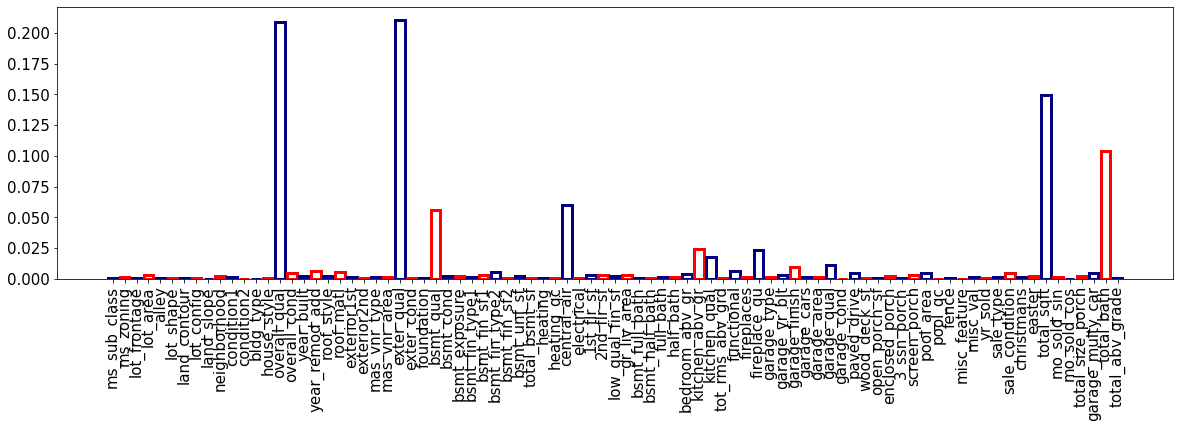

In [227]:
fig, ax = plt.subplots( figsize=(20, 5) )
ax.bar( imp.keys(), imp.values(), **args_b() )
plt.xticks( rotation=90 );

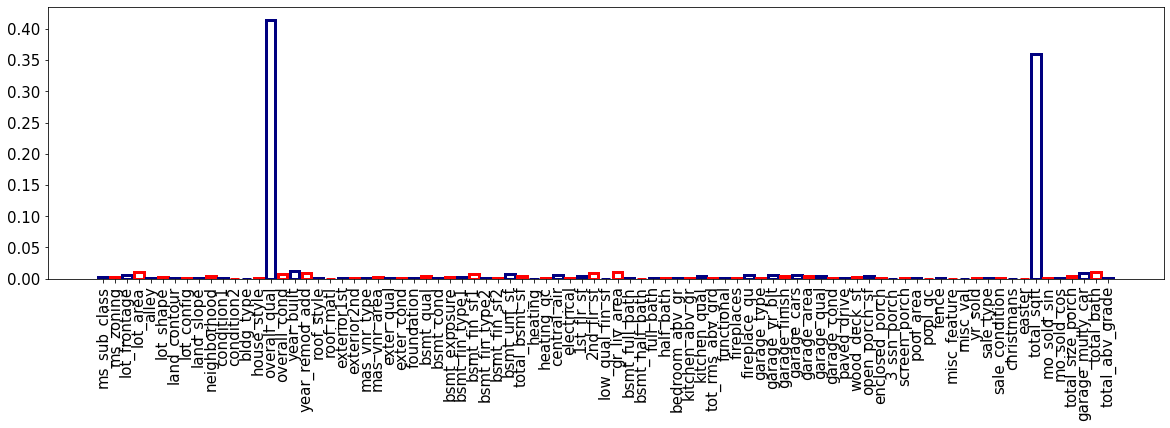

In [228]:
fig, ax = plt.subplots( figsize=(20, 5) )
ax.bar( imp2.keys(), imp2.values(), **args_b() )
plt.xticks( rotation=90 );

## 6.2. Manual Feature Selection


In [229]:
df6.columns

Index(['ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'alley',
       'lot_shape', 'land_contour', 'lot_config', 'land_slope', 'neighborhood',
       'condition1', 'condition2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod_add', 'roof_style',
       'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_sf1',
       'bsmt_fin_type2', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abv_gr',
       'kitchen_abv_gr', 'kitchen_qual', 'tot_rms_abv_grd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'garage_finish', 'garage_cars', 'garage_area

In [347]:
cols_selected = ['overall_qual', 'exter_qual', 'total_sqft', 'total_abv_grade', 'total_bath', 'garage_multy_car',
                 'land_slope', 'condition2', 'bldg_type', 'exter_cond', 'neighborhood', 'central_air', 'garage_finish',
                 'foundation', 'bsmt_cond', 'heating_qc', 'paved_drive', 'fireplace_qu']

1. **Overall Quall**: Suggestion of XGBoost and Random Forest and have a positive correlation.
2. **Exter Qual (Evaluates the quality of the material on the exterior)**: Suggestion of XGBoost, with Ordinal Encoder its haved a good Importance.
3. **Total Sqft**: Suggestion of XGBoost, feature engineering (living_area + bsmt).
4. **Total Abv Grade**: Feature Engineering Feature.
5. **Total Bath**: Feature Engineering feature.
6. **Garage Multy Car**: Feature Engineering Feature.
7. **Land Slope**: Visual Linear dependence with Sales, people prefer houses without Slope.
8. **Bldg Type**: Type of House.
9. **Exter Cond**: Exterior of House Condition.
10. **Neighborhood**: Neighborhood of House if located.
11. **Central Air**: Have Central air or Not.
12. **Garage Finish**: Have or no a finished agarage on House.
13. **Condition2**: Geral condition of the house.
15. **Foundation**: The of Foundation of the House.
16. **Bsmt Cond**: Overall condition of Basement.
17. **Heating Qc**: Quall of method Heating (Dense Glass...)
18. **Paved Drive**: Type of Paved Driveway ( Dirt, Partial or Paved )
14. **Fireplace Qu**: Quall of Fireplace of the house.

# 7.0. Machine Learning Models

In [350]:
df7 = df6[cols_selected]
df7['sale_price'] = df6['sale_price']

x_train = X_train[cols_selected]
x_test  = X_test[cols_selected]

## 7.1. Average Model

In [352]:
# aux = x_test.copy()
# aux['sale_price'] = y_test.copy()

# aux1 = aux[['house_style', 'sale_price']].groupby('house_style').mean().reset_index().rename( columns={'sale_price':'prediction'} )
# aux  = pd.merge( aux, aux1, how='left', on='house_style' )

# result_base = ml_error( (aux.prediction**3), (y_test**3), 'Avg Model' )
# result_base

## 7.2. SVR Regressor

In [242]:
svr = SVR( max_iter=5000 ).fit( x_train, y_train )

yhat = svr.predict( x_test )

svr_result = ml_error( (y_test)**3, (yhat)**3, 'SVR' )
svr_result

Model Name           MAE      MAPE          RMSE
0        SVR  53695.519268  0.320699  79584.455047

## 7.3. XGBoost Regressor

### 7.3.1. First Cycle

In [215]:
xg = XGBRegressor( n_jobs=-1 ).fit( x_train, y_train )

yhat = xg.predict( x_test )

xg_result = ml_error( (y_test)**3, (yhat)**3, 'XGBoost')
xg_result

Model Name           MAE      MAPE          RMSE
0    XGBoost  21444.537701  0.127423  32227.094808

### 7.3.2. Second Cycle

In [353]:
xg = XGBRegressor( n_jobs=-1 ).fit( x_train, y_train )

yhat = xg.predict( x_test )

xg_result = ml_error( (y_test)**3, (yhat)**3, 'XGBoost')
xg_result

Model Name           MAE      MAPE          RMSE
0    XGBoost  16410.859531  0.101769  23882.613665

## 7.4. Random Forest Regressor

### 7.4.1. First Cycle

In [98]:
rf = RandomForestRegressor( n_jobs=-1, random_state=42 ).fit( x_train, y_train )

yhat = rf.predict( x_test )

rf_result = ml_error( y_test**3, yhat**3, 'Random Forest' )
rf_result

Model Name           MAE      MAPE          RMSE
0  Random Forest  20388.703156  0.121168  30819.698855

### 7.4.2. Second Cycle

In [354]:
rf = RandomForestRegressor( n_jobs=-1 ).fit( x_train, y_train )

yhat = rf.predict( x_test )

rf_result = ml_error( y_test**3, yhat**3, 'Random Forest' )
rf_result

Model Name           MAE      MAPE          RMSE
0  Random Forest  17979.531426  0.104908  27783.781028

## 7.5. Model Results

In [221]:
r = pd.concat( [result_base, svr_result, xg_result, rf_result], axis=0 ).reset_index( drop=True ).sort_values( 'RMSE' )
r

Model Name           MAE      MAPE          RMSE
3  Random Forest  20388.703156  0.121168  30819.698855
2        XGBoost  21444.537701  0.127423  32227.094808
0      Avg Model  49714.666567  0.296596  66956.543427
1            SVR  53635.112048  0.320227  79538.701579

In [359]:
r = pd.concat( [rf_result, xg_result], axis=0 ).reset_index(drop=True).sort_values('RMSE')
r

Model Name           MAE      MAPE          RMSE
1        XGBoost  16410.859531  0.101769  23882.613665
0  Random Forest  17979.531426  0.104908  27783.781028

## 7.6. Cross Validation 

In [179]:
cv_before_tuning = cross_validation_year( df6, 'yr_sold', 'XGBoost', XGBRegressor( n_jobs=-1 ) )
cv_before_tuning

Model Name                MAE Cv        MAPE Cv               RMSE Cv
0    XGBoost  20329.41 +/- 1210.49  0.12 +/- 0.01  33239.08 +/- 3701.73

In [366]:
# Second Cycle
cv_before_tuning = cross_validation_year( df6, 'yr_sold', 'XGBoost', XGBRegressor( n_jobs=-1 ) )
cv_before_tuning

Model Name                MAE Cv        MAPE Cv               RMSE Cv
0    XGBoost  20543.29 +/- 1054.91  0.12 +/- 0.01  33742.69 +/- 3442.61

In [181]:
cross_validation_year( df6, 'yr_sold', 'Random Forest', RandomForestRegressor( n_jobs=-1 ) )

Model Name               MAE Cv        MAPE Cv               RMSE Cv
0  Random Forest  19103.29 +/- 1541.6  0.11 +/- 0.01  31370.54 +/- 4131.44

# 8.0. Hyperparameter Tuning

## 8.1. Random Search

In [387]:
params = { 
    'eta': [.03, .04, .05, .06],
    'gamma': [0, .5, 1],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight':[1, 2, 3, 4,],
    'subsample': [.5, 1],
    'colsample_bytree': [.5, 1]
}

In [388]:
mae, rmse = [], []

for i in range( 100 ):
    hp = {k: sample( v, 1 )[0] for k, v in params.items()}
    print(hp, file=open( 'tuning.txt', 'a' ) )
    
    xg = XGBRegressor( n_jobs=-1,
                       eta       = hp['eta'],
                       gamma     = hp['gamma'],
                       max_depth = hp['max_depth'],
                       subsample = hp['subsample'],
                       colsample_bytree = hp['colsample_bytree'],
                       min_child_weight = hp['min_child_weight'] )
    
    ml_performace = cross_validation_year( df6, 'yr_sold', 'XGBoost', xg )
    print( f"MAE: {ml_performace['MAE Cv'][0]} \nRMSE: {ml_performace['RMSE Cv'][0]} \n", file=open( 'tuning.txt', 'a' ) )
    
    mae.append( ml_performace['MAE Cv'][0] )
    rmse.append( ml_performace['RMSE Cv'][0] )


## 8.1. Final Model

### 8.1.1. First Cycle

In [368]:
best_params = { 
    'eta': 0.05,
    'gamma': 0,
    'max_depth': 3,
    'min_child_weight': 4,
    'subsample': 1,
    'colsample_bytree': 1
}

In [11]:
xg_tunned = XGBRegressor( n_jobs=-1,
                          eta       = best_params['eta'],
                          gamma     = best_params['gamma'],
                          max_depth = best_params['max_depth'],
                          subsample = best_params['subsample'],
                          colsample_bytree = best_params['colsample_bytree'],
                          min_child_weight = best_params['min_child_weight'] )

xg = xg_tunned.fit( x_train, y_train )

yhat = xg.predict( x_test )

xg_result = ml_error( y_test**3, yhat**3, 'XGBoost Tunned' )

xg_result

Model Name           MAE      MAPE          RMSE
0  XGBoost Tunned  17703.515982  0.106596  26784.923806

In [254]:
cross_validation_year( df6, 'yr_sold', 'XGBoost Tunned', xg_tunned )

Model Name                MAE Cv        MAPE Cv               RMSE Cv
0  XGBoost Tunned  19478.72 +/- 1158.95  0.11 +/- 0.01  32481.69 +/- 4234.86

### 8.1.2. Second Cycle

In [418]:
best_params = {'eta': 0.06, 'gamma': 0.5, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': .5}

In [419]:
xg_tunned = XGBRegressor( n_jobs=-1,
                          eta       = best_params['eta'],
                          gamma     = best_params['gamma'],
                          max_depth = best_params['max_depth'],
                          subsample = best_params['subsample'],
                          colsample_bytree = best_params['colsample_bytree'],
                          min_child_weight = best_params['min_child_weight'] )

xg = xg_tunned.fit( x_train, y_train )

yhat = xg.predict( x_test )

xg_result = ml_error( y_test**3, yhat**3, 'XGBoost Tunned' )

xg_result

Model Name           MAE      MAPE          RMSE
0  XGBoost Tunned  16476.810045  0.098707  24215.308593

In [420]:
cross_validation_year( df6, 'yr_sold', 'XGBoost Tunned', xg_tunned )

Model Name               MAE Cv      MAPE Cv               RMSE Cv
0  XGBoost Tunned  18064.04 +/- 1142.8  0.1 +/- 0.0  30286.68 +/- 4544.32

### 8.1.3. Results

In [421]:
pickle.dump( xg_tunned, open('xgb_tuned.pkl', 'wb') )

In [422]:
upper_mae  = [int( re.match( '\d+', p ).group(0) ) for p in mae]
lower_mae  = [int((re.findall( '\ [0-9 ]+', p )[0]).strip()) for p in mae]
upper_rmse = [int( re.match( '\d+', p ).group(0) ) for p in rmse]
lower_rmse = [int((re.findall( '\ [0-9 ]+', p )[0]).strip()) for p in rmse]

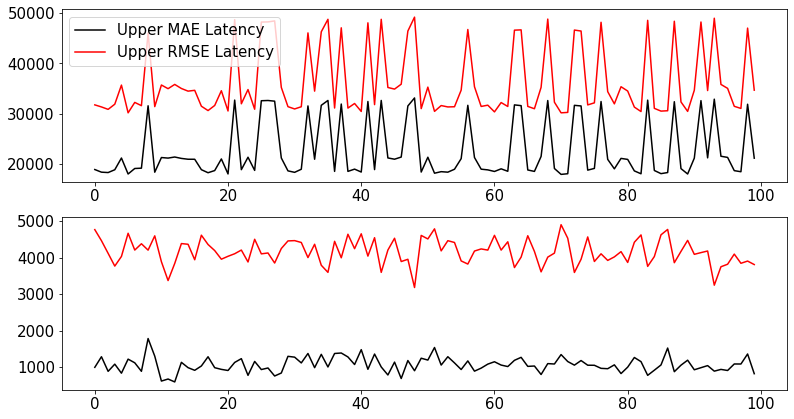

In [423]:
fig, ax = plt.subplots( 2, 1, figsize=(13, 7))
ax[0].plot( upper_mae,  label='Upper MAE Latency',  c='k' )
ax[0].plot( upper_rmse, label='Upper RMSE Latency', c='r' )
ax[1].plot( lower_mae,  label='Lower MAE Latency',  c='k' )
ax[1].plot( lower_rmse, label='Lower RMSE Latency', c='r' )
ax[0].legend();